# Set-Up

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import approx_post
import seaborn as sns
import matplotlib.pyplot as plt
from arraytainers import Jaxtainer
sns.set({'figure.facecolor':'white', "figure.figsize":(10,7)})

# Plotting Functions

In [3]:
palette = sns.color_palette()
samples_per_d = 100

In [4]:
def plot_data(y, d, model, theta_lims=(-5,5)):
    y_reshaped = y.reshape(-1, samples_per_d)
    d_reshaped = d.reshape(-1, samples_per_d)
    theta = jnp.linspace(theta_lims[0], theta_lims[1], samples_per_d)
    fig, ax = plt.subplots()
    for idx, (y_i, d_i) in enumerate(zip(y_reshaped, d_reshaped)):
        d_val = d_i[0]
        sns.scatterplot(x=theta.squeeze(), y=y_i.squeeze())
        sns.lineplot(x=theta.squeeze(), y=model(theta,d_val).squeeze(), label=f"d={d_val:.1f}", color=palette[idx])
        plt.xlabel("Parameter $\\theta$")
        plt.ylabel("(Noisy) Observations $y$")
    return fig

In [5]:
def plot_phi_function(amortised_dist, d_idx=None, d=None, y_obs=None, model=None, y_lims=(-50,50), num_y_pts=200, theta_lims=(-5,5)):
    y = jnp.linspace(y_lims[0], y_lims[1], num_y_pts).reshape(-1,1)
    if (d is None) and (d_idx is None):
        d_plot = 0.0
        pred_phi = amortised_dist.phi(y)
    else:
        d_plot = d.reshape(-1,samples_per_d)[d_idx,:][0]
        pred_phi = amortised_dist.phi(y, d_plot)
    pred_mean, pred_std = pred_phi['mean'].squeeze(), jnp.exp(pred_phi['log_chol_diag']).squeeze()
    mean_plus_cov = pred_mean + 2*pred_std
    mean_minus_cov = pred_mean - 2*pred_std
    
    x_plt = y.squeeze()
    ax = sns.lineplot(x=x_plt, y=pred_mean, label=f"Predicted Mean for d={d_plot:.1f}", color='red')
    sns.lineplot(x=x_plt, y=mean_plus_cov, color='red', label=f"Predicted Mean Plus/Minus 2×Predicted Std for d={d_plot:.1f}", linestyle='--')
    sns.lineplot(x=x_plt, y=mean_minus_cov, color='red', linestyle='--')
    ax.fill_between(x_plt, mean_minus_cov, mean_plus_cov, color="red", alpha=0.2)
    if y_obs is not None:
        y_plot = y_obs.reshape(-1,samples_per_d)[d_idx,:]
        true_theta = jnp.linspace(theta_lims[0], theta_lims[1], samples_per_d)
        sns.scatterplot(x=y_plot.squeeze(), y=true_theta.squeeze(), label=f"Observations") 
    if model is not None:
        true_theta = jnp.linspace(theta_lims[0], theta_lims[1], samples_per_d)
        sns.scatterplot(x=model(true_theta.squeeze(), d_plot), y=true_theta.squeeze(), label=f"True Relationship", color='g')
    plt.xlabel("Observation $y$")
    plt.ylabel("Parameter $\\theta$")
    plt.show()

In [6]:
def plot_phi_surface(amortised_dist, key, d_lims=(-2,2), y_lims=(-50,50), num_d_pts=100, num_y_pts=100, apply_mask=False):
    d_vals = jnp.linspace(d_lims[0], d_lims[1], num_d_pts)
    y_vals = jnp.linspace(y_lims[0], y_lims[1], num_y_pts)
    d_grid, y_grid = jnp.meshgrid(d_vals, y_vals)
    d = d_grid.reshape(-1, 1)
    y = y_grid.reshape(-1, 1)
    phi = amortised_dist.phi(x=y, d=d)[key]
    if apply_mask:
        mask = ((d>0) & (y<0)) | ((d<=0) & (y>0))
        phi = np.ma.masked_where(mask, phi)
    phi = phi.reshape(num_y_pts, num_d_pts)
    fig, ax = plt.subplots()
    im = plt.imshow(phi, cmap='coolwarm', origin='lower')
    cbar = plt.colorbar(im)
    cbar.set_label(key, rotation=270, labelpad=15)
    if apply_mask:
        ax.set_facecolor('black')
    ax.set_xlabel('$y$')
    ax.set_ylabel('$d$')

# Artificial Data Creation

In [7]:
def create_data(model, d_vals, noise_cov, prngkey, theta_lims=(-5,5)):
    theta = jnp.linspace(theta_lims[0], theta_lims[1], samples_per_d)
    # Zero-mean samples:
    epsilon = jax.random.multivariate_normal(prngkey, mean=jnp.zeros((1,)), 
                                             cov=noise_cov, shape=(samples_per_d,)) # shape = (num_batch, dim_x)
    y, d = [], []
    for d_i in d_vals:
        mean_vals = model(theta, d_i).reshape(samples_per_d, -1) # shape = (num_batch, dim_theta)
        y.append(mean_vals + epsilon) # shape = (num_batch, x_dim)
        d.append(jnp.repeat(d_i, repeats=samples_per_d).reshape(samples_per_d, -1))
    return jnp.concatenate(y, axis=0), jnp.concatenate(d, axis=0)

In [8]:
# Define model:
ndim = 1
# model_func = lambda theta, d: d*theta**2
def model_func(theta, d):
    y = d*theta**2
    return y

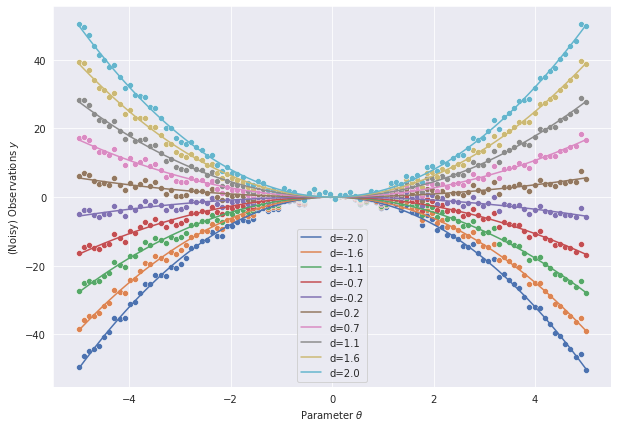

In [20]:
prngkey = jax.random.PRNGKey(42)
d_vals = jnp.linspace(-2, 2, 10) #, 1.5
noise_cov = 1*jnp.identity(ndim)
y, d = create_data(model_func, d_vals, noise_cov, prngkey)
fig = plot_data(y, d, model_func)
fig.show()

In [21]:
prior_mean = jnp.zeros(ndim)
prior_cov = jnp.identity(ndim)
noise_cov = jnp.identity(ndim)

Now let's try include $d$:

In [22]:
model, model_grad = approx_post.models.from_jax(model_func)
joint_dist = approx_post.distributions.joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)
prngkey = jax.random.PRNGKey(10)
approx_dist = approx_post.distributions.approx.Gaussian(1)
preprocessing = approx_post.distributions.amortised.Preprocessing.std_scaling(y, d) #,d
phi_lims = None 
amortised_dist = approx_post.distributions.amortised.NeuralNetwork(approx_dist, x_dim=1, d_dim=1, prngkey=prngkey, 
                                                                   num_layers=5, width=10, activation='tanh',
                                                                   preprocessing=preprocessing, phi_lims=phi_lims)

In [24]:
loss = approx_post.losses.ELBO(joint_dist, use_reparameterisation=True)
optimiser = approx_post.optimisers.Adam()
loss = optimiser.fit(amortised_dist, loss, x=y, d=d, prngkey=prngkey, verbose=True, num_samples=1000, max_iter=100) 

Loss = 44.33634567260742, Params = Jaxtainer({'W_0': DeviceArray([[ 0.3025231 ,  0.19452894,  0.3228606 , -1.2041827 ,
               1.6700927 ,  1.260841  ,  1.8586386 ,  0.5328807 ,
               1.0045218 ,  0.19366731],
             [-0.66194755,  1.600349  , -0.8036839 , -1.0415429 ,
               1.1839423 ,  0.585348  , -0.55184454,  0.46241364,
               2.0810568 , -1.9584776 ]], dtype=float32), 'b_0': DeviceArray([ 0.22954905,  0.18423682, -0.11536824, -0.1875565 ,
              0.01062953,  0.28716683, -0.2264758 ,  0.37403673,
             -0.21409816,  0.20786206], dtype=float32), 'W_1': DeviceArray([[-0.04045046,  0.10961477, -0.17675373, -0.45218053,
               0.43381387, -0.69692284, -0.6175222 ,  0.42401642,
               0.5281074 , -0.9284728 ],
             [-0.34505427, -0.8154897 ,  0.27664232,  0.75961936,
              -1.0958573 , -0.66372764, -0.27049145, -0.2433638 ,
               0.32837853,  0.5453613 ],
             [-0.2948    ,  0.3573771 

Loss = 102.98174285888672, Params = Jaxtainer({'W_0': DeviceArray([[ 0.23500599,  0.26303595,  0.2553566 , -1.1374651 ,
               1.603672  ,  1.3404417 ,  1.9227014 ,  0.46666384,
               0.9376837 ,  0.09551542],
             [-0.7296434 ,  1.6672957 , -0.87096614, -1.1081638 ,
               1.249882  ,  0.50353223, -0.48559055,  0.5289786 ,
               2.1476986 , -2.044208  ]], dtype=float32), 'b_0': DeviceArray([ 0.29644954,  0.11669684, -0.04835722, -0.25475186,
              0.07860265,  0.38702315, -0.16198708,  0.44145867,
             -0.28736144,  0.28617516], dtype=float32), 'W_1': DeviceArray([[ 0.02850207,  0.19208302, -0.10911281, -0.37450072,
               0.50108737, -0.62999135, -0.55410993,  0.49068362,
               0.45927805, -1.0231471 ],
             [-0.41297695, -0.86827874,  0.34413573,  0.8338294 ,
              -1.1628621 , -0.7275303 , -0.32919034, -0.31027207,
               0.4084304 ,  0.5182325 ],
             [-0.2262559 ,  0.4398537

Loss = 93.07946014404297, Params = Jaxtainer({'W_0': DeviceArray([[ 0.18086004,  0.313649  ,  0.20246933, -1.0888995 ,
               1.5662293 ,  1.4088519 ,  1.9643879 ,  0.42290834,
               0.87800676,  0.03550542],
             [-0.7909855 ,  1.7184521 , -0.9257754 , -1.1535043 ,
               1.2800478 ,  0.42623037, -0.44091463,  0.56958145,
               2.2014492 , -2.1067832 ]], dtype=float32), 'b_0': DeviceArray([ 0.35368806,  0.06396681,  0.00866463, -0.32492808,
              0.15726268,  0.45745736, -0.10944116,  0.5185489 ,
             -0.34516987,  0.3477876 ], dtype=float32), 'W_1': DeviceArray([[ 0.09104888,  0.27425748, -0.0519556 , -0.31618863,
               0.5619397 , -0.6200479 , -0.57473963,  0.54192597,
               0.4108325 , -1.1172968 ],
             [-0.4737093 , -0.8937002 ,  0.38950884,  0.8901719 ,
              -1.2064682 , -0.7376038 , -0.28993478, -0.3617425 ,
               0.4874689 ,  0.5501734 ],
             [-0.16617678,  0.52157176

Loss = 81.83512115478516, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13850397,  0.355974  ,  0.15933093, -1.0500069 ,
               1.5381668 ,  1.4720927 ,  1.9870644 ,  0.38719857,
               0.8279125 , -0.01349796],
             [-0.84527755,  1.7605252 , -0.9714018 , -1.1893965 ,
               1.3005252 ,  0.3520118 , -0.4117378 ,  0.6002732 ,
               2.244378  , -2.1578798 ]], dtype=float32), 'b_0': DeviceArray([ 0.39933494,  0.01790481,  0.05534566, -0.38196078,
              0.21880764,  0.5247296 , -0.07457058,  0.5873664 ,
             -0.41566387,  0.39952165], dtype=float32), 'W_1': DeviceArray([[ 0.14230722,  0.36130503, -0.00399711, -0.26937577,
               0.63297653, -0.62019694, -0.60581046,  0.58383554,
               0.3846739 , -1.2034354 ],
             [-0.5227782 , -0.8671413 ,  0.42496502,  0.9357058 ,
              -1.218364  , -0.7381388 , -0.24709983, -0.4037146 ,
               0.49044615,  0.5942481 ],
             [-0.11728922,  0.6082269 

Loss = 69.38975524902344, Params = Jaxtainer({'W_0': DeviceArray([[ 0.08128979,  0.37803108,  0.11327482, -1.019454  ,
               1.5294685 ,  1.5432289 ,  1.974352  ,  0.33665586,
               0.7778909 , -0.05372397],
             [-0.90469396,  1.7905056 , -1.0167408 , -1.2142822 ,
               1.3016809 ,  0.27234864, -0.41118544,  0.60640305,
               2.276361  , -2.2011828 ]], dtype=float32), 'b_0': DeviceArray([ 0.453749  , -0.03670277,  0.10551257, -0.43626168,
              0.26872784,  0.602987  , -0.03592921,  0.6670929 ,
             -0.49644452,  0.4387139 ], dtype=float32), 'W_1': DeviceArray([[ 0.18233413,  0.32025564,  0.0445639 , -0.22584444,
               0.58474267, -0.6626149 , -0.66630775,  0.6187937 ,
               0.32684746, -1.2928172 ],
             [-0.5615529 , -0.9166704 ,  0.4480464 ,  0.9769141 ,
              -1.2737485 , -0.6968965 , -0.18477517, -0.4392276 ,
               0.43665436,  0.66022813],
             [-0.07903753,  0.5667535 

Loss = 56.623966217041016, Params = Jaxtainer({'W_0': DeviceArray([[ 0.10594867,  0.39039215,  0.07912265, -0.9936651 ,
               1.5345792 ,  1.6167276 ,  1.9339381 ,  0.2702645 ,
               0.7183447 , -0.08838858],
             [-0.9725262 ,  1.8140575 , -1.0623739 , -1.2321371 ,
               1.2886897 ,  0.19157097, -0.43033025,  0.59423876,
               2.3040454 , -2.2384021 ]], dtype=float32), 'b_0': DeviceArray([ 0.4741108 , -0.09399018,  0.14751862, -0.4832964 ,
              0.28647304,  0.6235147 , -0.02066255,  0.7522095 ,
             -0.5834679 ,  0.47693   ], dtype=float32), 'W_1': DeviceArray([[ 2.15930626e-01,  3.03286254e-01,  9.38029215e-02,
              -1.88607335e-01,  5.43924212e-01, -7.26347029e-01,
              -7.35642254e-01,  6.48903906e-01,  3.09829533e-01,
              -1.38388741e+00],
             [-5.93931794e-01, -9.34149325e-01,  4.54304129e-01,
               1.01224518e+00, -1.31869924e+00, -6.33747637e-01,
              -1.09866224e

Loss = 47.70928192138672, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16095512,  0.38798735,  0.11473766, -0.96997815,
               1.5467268 ,  1.6982843 ,  1.9040147 ,  0.22210968,
               0.6473494 , -0.11856461],
             [-1.0476857 ,  1.8349862 , -1.0948948 , -1.2465525 ,
               1.2685002 ,  0.1052516 , -0.4344494 ,  0.57902867,
               2.3326354 , -2.2708497 ]], dtype=float32), 'b_0': DeviceArray([ 0.4313619 , -0.1560934 ,  0.12185121, -0.52330965,
              0.28258812,  0.59643936,  0.00334501,  0.81258786,
             -0.6738625 ,  0.51422226], dtype=float32), 'W_1': DeviceArray([[ 0.24576773,  0.31418458,  0.1469954 , -0.15636285,
               0.5073839 , -0.80088544, -0.8105688 ,  0.67537   ,
               0.3226915 , -1.476901  ],
             [-0.62283003, -0.9239112 ,  0.44238287,  1.0429777 ,
              -1.3538679 , -0.5588894 , -0.03237825, -0.49700627,
               0.34617764,  0.8163815 ],
             [-0.01797801,  0.5660955 

Loss = 31.91672134399414, Params = Jaxtainer({'W_0': DeviceArray([[ 0.20459852,  0.37584475,  0.14806947, -0.94672215,
               1.558528  ,  1.7672447 ,  1.8641002 ,  0.19329806,
               0.56798255, -0.1453751 ],
             [-1.1301559 ,  1.8582308 , -1.1334833 , -1.2596464 ,
               1.2455152 ,  0.02469575, -0.44059926,  0.56418234,
               2.3721137 , -2.299323  ]], dtype=float32), 'b_0': DeviceArray([ 0.3734877 , -0.22014716,  0.07664588, -0.56331795,
              0.27255768,  0.56466496,  0.02075831,  0.8587513 ,
             -0.7385153 ,  0.55839705], dtype=float32), 'W_1': DeviceArray([[ 0.2735358 ,  0.33213452,  0.21050623, -0.12796596,
               0.47353858, -0.8765545 , -0.8908621 ,  0.6988354 ,
               0.37310335, -1.5685885 ],
             [-0.6497598 , -0.9071233 ,  0.40693405,  1.0700636 ,
              -1.3831562 , -0.48116225,  0.05188671, -0.52096844,
               0.29072624,  0.9024803 ],
             [ 0.00857508,  0.5826229 

Loss = 23.525924682617188, Params = Jaxtainer({'W_0': DeviceArray([[ 0.23743184,  0.36786684,  0.15958084, -0.92481107,
               1.5660913 ,  1.823674  ,  1.8240956 ,  0.18395653,
               0.48307207, -0.1698775 ],
             [-1.207928  ,  1.8889799 , -1.1803797 , -1.272054  ,
               1.2260883 , -0.04392891, -0.44793898,  0.5513154 ,
               2.4246788 , -2.32384   ]], dtype=float32), 'b_0': DeviceArray([ 0.31575   , -0.2643857 ,  0.02598   , -0.60342276,
              0.26638123,  0.5413677 ,  0.02896899,  0.89786035,
             -0.7472583 ,  0.616105  ], dtype=float32), 'W_1': DeviceArray([[ 0.30031288,  0.35016716,  0.25950083, -0.1026374 ,
               0.44347933, -0.93995166, -0.95668656,  0.71959186,
               0.430212  , -1.6438495 ],
             [-0.6761345 , -0.8915737 ,  0.38403216,  1.0941963 ,
              -1.4108845 , -0.40931705,  0.1334326 , -0.54215217,
               0.25232503,  0.983155  ],
             [ 0.03398884,  0.6029126

Loss = 24.4725341796875, Params = Jaxtainer({'W_0': DeviceArray([[ 0.2739074 ,  0.358908  ,  0.16202019, -0.90867275,
               1.5512387 ,  1.8933427 ,  1.8503476 ,  0.18637264,
               0.39369738, -0.19251171],
             [-1.2601439 ,  1.9360855 , -1.2180606 , -1.2814343 ,
               1.2336936 , -0.11936197, -0.4104057 ,  0.53369755,
               2.4914346 , -2.3442643 ]], dtype=float32), 'b_0': DeviceArray([ 0.26927492, -0.27615505,  0.0026079 , -0.63687134,
              0.29820088,  0.49728656,  0.07684509,  0.9167624 ,
             -0.7064152 ,  0.6857662 ], dtype=float32), 'W_1': DeviceArray([[ 0.32745585,  0.38675356,  0.22584632, -0.07977648,
               0.43029243, -0.9938929 , -1.0264726 ,  0.7374433 ,
               0.39662954, -1.717453  ],
             [-0.7031342 , -0.85984844,  0.42581004,  1.1158037 ,
              -1.4459096 , -0.35589868,  0.1629886 , -0.5605668 ,
               0.29676867,  1.045919  ],
             [ 0.05942013,  0.6421204 ,

Loss = 21.778133392333984, Params = Jaxtainer({'W_0': DeviceArray([[ 0.30111387,  0.34725606,  0.11839634, -0.8959819 ,
               1.5396023 ,  1.9559282 ,  1.8720785 ,  0.1798244 ,
               0.30450836, -0.21396042],
             [-1.3079093 ,  1.9851844 , -1.2768124 , -1.2894828 ,
               1.2395236 , -0.1863538 , -0.37793213,  0.51656204,
               2.5600085 , -2.3619685 ]], dtype=float32), 'b_0': DeviceArray([ 0.23073357, -0.2749002 ,  0.0158846 , -0.675783  ,
              0.3303439 ,  0.45885807,  0.11971287,  0.93540967,
             -0.6567263 ,  0.7594942 ], dtype=float32), 'W_1': DeviceArray([[ 0.35404146,  0.38072792,  0.19600494, -0.05885561,
               0.41896045, -0.9785611 , -1.0251004 ,  0.75197023,
               0.3613138 , -1.7777702 ],
             [-0.7292679 , -0.8678087 ,  0.4630665 ,  1.1353606 ,
              -1.4779016 , -0.28959456,  0.21796152, -0.57601273,
               0.3344107 ,  1.1051824 ],
             [ 0.08436987,  0.6500248

Loss = 58.951019287109375, Params = Jaxtainer({'W_0': DeviceArray([[ 0.32598367,  0.34122074,  0.1473769 , -0.8901856 ,
               1.5365032 ,  2.0123968 ,  1.8921076 ,  0.17744501,
               0.22512135, -0.23385482],
             [-1.350065  ,  2.0267525 , -1.2676197 , -1.2952759 ,
               1.2425257 , -0.24595281, -0.35053328,  0.50022876,
               2.619568  , -2.3769062 ]], dtype=float32), 'b_0': DeviceArray([ 0.1973933 , -0.29689023,  0.05109884, -0.7041805 ,
              0.35541892,  0.42536682,  0.15587562,  0.95043075,
             -0.6288109 ,  0.8403367 ], dtype=float32), 'W_1': DeviceArray([[ 0.37586448,  0.42446554,  0.16993628, -0.03998409,
               0.40922508, -1.0225489 , -1.0712665 ,  0.7639362 ,
               0.32109815, -1.8446338 ],
             [-0.75184613, -0.82498866,  0.49592787,  1.1527954 ,
              -1.506362  , -0.32346278,  0.18292737, -0.58912086,
               0.36295357,  1.0950383 ],
             [ 0.10504817,  0.6979062

Loss = 43.113346099853516, Params = Jaxtainer({'W_0': DeviceArray([[ 0.3406911 ,  0.34082723,  0.13072072, -0.89136165,
               1.5448264 ,  2.0652616 ,  1.9058204 ,  0.17830132,
               0.1904895 , -0.25293332],
             [-1.3936933 ,  2.0633075 , -1.3026371 , -1.2971201 ,
               1.2383764 , -0.2983565 , -0.33077493,  0.48400643,
               2.672301  , -2.3906314 ]], dtype=float32), 'b_0': DeviceArray([ 0.16587983, -0.31696105,  0.10089866, -0.74340034,
              0.37987417,  0.3971936 ,  0.18323731,  0.9708137 ,
             -0.6013769 ,  0.903691  ], dtype=float32), 'W_1': DeviceArray([[ 0.38763365,  0.44562846,  0.14945643, -0.02282662,
               0.40048128, -1.0440897 , -1.0971674 ,  0.77161753,
               0.28854227, -1.8840264 ],
             [-0.76529425, -0.80471945,  0.52253956,  1.1685551 ,
              -1.531497  , -0.3362507 ,  0.16689807, -0.59859467,
               0.38337824,  1.1029137 ],
             [ 0.11761516,  0.7326203

Loss = 30.02805519104004, Params = Jaxtainer({'W_0': DeviceArray([[ 0.34834856,  0.33405104,  0.09004562, -0.8963641 ,
               1.5574006 ,  2.113219  ,  1.9122976 ,  0.18343714,
               0.16335095, -0.27063033],
             [-1.4376942 ,  2.102682  , -1.3577224 , -1.2959644 ,
               1.2299458 , -0.34438792, -0.3161595 ,  0.46804428,
               2.7254229 , -2.403341  ]], dtype=float32), 'b_0': DeviceArray([ 0.13500655, -0.30167657,  0.1527165 , -0.79779   ,
              0.41362846,  0.37515977,  0.20707464,  0.996819  ,
             -0.5550351 ,  0.95139706], dtype=float32), 'W_1': DeviceArray([[ 0.39116302,  0.45405695,  0.13223653, -0.00728838,
               0.3929383 , -1.0521011 , -1.1108298 ,  0.77611285,
               0.2620895 , -1.8969556 ],
             [-0.76988137, -0.7972872 ,  0.54469776,  1.1828046 ,
              -1.5538752 , -0.33647075,  0.16216697, -0.6050218 ,
               0.39824325,  1.128376  ],
             [ 0.12319193,  0.76209813

Loss = 21.458240509033203, Params = Jaxtainer({'W_0': DeviceArray([[ 0.35712606,  0.330559  ,  0.09136948, -0.90371203,
               1.5726259 ,  2.1571178 ,  1.9175682 ,  0.1852326 ,
               0.1455265 , -0.2869217 ],
             [-1.4758985 ,  2.1392913 , -1.3745916 , -1.293289  ,
               1.220112  , -0.38569784, -0.30382824,  0.4526504 ,
               2.7743678 , -2.4149218 ]], dtype=float32), 'b_0': DeviceArray([ 0.10603712, -0.28581765,  0.18625905, -0.85247356,
              0.44635728,  0.35561836,  0.22798505,  1.0235634 ,
             -0.50983185,  0.9920095 ], dtype=float32), 'W_1': DeviceArray([[ 0.3898043 ,  0.47154146,  0.11685359,  0.00677547,
               0.38616934, -1.0680287 , -1.1304353 ,  0.77905893,
               0.24080998, -1.9323632 ],
             [-0.76999104, -0.7807567 ,  0.56458557,  1.1956978 ,
              -1.5741527 , -0.34544143,  0.15051955, -0.6099425 ,
               0.41198167,  1.1242235 ],
             [ 0.12456887,  0.7877337

Loss = 25.068435668945312, Params = Jaxtainer({'W_0': DeviceArray([[ 0.36957332,  0.3126208 ,  0.11768326, -0.90780777,
               1.583055  ,  2.1964924 ,  1.9200696 ,  0.1761867 ,
               0.11850197, -0.30181074],
             [-1.5065271 ,  2.1788282 , -1.364339  , -1.2908983 ,
               1.2111876 , -0.42303145, -0.29265785,  0.4380568 ,
               2.8238928 , -2.4256592 ]], dtype=float32), 'b_0': DeviceArray([ 0.07770064, -0.25491804,  0.19853196, -0.9126379 ,
              0.48321244,  0.33831787,  0.24805927,  1.0521612 ,
             -0.45407313,  1.023295  ], dtype=float32), 'W_1': DeviceArray([[ 0.38906726,  0.49762946,  0.1025414 ,  0.01946276,
               0.38058126, -1.0905143 , -1.1550848 ,  0.78197455,
               0.22357613, -1.9855074 ],
             [-0.76820576, -0.7555355 ,  0.5826808 ,  1.2073917 ,
              -1.5926496 , -0.36169937,  0.13296027, -0.61408645,
               0.42539737,  1.0958546 ],
             [ 0.1251048 ,  0.8070626

Loss = 18.163623809814453, Params = Jaxtainer({'W_0': DeviceArray([[ 0.38854736,  0.27774468,  0.14192972, -0.90808505,
               1.5895665 ,  2.2320569 ,  1.920828  ,  0.15882486,
               0.08135086, -0.31531334],
             [-1.5253327 ,  2.220855  , -1.3535308 , -1.288795  ,
               1.2028747 , -0.45684752, -0.28257066,  0.42422685,
               2.8734257 , -2.435617  ]], dtype=float32), 'b_0': DeviceArray([ 0.0498494 , -0.22018711,  0.21492438, -0.97643864,
              0.52188104,  0.32275224,  0.26675496,  1.0817652 ,
             -0.39469126,  1.0481815 ], dtype=float32), 'W_1': DeviceArray([[ 0.38926068,  0.52226347,  0.08932965,  0.03086205,
               0.37627122, -1.1109949 , -1.1779436 ,  0.78507984,
               0.20870797, -2.0386837 ],
             [-0.76490813, -0.73153806,  0.5991769 ,  1.2180353 ,
              -1.6096444 , -0.3765211 ,  0.11646929, -0.61763275,
               0.43807134,  1.0646521 ],
             [ 0.12504679,  0.8231735

Loss = 20.050216674804688, Params = Jaxtainer({'W_0': DeviceArray([[ 0.39482927,  0.24261664,  0.1602875 , -0.9081027 ,
               1.5967215 ,  2.2643728 ,  1.9210572 ,  0.12730196,
               0.04903879, -0.3276572 ],
             [-1.5518193 ,  2.262445  , -1.3503331 , -1.2861532 ,
               1.1942018 , -0.48751178, -0.27361578,  0.41036576,
               2.9206307 , -2.4448323 ]], dtype=float32), 'b_0': DeviceArray([ 0.0216126 , -0.1918348 ,  0.23022386, -1.0372474 ,
              0.5582152 ,  0.3086163 ,  0.2835915 ,  1.1119293 ,
             -0.3413829 ,  1.0685388 ], dtype=float32), 'W_1': DeviceArray([[ 0.38749617,  0.54095155,  0.07728449,  0.04115438,
               0.3727895 , -1.1270093 , -1.196583  ,  0.7876521 ,
               0.19493958, -2.078655  ],
             [-0.7599495 , -0.71362895,  0.61419463,  1.2277298 ,
              -1.6252557 , -0.38708177,  0.1037752 , -0.6205827 ,
               0.44953194,  1.0447723 ],
             [ 0.12326933,  0.8404348

Loss = 22.802894592285156, Params = Jaxtainer({'W_0': DeviceArray([[ 3.8464731e-01,  1.9388303e-01,  1.7460074e-01,
              -8.9707720e-01,  1.6004641e+00,  2.2937317e+00,
               1.9200282e+00,  7.1020916e-02,  1.8897429e-03,
              -3.3879688e-01],
             [-1.5910685e+00,  2.3062847e+00, -1.3522116e+00,
              -1.2837847e+00,  1.1850728e+00, -5.1531827e-01,
              -2.6579994e-01,  3.9409137e-01,  2.9686389e+00,
              -2.4534397e+00]], dtype=float32), 'b_0': DeviceArray([ 6.4499117e-04, -1.5467475e-01,  2.5591061e-01,
             -1.1081676e+00,  5.9580445e-01,  2.9583788e-01,
              2.9890192e-01,  1.1495545e+00, -2.8188074e-01,
              1.0822241e+00], dtype=float32), 'W_1': DeviceArray([[ 0.38796777,  0.553694  ,  0.06632021,  0.05045728,
               0.37030107, -1.1396146 , -1.212135  ,  0.79131836,
               0.18226716, -2.109367  ],
             [-0.752809  , -0.7024186 ,  0.62779135,  1.2365553 ,
             

Loss = 22.80685043334961, Params = Jaxtainer({'W_0': DeviceArray([[ 3.5713634e-01,  1.3919140e-01,  1.8529634e-01,
              -8.8669544e-01,  1.6059715e+00,  2.3205826e+00,
               1.9184279e+00, -9.9799037e-04, -4.3983307e-02,
              -3.4889308e-01],
             [-1.6443677e+00,  2.3497052e+00, -1.3587419e+00,
              -1.2804338e+00,  1.1747320e+00, -5.4050374e-01,
              -2.5918320e-01,  3.7388343e-01,  3.0140905e+00,
              -2.4614322e+00]], dtype=float32), 'b_0': DeviceArray([-0.01565559, -0.12978299,  0.28808656, -1.1763216 ,
              0.63101685,  0.28432372,  0.31259054,  1.1925241 ,
             -0.23219022,  1.0933224 ], dtype=float32), 'W_1': DeviceArray([[ 0.38519806,  0.5621763 ,  0.05658797,  0.05881123,
               0.36858395, -1.1491109 , -1.2252597 ,  0.794326  ,
               0.17099792, -2.1336696 ],
             [-0.74329704, -0.69613695,  0.6399528 ,  1.244615  ,
              -1.6527458 , -0.3981454 ,  0.08609179, -0.6

Loss = 21.693161010742188, Params = Jaxtainer({'W_0': DeviceArray([[ 0.32304585,  0.09033875,  0.19326636, -0.87725097,
               1.6133491 ,  2.3453393 ,  1.9163553 , -0.06539529,
              -0.08208633, -0.35810414],
             [-1.701192  ,  2.3904321 , -1.3679795 , -1.2762249 ,
               1.1630162 , -0.5632672 , -0.25375572,  0.35491037,
               3.056344  , -2.4688148 ]], dtype=float32), 'b_0': DeviceArray([-0.03003577, -0.10813877,  0.324267  , -1.2414823 ,
              0.6636346 ,  0.27397949,  0.32478142,  1.233187  ,
             -0.18865532,  1.1010507 ], dtype=float32), 'W_1': DeviceArray([[ 0.37922385,  0.56841266,  0.0481761 ,  0.06640086,
               0.36713532, -1.1561264 , -1.2367445 ,  0.7968087 ,
               0.16130422, -2.1547904 ],
             [-0.73168224, -0.6921088 ,  0.65063024,  1.251967  ,
              -1.6648227 , -0.39950827,  0.07963395, -0.62599117,
               0.47734872,  1.0238718 ],
             [ 0.10878316,  0.9001609

Loss = 20.634008407592773, Params = Jaxtainer({'W_0': DeviceArray([[ 0.28287774,  0.04880323,  0.19880454, -0.8689555 ,
               1.6224642 ,  2.3683507 ,  1.9138178 , -0.11892204,
              -0.10775004, -0.36655867],
             [-1.7610346 ,  2.4285777 , -1.3793992 , -1.2713438 ,
               1.1499391 , -0.58380675, -0.24946465,  0.33757174,
               3.0962825 , -2.475698  ]], dtype=float32), 'b_0': DeviceArray([-0.04692125, -0.08742587,  0.35969204, -1.3031873 ,
              0.69329554,  0.26467696,  0.33562028,  1.2711706 ,
             -0.14893118,  1.1049247 ], dtype=float32), 'W_1': DeviceArray([[ 0.3698402 ,  0.57335377,  0.04113974,  0.0732954 ,
               0.3658687 , -1.1611952 , -1.2468786 ,  0.79897636,
               0.15309471, -2.1736066 ],
             [-0.71898556, -0.6890254 ,  0.65979433,  1.2586796 ,
              -1.6758593 , -0.39878905,  0.07431203, -0.62696666,
               0.4846596 ,  1.0217408 ],
             [ 0.09963316,  0.9178865

Loss = 19.463930130004883, Params = Jaxtainer({'W_0': DeviceArray([[ 0.24827284,  0.01128973,  0.20357206, -0.8617017 ,
               1.6331711 ,  2.3898826 ,  1.9107122 , -0.16591612,
              -0.12433685, -0.3742793 ],
             [-1.8123479 ,  2.4637864 , -1.3900558 , -1.2658664 ,
               1.1355141 , -0.60234904, -0.24624464,  0.3211586 ,
               3.1335428 , -2.4821293 ]], dtype=float32), 'b_0': DeviceArray([-0.0648369 , -0.06745107,  0.3915569 , -1.3615274 ,
              0.71991694,  0.25625083,  0.34538907,  1.3073252 ,
             -0.11285091,  1.1046574 ], dtype=float32), 'W_1': DeviceArray([[ 0.3571886 ,  0.5776554 ,  0.03549461,  0.07953035,
               0.36475247, -1.1654061 , -1.2559227 ,  0.8008793 ,
               0.14617154, -2.1906016 ],
             [-0.70590246, -0.6858009 ,  0.6674558 ,  1.2648065 ,
              -1.6859512 , -0.39753038,  0.06967473, -0.62777346,
               0.49119574,  1.0192856 ],
             [ 0.08859143,  0.9335516

Loss = 18.642948150634766, Params = Jaxtainer({'W_0': DeviceArray([[ 0.195198  , -0.01759274,  0.20621915, -0.85533994,
               1.6456051 ,  2.4100928 ,  1.9067268 , -0.20146687,
              -0.12604776, -0.38133705],
             [-1.8769863 ,  2.4968793 , -1.4023749 , -1.2594948 ,
               1.1193432 , -0.61916834, -0.2441419 ,  0.3056328 ,
               3.169421  , -2.4882252 ]], dtype=float32), 'b_0': DeviceArray([-0.09463722, -0.04752453,  0.41036808, -1.4175661 ,
              0.744066  ,  0.24857612,  0.35457325,  1.3434514 ,
             -0.07805212,  1.0991012 ], dtype=float32), 'W_1': DeviceArray([[ 0.33979923,  0.58143425,  0.03123969,  0.08514149,
               0.36376446, -1.168804  , -1.2639132 ,  0.8025026 ,
               0.14013715, -2.2062585 ],
             [-0.69309086, -0.68255436,  0.67364216,  1.2704238 ,
              -1.6951816 , -0.39473668,  0.06643342, -0.62841046,
               0.49718633,  1.0197    ],
             [ 0.07424444,  0.9472788

Loss = 16.675220489501953, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13035381, -0.02955218,  0.20852359, -0.8496601 ,
               1.6601038 ,  2.4290857 ,  1.9012351 , -0.23249963,
              -0.13607357, -0.3877869 ],
             [-1.9491545 ,  2.528627  , -1.4136865 , -1.2514648 ,
               1.1005057 , -0.6345761 , -0.24346048,  0.28911638,
               3.2029681 , -2.4940817 ]], dtype=float32), 'b_0': DeviceArray([-0.13625455, -0.02782467,  0.41684338, -1.4733219 ,
              0.7667104 ,  0.24181151,  0.36373785,  1.3793937 ,
             -0.04172168,  1.0872842 ], dtype=float32), 'W_1': DeviceArray([[ 0.31712714,  0.58486295,  0.02843137,  0.0901126 ,
               0.36288545, -1.1722016 , -1.271261  ,  0.80377835,
               0.13456072, -2.2215598 ],
             [-0.6761161 , -0.6794383 ,  0.6783275 ,  1.2756213 ,
              -1.7036299 , -0.39180854,  0.06403583, -0.6288596 ,
               0.50278044,  1.0232253 ],
             [ 0.05500523,  0.9593990

Loss = 17.653545379638672, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14513794, -0.01373078,  0.21216801, -0.8441695 ,
               1.6769372 ,  2.44693   ,  1.8932774 , -0.27625036,
              -0.19095632, -0.3936817 ],
             [-1.9712207 ,  2.5594206 , -1.4218624 , -1.2409828 ,
               1.07819   , -0.6488984 , -0.24481465,  0.26921657,
               3.2059233 , -2.4997528 ]], dtype=float32), 'b_0': DeviceArray([-0.19225827, -0.01050097,  0.41978052, -1.5308276 ,
              0.7879703 ,  0.23635022,  0.37333727,  1.4120425 ,
              0.00957178,  1.0691762 ], dtype=float32), 'W_1': DeviceArray([[ 0.29317847,  0.58779293,  0.02733779,  0.09444596,
               0.3621007 , -1.1758491 , -1.2789494 ,  0.80478036,
               0.12881888, -2.2329767 ],
             [-0.6407616 , -0.6764868 ,  0.6812922 ,  1.2803826 ,
              -1.7113737 , -0.39396942,  0.0595099 , -0.6290893 ,
               0.50822866,  1.0238411 ],
             [ 0.0413945 ,  0.9704399

Loss = 14.130939483642578, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15771313,  0.01054407,  0.21626392, -0.8373223 ,
               1.6964364 ,  2.4631352 ,  1.8805038 , -0.3223853 ,
              -0.23610047, -0.39917672],
             [-1.9925854 ,  2.5881648 , -1.4281853 , -1.2270975 ,
               1.0519136 , -0.6627663 , -0.25022593,  0.2472388 ,
               3.2117414 , -2.5052986 ]], dtype=float32), 'b_0': DeviceArray([-0.25292835,  0.0045882 ,  0.41880485, -1.592664  ,
              0.8058692 ,  0.23349984,  0.3839196 ,  1.4449703 ,
              0.06149426,  1.0455377 ], dtype=float32), 'W_1': DeviceArray([[ 0.25635847,  0.5904857 ,  0.02894086,  0.09823707,
               0.361395  , -1.1792008 , -1.2863451 ,  0.80536693,
               0.12666847, -2.2438812 ],
             [-0.59447175, -0.6737598 ,  0.6816432 ,  1.2848015 ,
              -1.7184793 , -0.39665696,  0.05567447, -0.62913585,
               0.5119368 ,  1.0257084 ],
             [ 0.0163444 ,  0.9806163

Loss = 14.932860374450684, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15496191,  0.04053286,  0.2202519 , -0.8265494 ,
               1.716622  ,  2.4748628 ,  1.8592888 , -0.3693762 ,
              -0.22571418, -0.40445146],
             [-2.0241199 ,  2.6155465 , -1.4333593 , -1.2088549 ,
               1.0233043 , -0.67784154, -0.2618302 ,  0.22267073,
               3.2467456 , -2.5107481 ]], dtype=float32), 'b_0': DeviceArray([-0.31553233,  0.01844006,  0.41532966, -1.660407  ,
              0.8205771 ,  0.23472229,  0.39756644,  1.4803734 ,
              0.10378426,  1.0168452 ], dtype=float32), 'W_1': DeviceArray([[ 0.19835077,  0.5934985 ,  0.03267197,  0.10157283,
               0.3607912 , -1.1821821 , -1.2933316 ,  0.8056546 ,
               0.12731446, -2.2556047 ],
             [-0.5340747 , -0.67181695,  0.6799077 ,  1.2889198 ,
              -1.7250417 , -0.39856598,  0.05324899, -0.6290898 ,
               0.5142142 ,  1.0305233 ],
             [-0.03113258,  0.9904393

Loss = 14.960466384887695, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12050249,  0.07171518,  0.22445355, -0.814171  ,
               1.735951  ,  2.4838831 ,  1.8353937 , -0.4172905 ,
              -0.17269658, -0.40953198],
             [-2.0779335 ,  2.642282  , -1.4365687 , -1.190087  ,
               0.9959149 , -0.69251865, -0.27464452,  0.19742475,
               3.3106544 , -2.5159824 ]], dtype=float32), 'b_0': DeviceArray([-0.38315046,  0.02753024,  0.41171324, -1.7255852 ,
              0.8327431 ,  0.23670094,  0.4109479 ,  1.5150955 ,
              0.12886247,  0.98490083], dtype=float32), 'W_1': DeviceArray([[ 0.13137257,  0.59630966,  0.03676098,  0.10443585,
               0.36036152, -1.1845729 , -1.2997118 ,  0.8058488 ,
               0.12656341, -2.270472  ],
             [-0.49175778, -0.67002296,  0.6777064 ,  1.2928438 ,
              -1.7312707 , -0.398715  ,  0.05285293, -0.6292494 ,
               0.5168714 ,  1.0422462 ],
             [-0.09591155,  0.9993743

Loss = 12.779290199279785, Params = Jaxtainer({'W_0': DeviceArray([[ 0.09687472,  0.09702042,  0.23034862, -0.8053096 ,
               1.754167  ,  2.4923265 ,  1.8127114 , -0.46284518,
              -0.10732815, -0.41443798],
             [-2.1191163 ,  2.6710668 , -1.4355786 , -1.1736199 ,
               0.97034645, -0.7058865 , -0.28660068,  0.17400897,
               3.3815305 , -2.5209796 ]], dtype=float32), 'b_0': DeviceArray([-0.44666272,  0.02046208,  0.40469402, -1.7818484 ,
              0.8428658 ,  0.23809828,  0.42209136,  1.5456773 ,
              0.1318253 ,  0.9504929 ], dtype=float32), 'W_1': DeviceArray([[ 0.15027232,  0.5961315 ,  0.04077896,  0.10708195,
               0.36029586, -1.1847    , -1.3049984 ,  0.8060821 ,
               0.12327065, -2.2795763 ],
             [-0.52379215, -0.6653889 ,  0.67544645,  1.2963221 ,
              -1.7377476 , -0.40124092,  0.05265143, -0.629606  ,
               0.5204739 ,  1.0483114 ],
             [-0.10546962,  1.0059731

Loss = 18.351816177368164, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14491886,  0.08912382,  0.23606926, -0.7940632 ,
               1.7724113 ,  2.5003142 ,  1.7853049 , -0.50538194,
              -0.12243992, -0.41904756],
             [-2.0900147 ,  2.7051742 , -1.4341478 , -1.1566241 ,
               0.9446059 , -0.7183294 , -0.30164716,  0.15124999,
               3.3975487 , -2.5259256 ]], dtype=float32), 'b_0': DeviceArray([-0.5203978 , -0.01368683,  0.39328444, -1.8358878 ,
              0.849327  ,  0.24015734,  0.42937335,  1.5747055 ,
              0.15557745,  0.91581297], dtype=float32), 'W_1': DeviceArray([[ 0.19353494,  0.5944074 ,  0.0467503 ,  0.10970381,
               0.36071783, -1.1869129 , -1.3132588 ,  0.80645144,
               0.12692626, -2.2794437 ],
             [-0.4992096 , -0.6604936 ,  0.67128253,  1.2990435 ,
              -1.7450233 , -0.4144382 ,  0.04414923, -0.6298583 ,
               0.520959  ,  1.0407463 ],
             [-0.06217529,  1.0115094

Loss = 16.46754264831543, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17012392,  0.08720897,  0.23930684, -0.76870036,
               1.7906256 ,  2.5059087 ,  1.7446693 , -0.5449575 ,
              -0.13376047, -0.42361233],
             [-2.0890949 ,  2.7373378 , -1.4362701 , -1.1324255 ,
               0.9180008 , -0.7309123 , -0.32462266,  0.1278618 ,
               3.4154172 , -2.5309837 ]], dtype=float32), 'b_0': DeviceArray([-0.5879688 , -0.04872609,  0.3804715 , -1.900108  ,
              0.8521119 ,  0.24422687,  0.43282458,  1.6046469 ,
              0.17588809,  0.87814385], dtype=float32), 'W_1': DeviceArray([[ 0.17782995,  0.5952141 ,  0.05560696,  0.11206794,
               0.3611168 , -1.1906881 , -1.3223021 ,  0.8066576 ,
               0.14617619, -2.2867782 ],
             [-0.45915702, -0.6584975 ,  0.6643191 ,  1.3016083 ,
              -1.7518306 , -0.4197136 ,  0.04025102, -0.63018054,
               0.51439244,  1.0457274 ],
             [-0.07764447,  1.0191048 

Loss = 22.799970626831055, Params = Jaxtainer({'W_0': DeviceArray([[ 0.18170197,  0.0864794 ,  0.24122714, -0.75253785,
               1.8068079 ,  2.510619  ,  1.7069746 , -0.5814738 ,
              -0.14233384, -0.42821008],
             [-2.1060936 ,  2.7659178 , -1.4382945 , -1.1112269 ,
               0.89367324, -0.74241424, -0.3455798 ,  0.10644007,
               3.433929  , -2.5361397 ]], dtype=float32), 'b_0': DeviceArray([-0.64131075, -0.08614355,  0.37991285, -1.9533122 ,
              0.85447025,  0.24735734,  0.43497404,  1.6310045 ,
              0.18735301,  0.83253545], dtype=float32), 'W_1': DeviceArray([[ 0.18022911,  0.5940562 ,  0.06349474,  0.11415838,
               0.36149058, -1.1931196 , -1.3306807 ,  0.80667055,
               0.16402708, -2.2969992 ],
             [-0.4691099 , -0.65461516,  0.6581026 ,  1.3040504 ,
              -1.7581141 , -0.41987884,  0.038776  , -0.6306368 ,
               0.50853264,  1.057195  ],
             [-0.09606891,  1.0243685

Loss = 19.292688369750977, Params = Jaxtainer({'W_0': DeviceArray([[ 0.18174763,  0.08931705,  0.24359861, -0.74526787,
               1.8213903 ,  2.514855  ,  1.6726601 , -0.6153619 ,
              -0.14860792, -0.432872  ],
             [-2.1367793 ,  2.7921455 , -1.4380938 , -1.0928196 ,
               0.87158144, -0.7528709 , -0.3645506 ,  0.08685055,
               3.4529238 , -2.541169  ]], dtype=float32), 'b_0': DeviceArray([-0.68948245, -0.12159022,  0.3903771 , -1.9955841 ,
              0.8569189 ,  0.250206  ,  0.43672726,  1.6541979 ,
              0.19457126,  0.78409183], dtype=float32), 'W_1': DeviceArray([[ 0.19278802,  0.5910756 ,  0.07049203,  0.11600245,
               0.36183807, -1.1920801 , -1.3379174 ,  0.806441  ,
               0.1785574 , -2.3063385 ],
             [-0.50125694, -0.6488183 ,  0.6525801 ,  1.3063791 ,
              -1.7638763 , -0.41911802,  0.03887322, -0.63129973,
               0.50411355,  1.0715383 ],
             [-0.11537898,  1.0276822

Loss = 16.233043670654297, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17869294,  0.09288071,  0.24713859, -0.74495107,
               1.8346643 ,  2.518756  ,  1.6417665 , -0.64664066,
              -0.15338401, -0.4374079 ],
             [-2.1688268 ,  2.8160913 , -1.4350357 , -1.0770445 ,
               0.8514726 , -0.76236373, -0.3816712 ,  0.06896081,
               3.471484  , -2.5458934 ]], dtype=float32), 'b_0': DeviceArray([-0.7220627 , -0.15387052,  0.4082796 , -2.029054  ,
              0.8594222 ,  0.25285217,  0.43819657,  1.6748009 ,
              0.19736871,  0.73684317], dtype=float32), 'W_1': DeviceArray([[ 0.21187884,  0.5855206 ,  0.07671018,  0.11775181,
               0.36216125, -1.185905  , -1.3430591 ,  0.80618525,
               0.1882622 , -2.3089604 ],
             [-0.5441929 , -0.6402038 ,  0.64767295,  1.3084631 ,
              -1.769149  , -0.42087495,  0.03903611, -0.6319443 ,
               0.50182533,  1.079686  ],
             [-0.13247277,  1.0296917

Loss = 16.56890296936035, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17705734,  0.09431319,  0.25193512, -0.7451613 ,
               1.8467752 ,  2.5218418 ,  1.6119726 , -0.67559886,
              -0.15813272, -0.4417813 ],
             [-2.1960425 ,  2.8375394 , -1.4294002 , -1.0617338 ,
               0.83301175, -0.7711568 , -0.39779693,  0.05248693,
               3.4881873 , -2.5503283 ]], dtype=float32), 'b_0': DeviceArray([-0.74246156, -0.18423897,  0.43276432, -2.0596793 ,
              0.86205506,  0.25550872,  0.43999487,  1.6933197 ,
              0.19588706,  0.6908245 ], dtype=float32), 'W_1': DeviceArray([[ 2.2873910e-01,  5.7864016e-01,  8.2236581e-02,
               1.1940916e-01,  3.6246169e-01, -1.1753838e+00,
              -1.3462789e+00,  8.0639601e-01,  1.9343297e-01,
              -2.3061152e+00],
             [-5.8557564e-01, -6.3028103e-01,  6.4331394e-01,
               1.3102877e+00, -1.7739658e+00, -4.2646739e-01,
               3.8670246e-02, -6.3214540e-0

Loss = 18.68039894104004, Params = Jaxtainer({'W_0': DeviceArray([[ 0.17875485,  0.09188452,  0.25749514, -0.7333596 ,
               1.8575157 ,  2.5209975 ,  1.5739732 , -0.70255744,
              -0.16585054, -0.44602105],
             [-2.2165418 ,  2.8559914 , -1.421919  , -1.0396702 ,
               0.8154431 , -0.7805651 , -0.41663405,  0.03698674,
               3.500275  , -2.5545979 ]], dtype=float32), 'b_0': DeviceArray([-0.7546643 , -0.2153529 ,  0.4617584 , -2.1021557 ,
              0.8653411 ,  0.25964135,  0.44547203,  1.7105035 ,
              0.19082902,  0.64388233], dtype=float32), 'W_1': DeviceArray([[ 0.23763782,  0.5727305 ,  0.0871916 ,  0.12091273,
               0.36274406, -1.1636887 , -1.3487469 ,  0.8082001 ,
               0.19719648, -2.3011858 ],
             [-0.6191298 , -0.62151176,  0.63939536,  1.3118957 ,
              -1.7783469 , -0.43377087,  0.03779692, -0.63092923,
               0.50208044,  1.079144  ],
             [-0.17045662,  1.0369864 

Loss = 19.12080192565918, Params = Jaxtainer({'W_0': DeviceArray([[ 0.18473446,  0.08631285,  0.26285055, -0.7106217 ,
               1.8666736 ,  2.5147948 ,  1.5261068 , -0.7271701 ,
              -0.17966023, -0.45007434],
             [-2.2293167 ,  2.870971  , -1.4144319 , -1.0102149 ,
               0.7979907 , -0.7914498 , -0.4395681 ,  0.02236668,
               3.5050712 , -2.5588045 ]], dtype=float32), 'b_0': DeviceArray([-0.7600694 , -0.24931371,  0.48887503, -2.1570842 ,
              0.8695785 ,  0.26585692,  0.45549995,  1.7269717 ,
              0.18241754,  0.5945036 ], dtype=float32), 'W_1': DeviceArray([[ 0.24038935,  0.568106  ,  0.09173464,  0.12228697,
               0.36303216, -1.1527983 , -1.3509762 ,  0.81345785,
               0.20194921, -2.2948737 ],
             [-0.64586073, -0.61424166,  0.6357752 ,  1.3132876 ,
              -1.782291  , -0.44119588,  0.03632918, -0.62675965,
               0.5021734 ,  1.073739  ],
             [-0.19387586,  1.0425929 

Loss = 17.332075119018555, Params = Jaxtainer({'W_0': DeviceArray([[ 0.189441  ,  0.08050338,  0.26750568, -0.6769216 ,
               1.8744295 ,  2.5033622 ,  1.4683772 , -0.7493301 ,
              -0.19692539, -0.453867  ],
             [-2.2422404 ,  2.8832476 , -1.4080269 , -0.97308946,
               0.78014684, -0.8038819 , -0.46687868,  0.00859286,
               3.5055223 , -2.5628767 ]], dtype=float32), 'b_0': DeviceArray([-0.7633017 , -0.2842822 ,  0.5120897 , -2.2239113 ,
              0.8749162 ,  0.27386558,  0.47030342,  1.7430749 ,
              0.17158094,  0.5446699 ], dtype=float32), 'W_1': DeviceArray([[ 0.23768714,  0.56511736,  0.09602176,  0.12351307,
               0.36335552, -1.1431707 , -1.3530017 ,  0.82201564,
               0.20787348, -2.289279  ],
             [-0.6666893 , -0.6088239 ,  0.6323165 ,  1.3145323 ,
              -1.785795  , -0.4473834 ,  0.03550787, -0.61970377,
               0.50144964,  1.0691022 ],
             [-0.21964033,  1.0488477

Loss = 15.669486999511719, Params = Jaxtainer({'W_0': DeviceArray([[ 0.19208685,  0.07653897,  0.27067074, -0.6316464 ,
               1.8811791 ,  2.4882889 ,  1.4015026 , -0.76845294,
              -0.21269219, -0.45740235],
             [-2.2568178 ,  2.8934784 , -1.4048642 , -0.9286331 ,
               0.7621196 , -0.81713825, -0.49802244, -0.00408981,
               3.506427  , -2.5667799 ]], dtype=float32), 'b_0': DeviceArray([-0.76356316, -0.31852186,  0.5264914 , -2.3010132 ,
              0.8807307 ,  0.2826651 ,  0.48899397,  1.7594489 ,
              0.15645143,  0.49578756], dtype=float32), 'W_1': DeviceArray([[ 0.23041905,  0.56465304,  0.10020118,  0.12461877,
               0.3636809 , -1.1356219 , -1.3547565 ,  0.83027226,
               0.21707265, -2.2848952 ],
             [-0.68252116, -0.60618496,  0.6288944 ,  1.3156503 ,
              -1.788928  , -0.45106575,  0.03586676, -0.6126264 ,
               0.4991221 ,  1.0660728 ],
             [-0.24714793,  1.0558308

Loss = 15.01551342010498, Params = Jaxtainer({'W_0': DeviceArray([[ 0.19043975,  0.07507943,  0.27207902, -0.58053434,
               1.8870332 ,  2.472422  ,  1.3306625 , -0.7833382 ,
              -0.22236721, -0.46071306],
             [-2.2764735 ,  2.901658  , -1.4056866 , -0.8809263 ,
               0.74475026, -0.8300448 , -0.53035223, -0.01510351,
               3.5134897 , -2.570551  ]], dtype=float32), 'b_0': DeviceArray([-0.7623108 , -0.3524223 ,  0.5302656 , -2.381397  ,
              0.8860296 ,  0.29052028,  0.50854146,  1.7771935 ,
              0.13626401,  0.44746932], dtype=float32), 'W_1': DeviceArray([[ 0.2209016 ,  0.5665484 ,  0.10429459,  0.12560041,
               0.36397442, -1.1304708 , -1.3562725 ,  0.83599627,
               0.23136261, -2.2829309 ],
             [-0.6954562 , -0.6061395 ,  0.6254848 ,  1.3166912 ,
              -1.7917647 , -0.45138967,  0.03820869, -0.6075341 ,
               0.49476808,  1.0667522 ],
             [-0.27444923,  1.0630361 

Loss = 14.993940353393555, Params = Jaxtainer({'W_0': DeviceArray([[ 0.18303524,  0.07535625,  0.27180934, -0.5381024 ,
               1.8916336 ,  2.457523  ,  1.2645918 , -0.79332286,
              -0.22088756, -0.46384403],
             [-2.3031414 ,  2.9074767 , -1.4102643 , -0.8377516 ,
               0.7284281 , -0.8419473 , -0.5603704 , -0.02412685,
               3.5334575 , -2.574248  ]], dtype=float32), 'b_0': DeviceArray([-0.757318  , -0.38703057,  0.5211221 , -2.4523375 ,
              0.8911127 ,  0.29659843,  0.5263454 ,  1.7972375 ,
              0.10608388,  0.3985567 ], dtype=float32), 'W_1': DeviceArray([[ 0.21182442,  0.5691317 ,  0.10823111,  0.12648001,
               0.3642434 , -1.1275898 , -1.357047  ,  0.8383315 ,
               0.2513253 , -2.2832253 ],
             [-0.7081198 , -0.606812  ,  0.62212163,  1.317677  ,
              -1.7943308 , -0.44765636,  0.04355258, -0.6052329 ,
               0.4883915 ,  1.0708234 ],
             [-0.29921353,  1.0686091

Loss = 13.73697566986084, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1718989 ,  0.07916292,  0.27011067, -0.50753933,
               1.8955922 ,  2.443082  ,  1.2053593 , -0.79887366,
              -0.2036427 , -0.46691647],
             [-2.3332264 ,  2.9098294 , -1.418365  , -0.8002937 ,
               0.7133533 , -0.8529077 , -0.58759964, -0.03135389,
               3.5700078 , -2.5781136 ]], dtype=float32), 'b_0': DeviceArray([-0.75563663, -0.42641267,  0.49413508, -2.5125113 ,
              0.8950216 ,  0.3004715 ,  0.5420831 ,  1.8196697 ,
              0.06753869,  0.3445595 ], dtype=float32), 'W_1': DeviceArray([[ 0.20368303,  0.57179517,  0.11199345,  0.12726657,
               0.3644805 , -1.1276841 , -1.3576251 ,  0.8372626 ,
               0.27828988, -2.2855716 ],
             [-0.720568  , -0.60744697,  0.61889446,  1.3186091 ,
              -1.7966619 , -0.44060656,  0.05099113, -0.60567296,
               0.4798603 ,  1.0778372 ],
             [-0.32132733,  1.0720352 

Loss = 12.370719909667969, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15805787,  0.08636663,  0.2685983 , -0.4891345 ,
               1.8986697 ,  2.4296932 ,  1.1512432 , -0.8021143 ,
              -0.17563695, -0.46999258],
             [-2.3641658 ,  2.910323  , -1.4264538 , -0.76805913,
               0.69950396, -0.86288625, -0.6123089 , -0.03751826,
               3.615355  , -2.5820022 ]], dtype=float32), 'b_0': DeviceArray([-0.7647638 , -0.46771953,  0.4520315 , -2.5628517 ,
              0.89879507,  0.30359694,  0.5569438 ,  1.8422204 ,
              0.03637196,  0.28796315], dtype=float32), 'W_1': DeviceArray([[ 0.19661549,  0.5737168 ,  0.11551855,  0.12795612,
               0.36469606, -1.1299671 , -1.3589107 ,  0.8347179 ,
               0.3090296 , -2.287497  ],
             [-0.73244834, -0.60723734,  0.6158492 ,  1.319485  ,
              -1.7987796 , -0.4322873 ,  0.05859376, -0.6071795 ,
               0.4702069 ,  1.0856987 ],
             [-0.34105432,  1.073879 

Loss = 13.943804740905762, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1517972 ,  0.09679677,  0.26803598, -0.48119935,
               1.9009199 ,  2.4175894 ,  1.101151  , -0.8037274 ,
              -0.22296064, -0.4729387 ],
             [-2.385226  ,  2.9105222 , -1.4322227 , -0.740471  ,
               0.68680865, -0.8719385 , -0.6347463 , -0.04293528,
               3.5798116 , -2.5856543 ]], dtype=float32), 'b_0': DeviceArray([-0.7740645 , -0.506762  ,  0.40539843, -2.604759  ,
              0.9026445 ,  0.30637428,  0.5710937 ,  1.8642645 ,
              0.08073189,  0.23384923], dtype=float32), 'W_1': DeviceArray([[ 0.19078216,  0.57408696,  0.11876611,  0.12851253,
               0.3649592 , -1.134093  , -1.3649101 ,  0.8555304 ,
               0.3381403 , -2.28681   ],
             [-0.7435048 , -0.6055852 ,  0.61302847,  1.3202084 ,
              -1.8006366 , -0.4260496 ,  0.06010972, -0.58977205,
               0.4602592 ,  1.0888602 ],
             [-0.35846108,  1.0744593

Loss = 11.857281684875488, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1504136 ,  0.10971863,  0.26790488, -0.48563164,
               1.9024109 ,  2.4066737 ,  1.0550053 , -0.8035788 ,
              -0.2881617 , -0.47568932],
             [-2.3992858 ,  2.9107847 , -1.4366254 , -0.7173586 ,
               0.6751489 , -0.8801482 , -0.65507203, -0.04770282,
               3.5213778 , -2.5890145 ]], dtype=float32), 'b_0': DeviceArray([-0.78790796, -0.542424  ,  0.35514283, -2.6381645 ,
              0.9066299 ,  0.30887184,  0.5845408 ,  1.885801  ,
              0.14237702,  0.18352655], dtype=float32), 'W_1': DeviceArray([[ 0.18599354,  0.5733963 ,  0.12176317,  0.1290122 ,
               0.3651842 , -1.1392958 , -1.3716375 ,  0.88026315,
               0.36767358, -2.2846482 ],
             [-0.7539015 , -0.6029693 ,  0.6104065 ,  1.3208326 ,
              -1.8023545 , -0.42050973,  0.05973398, -0.56670684,
               0.449874  ,  1.089927  ],
             [-0.37387708,  1.0736945

Loss = 11.438621520996094, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15074275,  0.13491648,  0.2679001 , -0.5103167 ,
               1.9035386 ,  2.396799  ,  1.0144224 , -0.8033116 ,
              -0.3447598 , -0.47822875],
             [-2.4097776 ,  2.9123046 , -1.4402033 , -0.69888824,
               0.6643646 , -0.8876217 , -0.6733493 , -0.05215727,
               3.471962  , -2.5920827 ]], dtype=float32), 'b_0': DeviceArray([-0.7954514 , -0.5748402 ,  0.30374664, -2.6582687 ,
              0.9105384 ,  0.31118107,  0.59665143,  1.905638  ,
              0.19640318,  0.13740192], dtype=float32), 'W_1': DeviceArray([[ 0.18049783,  0.57142884,  0.1245226 ,  0.12961657,
               0.36509946, -1.1434215 , -1.375853  ,  0.9013188 ,
               0.39119676, -2.2783887 ],
             [-0.7653285 , -0.5994603 ,  0.6080123 ,  1.3213298 ,
              -1.804389  , -0.415322  ,  0.05816561, -0.5465307 ,
               0.44309163,  1.0864488 ],
             [-0.38811284,  1.0718575

Loss = 12.506925582885742, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15175846,  0.17629552,  0.26902398, -0.55380744,
               1.9044005 ,  2.387623  ,  0.98064125, -0.80319893,
              -0.38990822, -0.48058936],
             [-2.4180138 ,  2.9158063 , -1.4412771 , -0.6838794 ,
               0.6540117 , -0.89456475, -0.689972  , -0.05652546,
               3.4379554 , -2.594887  ]], dtype=float32), 'b_0': DeviceArray([-0.7921568 , -0.605027  ,  0.25795406, -2.6641521 ,
              0.91483897,  0.31355444,  0.6071565 ,  1.9239504 ,
              0.21913381,  0.09535071], dtype=float32), 'W_1': DeviceArray([[ 0.17243543,  0.5666796 ,  0.1269566 ,  0.13042067,
               0.36478934, -1.1416233 , -1.3730632 ,  0.9362375 ,
               0.38556042, -2.2617433 ],
             [-0.7792269 , -0.59397614,  0.605942  ,  1.3215925 ,
              -1.8075199 , -0.41659832,  0.0501911 , -0.5765978 ,
               0.45166454,  1.0725988 ],
             [-0.40175632,  1.0710438

Loss = 11.842486381530762, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14395012,  0.22672679,  0.26958907, -0.6018349 ,
               1.9043123 ,  2.3779085 ,  0.94324946, -0.80297214,
              -0.431771  , -0.48286846],
             [-2.4352915 ,  2.920573  , -1.4426681 , -0.6664807 ,
               0.64282894, -0.90161884, -0.70767754, -0.06104233,
               3.4044118 , -2.5974722 ]], dtype=float32), 'b_0': DeviceArray([-0.78748006, -0.6316315 ,  0.21960285, -2.6650343 ,
              0.9216342 ,  0.31690392,  0.61881304,  1.9413939 ,
              0.2323193 ,  0.05741874], dtype=float32), 'W_1': DeviceArray([[ 0.1604073 ,  0.56288654,  0.12946945,  0.13122524,
               0.36424017, -1.1394167 , -1.370108  ,  0.9728929 ,
               0.38111842, -2.249108  ],
             [-0.7946574 , -0.59003526,  0.6037423 ,  1.3219953 ,
              -1.8110174 , -0.41497663,  0.04508572, -0.60329515,
               0.45973772,  1.0643011 ],
             [-0.4163177 ,  1.0699854

Loss = 11.376276016235352, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1321746 ,  0.27805948,  0.26910594, -0.6323639 ,
               1.9025054 ,  2.3655756 ,  0.884675  , -0.8023992 ,
              -0.47102013, -0.48499855],
             [-2.456243  ,  2.9256256 , -1.4455651 , -0.6407052 ,
               0.6292519 , -0.90983504, -0.7307457 , -0.06586848,
               3.3708901 , -2.59983   ]], dtype=float32), 'b_0': DeviceArray([-0.7727216 , -0.65532345,  0.18718031, -2.677497  ,
              0.9330602 ,  0.32268527,  0.63654727,  1.958547  ,
              0.23840941,  0.02277983], dtype=float32), 'W_1': DeviceArray([[ 0.14540876,  0.5610417 ,  0.13236485,  0.13247293,
               0.3635566 , -1.136902  , -1.3664461 ,  1.0024136 ,
               0.38369113, -2.238125  ],
             [-0.8076594 , -0.5883167 ,  0.60108876,  1.322141  ,
              -1.8144844 , -0.4109619 ,  0.04150418, -0.6301472 ,
               0.46545303,  1.0577656 ],
             [-0.43236873,  1.0693741

Loss = 10.922881126403809, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12891856,  0.32652536,  0.2681799 , -0.64195645,
               1.8987795 ,  2.3501275 ,  0.80652237, -0.8016413 ,
              -0.50685215, -0.486958  ],
             [-2.4681027 ,  2.9305172 , -1.4489799 , -0.60704565,
               0.6129296 , -0.9194991 , -0.7593387 , -0.07089577,
               3.3398254 , -2.6019728 ]], dtype=float32), 'b_0': DeviceArray([-0.7496702 , -0.6766815 ,  0.16204987, -2.7033122 ,
              0.9492622 ,  0.33121243,  0.66048265,  1.9752762 ,
              0.24554665, -0.00902922], dtype=float32), 'W_1': DeviceArray([[ 1.2828134e-01,  5.6033379e-01,  1.3568470e-01,
               1.3441823e-01,  3.6285347e-01, -1.1332906e+00,
              -1.3614138e+00,  1.0242312e+00,  3.8773510e-01,
              -2.2236118e+00],
             [-8.1777608e-01, -5.8774918e-01,  5.9795183e-01,
               1.3216828e+00, -1.8176500e+00, -4.0861621e-01,
               3.6222897e-02, -6.5601689e-

Loss = 12.12794017791748, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14326093,  0.3718158 ,  0.26762566, -0.6372849 ,
               1.8934815 ,  2.3327692 ,  0.7160686 , -0.8009486 ,
              -0.5376667 , -0.48875484],
             [-2.4629002 ,  2.9351516 , -1.4514823 , -0.5691895 ,
               0.5946437 , -0.9300561 , -0.79098344, -0.07585739,
               3.3163917 , -2.603927  ]], dtype=float32), 'b_0': DeviceArray([-0.7302643 , -0.6958296 ,  0.14520511, -2.7369297 ,
              0.96874034,  0.3415617 ,  0.68766004,  1.9911022 ,
              0.25986236, -0.03832205], dtype=float32), 'W_1': DeviceArray([[ 0.11047129,  0.55984926,  0.13924035,  0.13685507,
               0.36330134, -1.1307079 , -1.3562957 ,  1.0854318 ,
               0.38182017, -2.2028863 ],
             [-0.82599556, -0.5871345 ,  0.59453577,  1.3204397 ,
              -1.8189216 , -0.4135087 ,  0.0261752 , -0.63448006,
               0.4717636 ,  1.0279149 ],
             [-0.4668163 ,  1.0718368 

Loss = 10.08775520324707, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1533329 ,  0.41733825,  0.26711017, -0.63153297,
               1.887079  ,  2.3145425 ,  0.63229644, -0.8002608 ,
              -0.56222034, -0.49057108],
             [-2.4619148 ,  2.9399626 , -1.4532261 , -0.5305601 ,
               0.5752736 , -0.94100004, -0.8232292 , -0.08056787,
               3.3043716 , -2.6057875 ]], dtype=float32), 'b_0': DeviceArray([-0.7225405 , -0.71357477,  0.13507627, -2.767867  ,
              0.98986465,  0.35284433,  0.7117057 ,  2.005873  ,
              0.27954912, -0.0642497 ], dtype=float32), 'W_1': DeviceArray([[ 0.0912192 ,  0.55926347,  0.14292997,  0.13820012,
               0.36295345, -1.1303178 , -1.3548349 ,  1.136058  ,
               0.3730529 , -2.1988437 ],
             [-0.83532417, -0.58712333,  0.5910356 ,  1.3200258 ,
              -1.8213652 , -0.4157814 ,  0.02061296, -0.6169686 ,
               0.4751392 ,  1.0263115 ],
             [-0.4840101 ,  1.0738515 

Loss = 11.227143287658691, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1556369 ,  0.46072808,  0.2668759 , -0.62284476,
               1.8797371 ,  2.2960413 ,  0.53510827, -0.7997018 ,
              -0.58003545, -0.49224934],
             [-2.469492  ,  2.9446266 , -1.4535812 , -0.49321374,
               0.5556673 , -0.95201963, -0.85495627, -0.08496401,
               3.3060772 , -2.6075    ]], dtype=float32), 'b_0': DeviceArray([-0.7231282 , -0.72972447,  0.12938152, -2.799461  ,
              1.0114772 ,  0.36451688,  0.73975873,  2.0194628 ,
              0.30942056, -0.08867408], dtype=float32), 'W_1': DeviceArray([[ 0.07397635,  0.5583623 ,  0.14661145,  0.13773794,
               0.36222297, -1.1335169 , -1.358816  ,  1.1784633 ,
               0.35939628, -2.2163353 ],
             [-0.84272647, -0.5872933 ,  0.5875668 ,  1.3208967 ,
              -1.8241132 , -0.4129161 ,  0.02186083, -0.603803  ,
               0.48161498,  1.045846  ],
             [-0.49973273,  1.0751464

Loss = 9.787309646606445, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15861703,  0.50012547,  0.26812717, -0.62245315,
               1.871732  ,  2.2778678 ,  0.4622148 , -0.7997152 ,
              -0.592061  , -0.49381113],
             [-2.474776  ,  2.9488518 , -1.4507511 , -0.4595328 ,
               0.53669   , -0.9627781 , -0.8833692 , -0.08907698,
               3.3193777 , -2.6090615 ]], dtype=float32), 'b_0': DeviceArray([-0.72145927, -0.74453205,  0.13021867, -2.8249638 ,
              1.0327585 ,  0.37606004,  0.7649884 ,  2.0315073 ,
              0.3487936 , -0.11185825], dtype=float32), 'W_1': DeviceArray([[ 0.05834924,  0.55588615,  0.15011345,  0.13756567,
               0.36164695, -1.1339929 , -1.3611779 ,  1.2192476 ,
               0.33684295, -2.2285316 ],
             [-0.84955937, -0.5857579 ,  0.58426213,  1.3215439 ,
              -1.8265688 , -0.41139442,  0.02225059, -0.5897805 ,
               0.49244243,  1.0601995 ],
             [-0.5141287 ,  1.076719  

Loss = 10.706891059875488, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16684158,  0.5353715 ,  0.27097157, -0.6390476 ,
               1.8637615 ,  2.2605717 ,  0.46397302, -0.80053717,
              -0.5986011 , -0.49533242],
             [-2.473124  ,  2.952603  , -1.4445201 , -0.4305282 ,
               0.519     , -0.9729755 , -0.9059893 , -0.0929497 ,
               3.3436537 , -2.6105092 ]], dtype=float32), 'b_0': DeviceArray([-0.712781  , -0.75847256,  0.13756484, -2.839186  ,
              1.0528276 ,  0.38701528,  0.7780713 ,  2.041919  ,
              0.39728546, -0.1334784 ], dtype=float32), 'W_1': DeviceArray([[ 0.04354412,  0.5514046 ,  0.15336446,  0.13765198,
               0.36134294, -1.1320192 , -1.3624144 ,  1.2694632 ,
               0.30331588, -2.2347922 ],
             [-0.85702646, -0.58137506,  0.5811622 ,  1.3217745 ,
              -1.8284367 , -0.41151893,  0.02191563, -0.5666739 ,
               0.5071692 ,  1.0669048 ],
             [-0.52757144,  1.0793676

Loss = 10.000792503356934, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1773955 ,  0.56657284,  0.2739407 , -0.664212  ,
               1.8556464 ,  2.2442343 ,  0.49644017, -0.8012482 ,
              -0.6041356 , -0.49680933],
             [-2.4678218 ,  2.9558706 , -1.4378144 , -0.40562293,
               0.5027331 , -0.98252225, -0.92362434, -0.09647021,
               3.3667388 , -2.6118712 ]], dtype=float32), 'b_0': DeviceArray([-0.6987042 , -0.77219903,  0.14274988, -2.8474941 ,
              1.0717205 ,  0.39723656,  0.78428555,  2.051494  ,
              0.44146156, -0.15360601], dtype=float32), 'W_1': DeviceArray([[ 0.03027821,  0.54620713,  0.15642044,  0.13789989,
               0.36135286, -1.1293766 , -1.3633895 ,  1.3260503 ,
               0.26910573, -2.2372792 ],
             [-0.86429447, -0.5759792 ,  0.5782459 ,  1.3217609 ,
              -1.82993   , -0.41164917,  0.02178945, -0.5424383 ,
               0.5205899 ,  1.0685979 ],
             [-0.5396054 ,  1.081891 

Loss = 9.518404006958008, Params = Jaxtainer({'W_0': DeviceArray([[ 0.18466854,  0.59330577,  0.27653912, -0.69517267,
               1.8474478 ,  2.2287865 ,  0.54521054, -0.80114955,
              -0.60937464, -0.49815217],
             [-2.4653828 ,  2.9584205 , -1.4316502 , -0.38418195,
               0.48781574, -0.99148023, -0.9378365 , -0.09951043,
               3.3868763 , -2.6130836 ]], dtype=float32), 'b_0': DeviceArray([-0.6857047 , -0.78581   ,  0.14331187, -2.8508072 ,
              1.08944   ,  0.4066893 ,  0.78647316,  2.061015  ,
              0.4819531 , -0.17409608], dtype=float32), 'W_1': DeviceArray([[ 0.01813663,  0.5410112 ,  0.15932627,  0.13821054,
               0.36148354, -1.1265258 , -1.3643537 ,  1.3765272 ,
               0.23923478, -2.2390342 ],
             [-0.8714872 , -0.57077026,  0.5754302 ,  1.3218198 ,
              -1.831543  , -0.41118407,  0.02235857, -0.54004824,
               0.53244317,  1.0701567 ],
             [-0.5506057 ,  1.0832007 

Loss = 9.942863464355469, Params = Jaxtainer({'W_0': DeviceArray([[ 0.18444476,  0.61597776,  0.2781633 , -0.7204841 ,
               1.8385012 ,  2.213865  ,  0.5638138 , -0.7996613 ,
              -0.6142473 , -0.49923393],
             [-2.4713056 ,  2.9602273 , -1.4274439 , -0.364803  ,
               0.47405678, -0.9999713 , -0.95210713, -0.10189521,
               3.4046516 , -2.6141238 ]], dtype=float32), 'b_0': DeviceArray([-0.6794452 , -0.800113  ,  0.1373393 , -2.8567197 ,
              1.1064339 ,  0.41546395,  0.79904073,  2.0713112 ,
              0.5181125 , -0.19563422], dtype=float32), 'W_1': DeviceArray([[ 0.00860025,  0.5367017 ,  0.1621654 ,  0.13838816,
               0.36182678, -1.1245931 , -1.3657846 ,  1.4223573 ,
               0.21493949, -2.2423184 ],
             [-0.8765576 , -0.56724095,  0.57266915,  1.3220817 ,
              -1.8336594 , -0.4093673 ,  0.02412502, -0.55245274,
               0.54284   ,  1.0754809 ],
             [-0.56005013,  1.0828696 

Loss = 11.145853042602539, Params = Jaxtainer({'W_0': DeviceArray([[ 0.18170422,  0.63554317,  0.27859896, -0.74886787,
               1.8286369 ,  2.199339  ,  0.57785946, -0.7967061 ,
              -0.6183238 , -0.50024605],
             [-2.4800253 ,  2.961381  , -1.4257815 , -0.34774962,
               0.4613926 , -1.0080339 , -0.9658377 , -0.10358393,
               3.4213717 , -2.6150882 ]], dtype=float32), 'b_0': DeviceArray([-0.6795124 , -0.81586343,  0.12531966, -2.8573678 ,
              1.1228188 ,  0.42361647,  0.8109384 ,  2.0826638 ,
              0.5480203 , -0.21611007], dtype=float32), 'W_1': DeviceArray([[-1.21071190e-03,  5.33359766e-01,  1.64988592e-01,
               1.37663350e-01,  3.62611204e-01, -1.13320529e+00,
              -1.37111449e+00,  1.49017894e+00,  1.87624782e-01,
              -2.24668407e+00],
             [-8.82928193e-01, -5.65791488e-01,  5.69998026e-01,
               1.32191384e+00, -1.83644116e+00, -4.15222228e-01,
               2.33164020e

Loss = 11.846576690673828, Params = Jaxtainer({'W_0': DeviceArray([[ 0.16302916,  0.6500717 ,  0.2773706 , -0.768614  ,
               1.8186764 ,  2.1854532 ,  0.591509  , -0.792613  ,
              -0.6218573 , -0.50102496],
             [-2.5087824 ,  2.9614553 , -1.4269687 , -0.3317818 ,
               0.44983584, -1.0156533 , -0.97931916, -0.10473978,
               3.436862  , -2.615794  ]], dtype=float32), 'b_0': DeviceArray([-0.65966475, -0.8316556 ,  0.11375324, -2.8635693 ,
              1.1383041 ,  0.43116465,  0.8237794 ,  2.0947988 ,
              0.5806634 , -0.23900503], dtype=float32), 'W_1': DeviceArray([[-7.75234820e-03,  5.31420231e-01,  1.67622268e-01,
               1.37002558e-01,  3.64454955e-01, -1.13999355e+00,
              -1.37539244e+00,  1.55390942e+00,  1.66568175e-01,
              -2.25236297e+00],
             [-8.85736465e-01, -5.64967334e-01,  5.67184091e-01,
               1.32202864e+00, -1.83690286e+00, -4.12398905e-01,
               2.74012927e

Loss = 10.336523056030273, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1487858 ,  0.6604608 ,  0.27589685, -0.7731312 ,
               1.8090992 ,  2.1726196 ,  0.58785117, -0.78809404,
              -0.62490374, -0.5013687 ],
             [-2.5328536 ,  2.9606693 , -1.4284308 , -0.31689227,
               0.43953687, -1.0227015 , -0.9924232 , -0.10560942,
               3.451238  , -2.616177  ]], dtype=float32), 'b_0': DeviceArray([-0.63392556, -0.84738284,  0.10008517, -2.8780153 ,
              1.15241   ,  0.43800786,  0.84344834,  2.106987  ,
              0.6157578 , -0.26547956], dtype=float32), 'W_1': DeviceArray([[-1.1956340e-02,  5.2959675e-01,  1.7000298e-01,
               1.3647157e-01,  3.6620894e-01, -1.1465573e+00,
              -1.3795948e+00,  1.5935314e+00,  1.4951614e-01,
              -2.2563610e+00],
             [-8.8608891e-01, -5.6303716e-01,  5.6437224e-01,
               1.3219426e+00, -1.8355215e+00, -4.0857416e-01,
               3.1959951e-02, -5.5867821e-

Loss = 11.425153732299805, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1451108 ,  0.6672487 ,  0.27480477, -0.7629672 ,
               1.7986019 ,  2.1609433 ,  0.567486  , -0.7835318 ,
              -0.6276357 , -0.50122863],
             [-2.546215  ,  2.959221  , -1.4289451 , -0.30316746,
               0.43035725, -1.0291314 , -1.004948  , -0.10631846,
               3.4643168 , -2.6162133 ]], dtype=float32), 'b_0': DeviceArray([-0.59776306, -0.86286336,  0.08601827, -2.900926  ,
              1.1663291 ,  0.44415486,  0.8719685 ,  2.118854  ,
              0.65327466, -0.2960366 ], dtype=float32), 'W_1': DeviceArray([[-0.013885  ,  0.5272331 ,  0.17207396,  0.13609394,
               0.36849874, -1.1516529 , -1.3831656 ,  1.596834  ,
               0.13115741, -2.2560837 ],
             [-0.8837483 , -0.55893743,  0.5615723 ,  1.3214177 ,
              -1.8311205 , -0.40566492,  0.03637287, -0.58935297,
               0.55407983,  1.1009843 ],
             [-0.5874882 ,  1.0770513

Loss = 9.730500221252441, Params = Jaxtainer({'W_0': DeviceArray([[ 0.15035208,  0.6711022 ,  0.27410603, -0.7430858 ,
               1.786921  ,  2.1502042 ,  0.5305434 , -0.7790148 ,
              -0.63011855, -0.50068283],
             [-2.5496826 ,  2.9572768 , -1.4284593 , -0.2906749 ,
               0.42216662, -1.0349994 , -1.0170147 , -0.10691298,
               3.476134  , -2.6159613 ]], dtype=float32), 'b_0': DeviceArray([-0.55800676, -0.878193  ,  0.07315334, -2.929978  ,
              1.1803838 ,  0.44975027,  0.90886253,  2.130343  ,
              0.691575  , -0.32958105], dtype=float32), 'W_1': DeviceArray([[-1.39820175e-02,  5.24166346e-01,  1.73847109e-01,
               1.35874078e-01,  3.72116685e-01, -1.15520084e+00,
              -1.38619661e+00,  1.60386300e+00,  1.09679326e-01,
              -2.25132561e+00],
             [-8.79276633e-01, -5.53184092e-01,  5.58799565e-01,
               1.32051873e+00, -1.82361662e+00, -4.04337972e-01,
               3.96991707e-

Loss = 9.404679298400879, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14913712,  0.6720375 ,  0.27324784, -0.7154772 ,
               1.7756846 ,  2.140375  ,  0.4748183 , -0.7743791 ,
              -0.6324061 , -0.49963203],
             [-2.5590098 ,  2.9547396 , -1.4278526 , -0.2791543 ,
               0.4149884 , -1.0404218 , -1.0295587 , -0.10739872,
               3.4866076 , -2.6153016 ]], dtype=float32), 'b_0': DeviceArray([-0.5158117 , -0.8928833 ,  0.06188169, -2.9639714 ,
              1.1933227 ,  0.4548693 ,  0.95436084,  2.1416094 ,
              0.7328167 , -0.3684579 ], dtype=float32), 'W_1': DeviceArray([[-0.01247831,  0.52082974,  0.1753547 ,  0.13560669,
               0.37628794, -1.1583725 , -1.3892074 ,  1.6088458 ,
               0.09096085, -2.247872  ],
             [-0.87279385, -0.5466477 ,  0.5559366 ,  1.3196485 ,
              -1.8135132 , -0.40095854,  0.04453497, -0.6433769 ,
               0.5513711 ,  1.0909617 ],
             [-0.5933172 ,  1.0754831 

Loss = 9.769988059997559, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13559288,  0.6718937 ,  0.27182457, -0.68571293,
               1.7644192 ,  2.1307545 ,  0.41158205, -0.7696308 ,
              -0.63415736, -0.49873278],
             [-2.5807137 ,  2.9520423 , -1.4278258 , -0.2688943 ,
               0.40868387, -1.0455434 , -1.0418712 , -0.10779767,
               3.4967854 , -2.6147249 ]], dtype=float32), 'b_0': DeviceArray([-0.47457176, -0.90812653,  0.05383405, -2.9979079 ,
              1.2053238 ,  0.4598303 ,  0.9982338 ,  2.152704  ,
              0.768695  , -0.40306622], dtype=float32), 'W_1': DeviceArray([[-0.01035566,  0.51730996,  0.17673294,  0.1350402 ,
               0.38008755, -1.162537  , -1.3936594 ,  1.6135782 ,
               0.0774123 , -2.2507565 ],
             [-0.8666718 , -0.54039866,  0.55338395,  1.3191503 ,
              -1.8041313 , -0.3934863 ,  0.05349334, -0.66872704,
               0.547485  ,  1.0949843 ],
             [-0.5947327 ,  1.0737721 

Loss = 8.853928565979004, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12965642,  0.67241   ,  0.27064672, -0.66324973,
               1.753783  ,  2.1205971 ,  0.3681646 , -0.76506007,
              -0.63518476, -0.49884108],
             [-2.5940983 ,  2.949628  , -1.4272015 , -0.26077276,
               0.40320683, -1.0504773 , -1.0512172 , -0.10817698,
               3.507489  , -2.6148891 ]], dtype=float32), 'b_0': DeviceArray([-0.4371121 , -0.92500716,  0.04914679, -3.0249171 ,
              1.2158171 ,  0.46496212,  1.0242618 ,  2.1634693 ,
              0.7889318 , -0.41998273], dtype=float32), 'W_1': DeviceArray([[-0.0081598 ,  0.51304644,  0.17801936,  0.13482285,
               0.38341653, -1.1639098 , -1.395318  ,  1.618397  ,
               0.0629222 , -2.2516289 ],
             [-0.8629217 , -0.5343382 ,  0.5518784 ,  1.31845   ,
              -1.8006084 , -0.38947144,  0.05914017, -0.6917968 ,
               0.5455445 ,  1.0964727 ],
             [-0.5957957 ,  1.0717058 

Loss = 9.49524211883545, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13281393,  0.67527986,  0.2698545 , -0.6414847 ,
               1.740753  ,  2.1088808 ,  0.33829919, -0.76077306,
              -0.6350882 , -0.5006718 ],
             [-2.5977256 ,  2.9478593 , -1.426006  , -0.25439614,
               0.39818433, -1.0554096 , -1.0575399 , -0.10857321,
               3.519813  , -2.61632   ]], dtype=float32), 'b_0': DeviceArray([-0.40170115, -0.944675  ,  0.04940535, -3.048752  ,
              1.2268436 ,  0.47070563,  1.0325663 ,  2.1739373 ,
              0.7868128 , -0.40990135], dtype=float32), 'W_1': DeviceArray([[-0.00550449,  0.5080016 ,  0.17919104,  0.13541691,
               0.38689435, -1.1579692 , -1.3896812 ,  1.6231209 ,
               0.04080233, -2.2447462 ],
             [-0.8617012 , -0.5292995 ,  0.5518733 ,  1.3173126 ,
              -1.8065813 , -0.39386907,  0.05667846, -0.7133323 ,
               0.54938275,  1.0902547 ],
             [-0.59614646,  1.0696948 ,

Loss = 8.759063720703125, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13610071,  0.6771891 ,  0.26826963, -0.6276018 ,
               1.72932   ,  2.096261  ,  0.28953198, -0.75571394,
              -0.6347833 , -0.50251293],
             [-2.600629  ,  2.9457333 , -1.42627   , -0.24934594,
               0.39367348, -1.0606227 , -1.0666134 , -0.10867664,
               3.5312963 , -2.6176703 ]], dtype=float32), 'b_0': DeviceArray([-0.37722257, -0.96445096,  0.04844473, -3.066534  ,
              1.2355119 ,  0.4770057 ,  1.0376709 ,  2.1852882 ,
              0.78316504, -0.3989959 ], dtype=float32), 'W_1': DeviceArray([[-2.9199908e-03,  5.0389409e-01,  1.8044861e-01,
               1.3583976e-01,  3.8995519e-01, -1.1535285e+00,
              -1.3855976e+00,  1.6274313e+00,  2.4136040e-02,
              -2.2424951e+00],
             [-8.6157680e-01, -5.2521908e-01,  5.5187839e-01,
               1.3163204e+00, -1.8128684e+00, -3.9722583e-01,
               5.5467207e-02, -7.3294353e-0

Loss = 9.100175857543945, Params = Jaxtainer({'W_0': DeviceArray([[ 0.137267  ,  0.6778616 ,  0.26508296, -0.6207641 ,
               1.7184749 ,  2.0820136 ,  0.21153638, -0.74786365,
              -0.6342074 , -0.5040488 ],
             [-2.6056974 ,  2.9431334 , -1.4293553 , -0.24507962,
               0.3893202 , -1.0663979 , -1.0827909 , -0.10776687,
               3.54208   , -2.6187422 ]], dtype=float32), 'b_0': DeviceArray([-0.36476877, -0.9840491 ,  0.04300401, -3.079238  ,
              1.2425059 ,  0.4842709 ,  1.041094  ,  2.1993725 ,
              0.78172547, -0.3911271 ], dtype=float32), 'W_1': DeviceArray([[-6.0178502e-04,  5.0181448e-01,  1.8204047e-01,
               1.3571186e-01,  3.9240909e-01, -1.1535264e+00,
              -1.3859880e+00,  1.6311944e+00,  1.8232329e-02,
              -2.2488527e+00],
             [-8.6188865e-01, -5.2300763e-01,  5.5142438e-01,
               1.3157727e+00, -1.8174977e+00, -3.9603785e-01,
               5.8949426e-02, -7.5048566e-0

Loss = 8.687138557434082, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13683458,  0.6775224 ,  0.2612292 , -0.63806826,
               1.7076995 ,  2.0661426 ,  0.20972598, -0.7380641 ,
              -0.6334976 , -0.5053766 ],
             [-2.6122696 ,  2.9401667 , -1.4335817 , -0.24288438,
               0.38502494, -1.0727006 , -1.0944871 , -0.10621174,
               3.5520384 , -2.6196103 ]], dtype=float32), 'b_0': DeviceArray([-0.36116242, -1.0034417 ,  0.03426303, -3.0781252 ,
              1.2483954 ,  0.49238896,  1.0299453 ,  2.215256  ,
              0.7814051 , -0.38540465], dtype=float32), 'W_1': DeviceArray([[ 1.1625983e-03,  5.0090712e-01,  1.8388367e-01,
               1.3521422e-01,  3.9428663e-01, -1.1564814e+00,
              -1.3895566e+00,  1.6341407e+00,  1.8943191e-02,
              -2.2597599e+00],
             [-8.6379194e-01, -5.2199209e-01,  5.5060703e-01,
               1.3155766e+00, -1.8211577e+00, -3.9179942e-01,
               6.5830991e-02, -7.6676697e-0

Loss = 8.587140083312988, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13751091,  0.6756807 ,  0.2583136 , -0.65239054,
               1.6965396 ,  2.0491407 ,  0.23902005, -0.729151  ,
              -0.63304913, -0.5059286 ],
             [-2.6166449 ,  2.9368832 , -1.4364848 , -0.24151881,
               0.38081628, -1.0793375 , -1.1012889 , -0.105004  ,
               3.5606873 , -2.6200268 ]], dtype=float32), 'b_0': DeviceArray([-0.36464784, -1.0220271 ,  0.02660203, -3.0796301 ,
              1.2537562 ,  0.5009898 ,  1.018273  ,  2.2304237 ,
              0.7849404 , -0.3870101 ], dtype=float32), 'W_1': DeviceArray([[ 3.6998838e-03,  4.9988639e-01,  1.8564549e-01,
               1.3513252e-01,  3.9674050e-01, -1.1548653e+00,
              -1.3893980e+00,  1.6369741e+00,  1.2347110e-02,
              -2.2654243e+00],
             [-8.6425352e-01, -5.2012575e-01,  5.4935086e-01,
               1.3150686e+00, -1.8214700e+00, -3.9220792e-01,
               6.8625376e-02, -7.7951533e-0

Loss = 8.552300453186035, Params = Jaxtainer({'W_0': DeviceArray([[ 0.14029609,  0.672673  ,  0.25629973, -0.66464645,
               1.6847303 ,  2.0310435 ,  0.2936812 , -0.72187877,
              -0.6327262 , -0.5059173 ],
             [-2.6179113 ,  2.9334095 , -1.4381412 , -0.24072401,
               0.37662682, -1.0862643 , -1.1025887 , -0.10442381,
               3.5683944 , -2.6201372 ]], dtype=float32), 'b_0': DeviceArray([-0.37058097, -1.0399219 ,  0.02133295, -3.0833213 ,
              1.2590257 ,  0.5099719 ,  1.009075  ,  2.244179  ,
              0.79084384, -0.3934886 ], dtype=float32), 'W_1': DeviceArray([[ 6.80966396e-03,  4.98608351e-01,  1.87296569e-01,
               1.35605574e-01,  3.99924904e-01, -1.14763808e+00,
              -1.38393247e+00,  1.63967383e+00, -3.73635255e-03,
              -2.26527214e+00],
             [-8.63386869e-01, -5.17482460e-01,  5.47824264e-01,
               1.31417620e+00, -1.81969023e+00, -3.98163587e-01,
               6.57770336e-

Loss = 8.396760940551758, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13722603,  0.668573  ,  0.25378498, -0.6745274 ,
               1.6717322 ,  2.0115635 ,  0.33382985, -0.71433777,
              -0.63249105, -0.5055638 ],
             [-2.624983  ,  2.929734  , -1.4406734 , -0.23963296,
               0.37227622, -1.093552  , -1.1063906 , -0.10390717,
               3.575195  , -2.6200721 ]], dtype=float32), 'b_0': DeviceArray([-0.37545767, -1.0575758 ,  0.01853091, -3.0886586 ,
              1.2647562 ,  0.5194415 ,  1.0074698 ,  2.2580135 ,
              0.7978303 , -0.40254915], dtype=float32), 'W_1': DeviceArray([[ 9.8890904e-03,  4.9844086e-01,  1.8908454e-01,
               1.3577676e-01,  4.0291199e-01, -1.1430086e+00,
              -1.3808572e+00,  1.6421218e+00, -1.4717812e-02,
              -2.2694945e+00],
             [-8.6137968e-01, -5.1573145e-01,  5.4590976e-01,
               1.3135684e+00, -1.8158835e+00, -4.0044621e-01,
               6.6076390e-02, -7.9623044e-0

Loss = 8.45876693725586, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13145569,  0.66226685,  0.2503404 , -0.6569379 ,
               1.6560398 ,  1.9909855 ,  0.31332487, -0.7063969 ,
              -0.6327317 , -0.5035976 ],
             [-2.6347558 ,  2.925707  , -1.4448129 , -0.23606029,
               0.36769044, -1.1010808 , -1.1187716 , -0.1034641 ,
               3.5805922 , -2.6192842 ]], dtype=float32), 'b_0': DeviceArray([-0.38449734, -1.0746527 ,  0.01414772, -3.1158612 ,
              1.2717068 ,  0.52922994,  1.0443598 ,  2.2720282 ,
              0.81056   , -0.42434987], dtype=float32), 'W_1': DeviceArray([[ 1.41267404e-02,  4.99884754e-01,  1.90954909e-01,
               1.35510057e-01,  4.06268835e-01, -1.14216697e+00,
              -1.38120413e+00,  1.64561558e+00, -1.85749177e-02,
              -2.27872229e+00],
             [-8.52659225e-01, -5.14006376e-01,  5.43267608e-01,
               1.31302261e+00, -1.80483496e+00, -3.98634195e-01,
               6.94121048e-0

Loss = 8.074042320251465, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12899755,  0.6543809 ,  0.24702528, -0.64326835,
               1.6390895 ,  1.9701883 ,  0.29551515, -0.7015058 ,
              -0.6331643 , -0.5010496 ],
             [-2.641099  ,  2.9215024 , -1.4487498 , -0.23359455,
               0.36302376, -1.1085831 , -1.1283673 , -0.10430032,
               3.5850587 , -2.6181805 ]], dtype=float32), 'b_0': DeviceArray([-0.392365  , -1.0911833 ,  0.01060042, -3.141541  ,
              1.2793032 ,  0.5389386 ,  1.088767  ,  2.283448  ,
              0.8261889 , -0.45157543], dtype=float32), 'W_1': DeviceArray([[ 1.8794971e-02,  5.0134093e-01,  1.9268034e-01,
               1.3531236e-01,  4.0966585e-01, -1.1412046e+00,
              -1.3815782e+00,  1.6488994e+00, -2.3698658e-02,
              -2.2854028e+00],
             [-8.4334499e-01, -5.1183099e-01,  5.4038990e-01,
               1.3123802e+00, -1.7911562e+00, -3.9704633e-01,
               7.2171904e-02, -7.9073256e-0

Loss = 8.167641639709473, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13220614,  0.6459333 ,  0.24428949, -0.6428938 ,
               1.6235421 ,  1.9496081 ,  0.30681476, -0.7010451 ,
              -0.6333138 , -0.49901778],
             [-2.6416123 ,  2.917359  , -1.4517305 , -0.23368603,
               0.35844335, -1.1159043 , -1.1294037 , -0.10683504,
               3.5895574 , -2.617343  ]], dtype=float32), 'b_0': DeviceArray([-0.3964522 , -1.1075947 ,  0.00787314, -3.1582267 ,
              1.2862672 ,  0.54839236,  1.125458  ,  2.2912834 ,
              0.83847827, -0.4736704 ], dtype=float32), 'W_1': DeviceArray([[ 2.3933206e-02,  5.0188953e-01,  1.9414236e-01,
               1.3545491e-01,  4.1305161e-01, -1.1377206e+00,
              -1.3798784e+00,  1.6515987e+00, -3.5294507e-02,
              -2.2852955e+00],
             [-8.3606410e-01, -5.0925291e-01,  5.3806454e-01,
               1.3115449e+00, -1.7801838e+00, -3.9821237e-01,
               7.2422542e-02, -7.8760743e-0

Loss = 7.890122413635254, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13242875,  0.6384798 ,  0.2409098 , -0.6674909 ,
               1.6088576 ,  1.9283767 ,  0.34681126, -0.70381135,
              -0.63259125, -0.49903357],
             [-2.6455102 ,  2.9136198 , -1.4555418 , -0.23687056,
               0.353862  , -1.123076  , -1.1233455 , -0.11082348,
               3.5953102 , -2.6177373 ]], dtype=float32), 'b_0': DeviceArray([-0.39138535, -1.1252652 ,  0.00720703, -3.1566832 ,
              1.2930076 ,  0.5578623 ,  1.1412507 ,  2.2963617 ,
              0.83639985, -0.47296193], dtype=float32), 'W_1': DeviceArray([[ 2.87577920e-02,  5.02496958e-01,  1.95518970e-01,
               1.35390416e-01,  4.15283501e-01, -1.13690817e+00,
              -1.38055158e+00,  1.65320647e+00, -4.32601646e-02,
              -2.28687072e+00],
             [-8.32787454e-01, -5.08779109e-01,  5.37128806e-01,
               1.31110620e+00, -1.77799559e+00, -3.96016002e-01,
               7.59392381e-

Loss = 7.959046363830566, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1276646 ,  0.6311538 ,  0.23669308, -0.69967663,
               1.596892  ,  1.9069765 ,  0.39196512, -0.70821327,
              -0.63137865, -0.5004565 ],
             [-2.654702  ,  2.910094  , -1.4606004 , -0.24158789,
               0.3494047 , -1.1300688 , -1.1158196 , -0.11583617,
               3.6014507 , -2.6189582 ]], dtype=float32), 'b_0': DeviceArray([-0.37988743, -1.1435894 ,  0.00603552, -3.1473768 ,
              1.2985013 ,  0.5671928 ,  1.1449827 ,  2.2997308 ,
              0.8245908 , -0.45757854], dtype=float32), 'W_1': DeviceArray([[ 0.03368322,  0.50399536,  0.19690113,  0.13508298,
               0.4165721 , -1.1391279 , -1.3835541 ,  1.6542186 ,
              -0.04569859, -2.2920945 ],
             [-0.831739  , -0.5103757 ,  0.5371214 ,  1.3109602 ,
              -1.7819444 , -0.39002857,  0.08262505, -0.79355985,
               0.5356301 ,  1.1862862 ],
             [-0.5879175 ,  1.0667498 

Loss = 7.947357654571533, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12679476,  0.6227417 ,  0.23296814, -0.72726846,
               1.5852445 ,  1.8862921 ,  0.42153847, -0.7149674 ,
              -0.63040304, -0.50159204],
             [-2.6594286 ,  2.9065533 , -1.4652328 , -0.24652618,
               0.34502763, -1.1367687 , -1.1108317 , -0.12197842,
               3.6066117 , -2.620012  ]], dtype=float32), 'b_0': DeviceArray([-0.36287218, -1.1612477 ,  0.00657096, -3.141253  ,
              1.3039535 ,  0.57609814,  1.1582268 ,  2.300799  ,
              0.8140442 , -0.44501632], dtype=float32), 'W_1': DeviceArray([[ 0.03894635,  0.5054095 ,  0.19806501,  0.13551457,
               0.4192084 , -1.1345392 , -1.3793262 ,  1.6552342 ,
              -0.06176627, -2.2907162 ],
             [-0.8303104 , -0.5117463 ,  0.53712356,  1.3103027 ,
              -1.786057  , -0.39054364,  0.0817875 , -0.7963774 ,
               0.54180866,  1.1908644 ],
             [-0.585641  ,  1.0673541 

Loss = 7.765186786651611, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12475163,  0.6137897 ,  0.22843313, -0.7703676 ,
               1.5753609 ,  1.866474  ,  0.45560446, -0.7208558 ,
              -0.6294938 , -0.5036979 ],
             [-2.665313  ,  2.9030464 , -1.4711344 , -0.2531056 ,
               0.34082276, -1.1431481 , -1.1075261 , -0.12830278,
               3.6108778 , -2.6214368 ]], dtype=float32), 'b_0': DeviceArray([-0.33626568, -1.1789078 ,  0.01294522, -3.1203105 ,
              1.308815  ,  0.5845333 ,  1.1589161 ,  2.3017654 ,
              0.8011382 , -0.42593637], dtype=float32), 'W_1': DeviceArray([[ 4.36138548e-02,  5.08136272e-01,  1.99265510e-01,
               1.35941565e-01,  4.21257854e-01, -1.13093543e+00,
              -1.37602687e+00,  1.65546870e+00, -7.46820942e-02,
              -2.28706765e+00],
             [-8.32226217e-01, -5.15311658e-01,  5.37084579e-01,
               1.30997717e+00, -1.79197609e+00, -3.89028996e-01,
               8.26755017e-

Loss = 7.660444736480713, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12199397,  0.603494  ,  0.22285992, -0.8115971 ,
               1.5657684 ,  1.8476611 ,  0.476854  , -0.7261669 ,
              -0.6289198 , -0.5057572 ],
             [-2.6719792 ,  2.899456  , -1.4784757 , -0.25962865,
               0.33677357, -1.1491516 , -1.1077884 , -0.13485192,
               3.6138852 , -2.622794  ]], dtype=float32), 'b_0': DeviceArray([-0.30801573, -1.1963276 ,  0.01900247, -3.0998743 ,
              1.313661  ,  0.592441  ,  1.1643596 ,  2.3025136 ,
              0.7887175 , -0.40805426], dtype=float32), 'W_1': DeviceArray([[ 0.04809263,  0.51207227,  0.20045085,  0.13606098,
               0.42252716, -1.130876  , -1.3763634 ,  1.6555656 ,
              -0.08014558, -2.2832694 ],
             [-0.8342797 , -0.5201887 ,  0.5368923 ,  1.3099374 ,
              -1.7963941 , -0.38362378,  0.08735672, -0.80825394,
               0.54777503,  1.2008406 ],
             [-0.58323014,  1.0698189 

Loss = 7.508786201477051, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12347451,  0.5923645 ,  0.21795279, -0.85254323,
               1.5567025 ,  1.8301114 ,  0.4960977 , -0.73423755,
              -0.62743926, -0.5077695 ],
             [-2.674716  ,  2.8958967 , -1.4844664 , -0.26657113,
               0.33295357, -1.154709  , -1.1065509 , -0.14249867,
               3.618853  , -2.6240883 ]], dtype=float32), 'b_0': DeviceArray([-0.27914685, -1.2132334 ,  0.02893234, -3.0789635 ,
              1.3183825 ,  0.5997385 ,  1.1718198 ,  2.3006449 ,
              0.7793413 , -0.39123172], dtype=float32), 'W_1': DeviceArray([[ 0.05256124,  0.5145464 ,  0.20130068,  0.1362282 ,
               0.42374048, -1.1299924 , -1.3764746 ,  1.6555867 ,
              -0.09123237, -2.2760522 ],
             [-0.8363873 , -0.523741  ,  0.53688157,  1.3099078 ,
              -1.8002832 , -0.37925112,  0.0914052 , -0.8138522 ,
               0.55160457,  1.2027364 ],
             [-0.58186793,  1.0700369 

Loss = 7.3557868003845215, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12629294,  0.5803502 ,  0.21407269, -0.8904839 ,
               1.5478182 ,  1.8137426 ,  0.51337236, -0.74318427,
              -0.62355703, -0.5096646 ],
             [-2.676252  ,  2.8923442 , -1.4884589 , -0.27363408,
               0.32932183, -1.1598402 , -1.1033901 , -0.15061983,
               3.62949   , -2.625294  ]], dtype=float32), 'b_0': DeviceArray([-0.2498599 , -1.2296811 ,  0.04504098, -3.0599825 ,
              1.3231462 ,  0.6064671 ,  1.1816121 ,  2.2974913 ,
              0.77624196, -0.3759735 ], dtype=float32), 'W_1': DeviceArray([[ 0.05702104,  0.5155105 ,  0.2018598 ,  0.13641416,
               0.42496568, -1.1282101 , -1.3760784 ,  1.6555625 ,
              -0.10909821, -2.2700293 ],
             [-0.8380293 , -0.52593136,  0.5370213 ,  1.3099041 ,
              -1.8038079 , -0.3758841 ,  0.09468769, -0.81911963,
               0.5590039 ,  1.2058573 ],
             [-0.58022815,  1.0693758

Loss = 7.371074199676514, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12579186,  0.5669755 ,  0.20982838, -0.92364615,
               1.5388869 ,  1.798362  ,  0.5247883 , -0.7438898 ,
              -0.6189776 , -0.5114165 ],
             [-2.6808126 ,  2.8886552 , -1.492869  , -0.28051198,
               0.3258063 , -1.1645997 , -1.1011729 , -0.15599251,
               3.641461  , -2.6264045 ]], dtype=float32), 'b_0': DeviceArray([-0.22326967, -1.2460717 ,  0.0620373 , -3.044404  ,
              1.3280606 ,  0.612721  ,  1.191912  ,  2.2998617 ,
              0.77559674, -0.36254546], dtype=float32), 'W_1': DeviceArray([[ 0.06141665,  0.5178595 ,  0.20265411,  0.13646075,
               0.4258515 , -1.1281408 , -1.3770375 ,  1.6554857 ,
              -0.12077286, -2.268647  ],
             [-0.8390553 , -0.52961403,  0.5368406 ,  1.3100537 ,
              -1.8067591 , -0.3707036 ,  0.09952708, -0.823869  ,
               0.5635064 ,  1.213924  ],
             [-0.5783312 ,  1.0697621 

Loss = 7.314609527587891, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12664503,  0.55239254,  0.2071279 , -0.9534484 ,
               1.5300369 ,  1.7839618 ,  0.53981304, -0.7380137 ,
              -0.6126768 , -0.5130339 ],
             [-2.683615  ,  2.8848522 , -1.4950948 , -0.2873499 ,
               0.32240415, -1.1689981 , -1.09645   , -0.1591299 ,
               3.6572537 , -2.6274276 ]], dtype=float32), 'b_0': DeviceArray([-0.20102417, -1.2623565 ,  0.07875317, -3.0311174 ,
              1.3330803 ,  0.6185192 ,  1.1990671 ,  2.3066468 ,
              0.77937686, -0.35081953], dtype=float32), 'W_1': DeviceArray([[ 0.06575785,  0.51946557,  0.2035091 ,  0.13672556,
               0.42714825, -1.1253307 , -1.3758662 ,  1.6553681 ,
              -0.13929452, -2.2653978 ],
             [-0.83975023, -0.5325546 ,  0.5365203 ,  1.3100722 ,
              -1.8100487 , -0.3686521 ,  0.10195842, -0.82810944,
               0.5721239 ,  1.2201009 ],
             [-0.57625633,  1.0706147 

Loss = 7.256878852844238, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12769291,  0.536371  ,  0.20536286, -0.9798534 ,
               1.5211864 ,  1.77038   ,  0.55963403, -0.7269917 ,
              -0.60587287, -0.5145326 ],
             [-2.6858542 ,  2.880881  , -1.4959413 , -0.2940084 ,
               0.31906894, -1.1730845 , -1.0886605 , -0.16062385,
               3.6739194 , -2.6283731 ]], dtype=float32), 'b_0': DeviceArray([-0.18568204, -1.2787489 ,  0.09190281, -3.0201223 ,
              1.3382779 ,  0.62393767,  1.203365  ,  2.3169532 ,
              0.78513044, -0.3406876 ], dtype=float32), 'W_1': DeviceArray([[ 0.06998198,  0.5201532 ,  0.20439608,  0.13700837,
               0.4283985 , -1.1222197 , -1.3747606 ,  1.6552012 ,
              -0.15858443, -2.2603817 ],
             [-0.8401471 , -0.5345876 ,  0.536094  ,  1.3101032 ,
              -1.8132623 , -0.3673343 ,  0.10427145, -0.8318854 ,
               0.58164227,  1.224564  ],
             [-0.5740772 ,  1.0710799 

Loss = 7.223575115203857, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12646346,  0.5187179 ,  0.20305124, -1.0016885 ,
               1.5120666 ,  1.7572901 ,  0.57977694, -0.7125391 ,
              -0.59953254, -0.515922  ],
             [-2.6901197 ,  2.8766959 , -1.4973292 , -0.30013645,
               0.31570926, -1.1769456 , -1.0793406 , -0.16121556,
               3.6892066 , -2.6292477 ]], dtype=float32), 'b_0': DeviceArray([-0.17714255, -1.2954433 ,  0.10124107, -3.0123537 ,
              1.3438404 ,  0.6291102 ,  1.2077054 ,  2.3296416 ,
              0.79084134, -0.33206797], dtype=float32), 'W_1': DeviceArray([[ 0.07396825,  0.5207163 ,  0.20528126,  0.13708298,
               0.42910048, -1.1215731 , -1.3757936 ,  1.6549581 ,
              -0.17125942, -2.2571933 ],
             [-0.8401196 , -0.5365564 ,  0.5355932 ,  1.3103138 ,
              -1.8159199 , -0.36381873,  0.10875361, -0.8352208 ,
               0.58812445,  1.2310187 ],
             [-0.5718751 ,  1.0706716 

Loss = 7.16892147064209, Params = Jaxtainer({'W_0': DeviceArray([[ 0.12758428,  0.49970037,  0.2007275 , -1.0183965 ,
               1.502463  ,  1.7443589 ,  0.59729904, -0.6986102 ,
              -0.5933893 , -0.5172072 ],
             [-2.6923952 ,  2.872377  , -1.4984525 , -0.30546245,
               0.3122445 , -1.1806664 , -1.069626  , -0.16230135,
               3.703874  , -2.630054  ]], dtype=float32), 'b_0': DeviceArray([-0.17354786, -1.3122642 ,  0.11080103, -3.0082526 ,
              1.3499372 ,  0.6341559 ,  1.2142702 ,  2.3417084 ,
              0.79692096, -0.32479262], dtype=float32), 'W_1': DeviceArray([[ 0.07762536,  0.52020544,  0.20593259,  0.13713899,
               0.42964658, -1.1211718 , -1.3771442 ,  1.6546214 ,
              -0.18393771, -2.2548466 ],
             [-0.8396321 , -0.537482  ,  0.5352336 ,  1.3105289 ,
              -1.8182954 , -0.36089027,  0.11286165, -0.83812803,
               0.5946657 ,  1.2378473 ],
             [-0.56973535,  1.0690105 ,

Loss = 7.148446559906006, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13125275,  0.47951573,  0.19835985, -1.029326  ,
               1.4920999 ,  1.7311188 ,  0.6075302 , -0.68514115,
              -0.5875113 , -0.51839453],
             [-2.6923866 ,  2.8679578 , -1.4995564 , -0.30962753,
               0.30855763, -1.1843623 , -1.061885  , -0.16384812,
               3.7178388 , -2.6307964 ]], dtype=float32), 'b_0': DeviceArray([-0.17269659, -1.3291408 ,  0.12225696, -3.008342  ,
              1.3567626 ,  0.63924474,  1.224966  ,  2.353183  ,
              0.8028848 , -0.3187349 ], dtype=float32), 'W_1': DeviceArray([[ 0.08084469,  0.5195455 ,  0.20640585,  0.13729292,
               0.43028483, -1.1198533 , -1.3778038 ,  1.6541632 ,
              -0.19866875, -2.2532907 ],
             [-0.8386334 , -0.53827447,  0.53496546,  1.3106583 ,
              -1.8205358 , -0.359594  ,  0.11561245, -0.8406096 ,
               0.6021618 ,  1.2449381 ],
             [-0.5677662 ,  1.0671977 

Loss = 7.092021942138672, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13263021,  0.45815414,  0.19543636, -1.0342981 ,
               1.4807523 ,  1.7171373 ,  0.6084373 , -0.66892135,
              -0.5821553 , -0.51949424],
             [-2.6942172 ,  2.8634021 , -1.5015436 , -0.31238326,
               0.30453682, -1.1881387 , -1.0575345 , -0.16474946,
               3.730504  , -2.6314812 ]], dtype=float32), 'b_0': DeviceArray([-0.17370997, -1.3461697 ,  0.13348062, -3.0128133 ,
              1.3644577 ,  0.6445421 ,  1.2401572 ,  2.3664722 ,
              0.8080169 , -0.31381163], dtype=float32), 'W_1': DeviceArray([[ 0.08355167,  0.52032226,  0.20693544,  0.13746387,
               0.43080994, -1.1186819 , -1.3784459 ,  1.653552  ,
              -0.21128418, -2.25309   ],
             [-0.83709705, -0.5405444 ,  0.5345755 ,  1.3107946 ,
              -1.8225075 , -0.3580208 ,  0.11855063, -0.84268135,
               0.6085764 ,  1.2535337 ],
             [-0.5660612 ,  1.066326  

Loss = 7.042026519775391, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13325167,  0.43587628,  0.1931574 , -1.0350516 ,
               1.4685735 ,  1.7025014 ,  0.60590804, -0.65015924,
              -0.57724303, -0.52051526],
             [-2.6962862 ,  2.8587623 , -1.5027541 , -0.31412864,
               0.30021518, -1.1919806 , -1.054137  , -0.16502644,
               3.741964  , -2.6321137 ]], dtype=float32), 'b_0': DeviceArray([-0.17598662, -1.3632146 ,  0.14210425, -3.0203407 ,
              1.3729137 ,  0.6500124 ,  1.257025  ,  2.3812907 ,
              0.81291914, -0.309872  ], dtype=float32), 'W_1': DeviceArray([[ 0.08588605,  0.5205014 ,  0.20746607,  0.13771945,
               0.43162045, -1.116572  , -1.3784509 ,  1.6528351 ,
              -0.22551873, -2.2513492 ],
             [-0.8352104 , -0.54219234,  0.5341212 ,  1.3108649 ,
              -1.8241196 , -0.35728753,  0.12095088, -0.8443603 ,
               0.61513066,  1.2605076 ],
             [-0.5645631 ,  1.0653586 

Loss = 7.050816535949707, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13431215,  0.41283426,  0.19171923, -1.0324068 ,
               1.4556023 ,  1.6871681 ,  0.6017244 , -0.62680715,
              -0.5728158 , -0.5214651 ],
             [-2.6976018 ,  2.8540554 , -1.5029938 , -0.31501457,
               0.295591  , -1.1959002 , -1.0511246 , -0.1639115 ,
               3.7521045 , -2.6326988 ]], dtype=float32), 'b_0': DeviceArray([-0.17876911, -1.3802129 ,  0.1464098 , -3.030288  ,
              1.3820837 ,  0.6556718 ,  1.2743976 ,  2.3990004 ,
              0.81763756, -0.30680606], dtype=float32), 'W_1': DeviceArray([[ 0.08790316,  0.519956  ,  0.20808527,  0.13803989,
               0.4330295 , -1.1137313 , -1.3779469 ,  1.6520689 ,
              -0.24138156, -2.247467  ],
             [-0.8330575 , -0.5430293 ,  0.5335235 ,  1.3108472 ,
              -1.8249037 , -0.3572716 ,  0.12276953, -0.84563226,
               0.62072146,  1.264811  ],
             [-0.56325716,  1.0643425 

Loss = 7.017394542694092, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13456322,  0.3893318 ,  0.19002327, -1.0259084 ,
               1.4416703 ,  1.6707948 ,  0.5930947 , -0.5960485 ,
              -0.5688957 , -0.5223491 ],
             [-2.6996565 ,  2.8493164 , -1.5037323 , -0.31482384,
               0.2906007 , -1.1999698 , -1.0498879 , -0.16037358,
               3.7609465 , -2.63324   ]], dtype=float32), 'b_0': DeviceArray([-0.18090479, -1.3970284 ,  0.14739725, -3.0430067 ,
              1.392048  ,  0.66163594,  1.2932796 ,  2.421411  ,
              0.8218416 , -0.3045369 ], dtype=float32), 'W_1': DeviceArray([[ 0.08952082,  0.5204621 ,  0.20895477,  0.13831735,
               0.434958  , -1.1116025 , -1.3777336 ,  1.6512679 ,
              -0.25542915, -2.2439072 ],
             [-0.8305619 , -0.5448466 ,  0.5326307 ,  1.310809  ,
              -1.8244025 , -0.35639948,  0.12487119, -0.8464905 ,
               0.6230351 ,  1.2688702 ],
             [-0.5622112 ,  1.0641533 

Loss = 6.979897975921631, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13462634,  0.36640987,  0.18842784, -1.016186  ,
               1.4268864 ,  1.6534387 ,  0.58187705, -0.5669386 ,
              -0.565224  , -0.52316916],
             [-2.701951  ,  2.8448105 , -1.50413   , -0.31376296,
               0.28532735, -1.2041658 , -1.0492002 , -0.15774015,
               3.7691069 , -2.6337388 ]], dtype=float32), 'b_0': DeviceArray([-0.18122505, -1.4130601 ,  0.14909436, -3.057957  ,
              1.4027346 ,  0.6678214 ,  1.3137977 ,  2.441792  ,
              0.8261523 , -0.3029173 ], dtype=float32), 'W_1': DeviceArray([[ 0.09080798,  0.52021533,  0.20976333,  0.13855611,
               0.4374411 , -1.1095394 , -1.3775749 ,  1.6504542 ,
              -0.2714606 , -2.241243  ],
             [-0.8277914 , -0.54585886,  0.53172684,  1.310739  ,
              -1.8227167 , -0.35535738,  0.12691775, -0.8469891 ,
               0.624129  ,  1.2730726 ],
             [-0.5613796 ,  1.0632707 

Loss = 6.963203430175781, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13510962,  0.34492955,  0.18714541, -1.0038797 ,
               1.4113821 ,  1.6352044 ,  0.56872857, -0.5428193 ,
              -0.56162393, -0.5239285 ],
             [-2.703866  ,  2.840695  , -1.5038564 , -0.31200632,
               0.2798617 , -1.2084494 , -1.0487053 , -0.15711036,
               3.7770033 , -2.6341977 ]], dtype=float32), 'b_0': DeviceArray([-0.17944993, -1.4279013 ,  0.15340893, -3.0745504 ,
              1.4140457 ,  0.674178  ,  1.3357345 ,  2.4578576 ,
              0.8308849 , -0.30184364], dtype=float32), 'W_1': DeviceArray([[ 0.09181115,  0.5188458 ,  0.21045417,  0.13880292,
               0.44011953, -1.1070231 , -1.3771824 ,  1.6495945 ,
              -0.29004467, -2.2393916 ],
             [-0.824822  , -0.54572326,  0.5308664 ,  1.3106219 ,
              -1.8205334 , -0.35475463,  0.12855959, -0.8472315 ,
               0.62579167,  1.2773429 ],
             [-0.56073636,  1.0615363 

Loss = 6.908013820648193, Params = Jaxtainer({'W_0': DeviceArray([[ 0.1354142 ,  0.32556155,  0.18553747, -0.98918796,
               1.3952712 ,  1.6161247 ,  0.5519002 , -0.5171437 ,
              -0.5582624 , -0.5246341 ],
             [-2.7058487 ,  2.8370178 , -1.5040573 , -0.30954254,
               0.2742755 , -1.2127949 , -1.0493968 , -0.15637681,
               3.7842982 , -2.6346211 ]], dtype=float32), 'b_0': DeviceArray([-0.17667735, -1.4413148 ,  0.15834829, -3.0925107 ,
              1.4258633 ,  0.68072474,  1.3592231 ,  2.4735286 ,
              0.83542967, -0.30128184], dtype=float32), 'W_1': DeviceArray([[ 0.0924912 ,  0.51822627,  0.2112812 ,  0.13906318,
               0.4423582 , -1.1046711 , -1.3767222 ,  1.6486541 ,
              -0.30676982, -2.2382615 ],
             [-0.82167155, -0.5463539 ,  0.52982265,  1.3104893 ,
              -1.8186061 , -0.35400215,  0.1300668 , -0.84731364,
               0.62773716,  1.2819445 ],
             [-0.5603226 ,  1.0602604 

Loss = 6.886735916137695, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13597773,  0.3091091 ,  0.18406908, -0.97356886,
               1.3789334 ,  1.5967511 ,  0.5359167 , -0.4870065 ,
              -0.55521196, -0.52529204],
             [-2.707315  ,  2.8338537 , -1.504184  , -0.3068432 ,
               0.2687383 , -1.2170765 , -1.0494767 , -0.15462315,
               3.7907891 , -2.6350129 ]], dtype=float32), 'b_0': DeviceArray([-0.17436457, -1.4530303 ,  0.16135064, -3.11068   ,
              1.4379008 ,  0.6873286 ,  1.3820359 ,  2.4903278 ,
              0.83984   , -0.3011702 ], dtype=float32), 'W_1': DeviceArray([[ 0.09303086,  0.5175764 ,  0.21227148,  0.13935669,
               0.44405612, -1.1023237 , -1.3760974 ,  1.6476759 ,
              -0.32125893, -2.2366128 ],
             [-0.81853026, -0.5469574 ,  0.5285832 ,  1.310337  ,
              -1.8173453 , -0.35340148,  0.13130529, -0.8472998 ,
               0.63054484,  1.2857645 ],
             [-0.56001514,  1.0590297 

Loss = 6.89478063583374, Params = Jaxtainer({'W_0': DeviceArray([[ 0.13676229,  0.29673696,  0.18321961, -0.95818645,
               1.362616  ,  1.5775555 ,  0.5251816 , -0.4579905 ,
              -0.5524158 , -0.5259062 ],
             [-2.7081814 ,  2.8313563 , -1.5035135 , -0.30429485,
               0.26334468, -1.2212006 , -1.0470749 , -0.1537327 ,
               3.796597  , -2.6353755 ]], dtype=float32), 'b_0': DeviceArray([-0.17363505, -1.4627128 ,  0.16179988, -3.1281943 ,
              1.4499772 ,  0.6938599 ,  1.4026922 ,  2.504648  ,
              0.84439087, -0.3014303 ], dtype=float32), 'W_1': DeviceArray([[ 0.09360476,  0.5156817 ,  0.21331985,  0.13967445,
               0.44521275, -1.0997921 , -1.375297  ,  1.6466905 ,
              -0.335043  , -2.2337718 ],
             [-0.815552  , -0.5463144 ,  0.5272564 ,  1.310178  ,
              -1.8169377 , -0.35319832,  0.13228089, -0.84722626,
               0.6352459 ,  1.2882776 ],
             [-0.5596908 ,  1.056995  ,

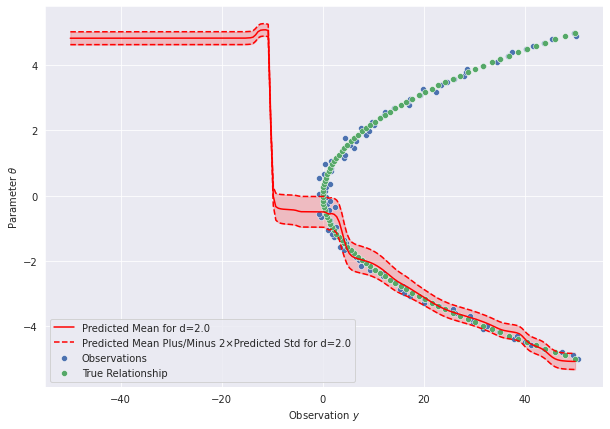

In [33]:
d_idx = 10
plot_phi_function(amortised_dist, d_idx, d=d, y_obs=y, model=model_func)

<AxesSubplot:>

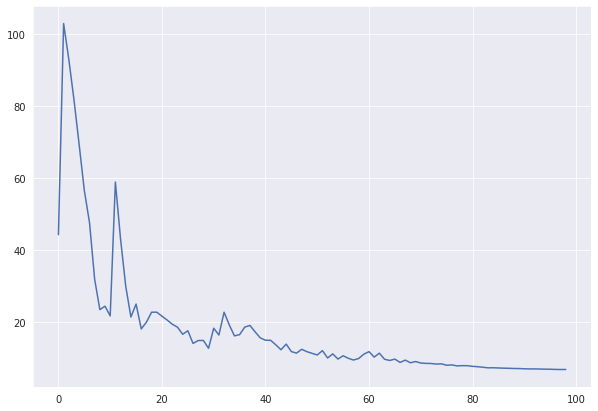

In [34]:
sns.lineplot(x=jnp.arange(len(loss)), y=jnp.array(loss))

Try Forward KL divergence:

In [35]:
model, model_grad = approx_post.models.from_jax(model_func)
joint_dist = approx_post.distributions.joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)
prngkey = jax.random.PRNGKey(10)
approx_dist = approx_post.distributions.approx.Gaussian(1)
preprocessing = approx_post.distributions.amortised.Preprocessing.std_scaling(y, d) #,d
phi_lims = None 
amortised_dist = approx_post.distributions.amortised.NeuralNetwork(approx_dist, x_dim=1, d_dim=1, prngkey=prngkey, 
                                                                   num_layers=5, width=10, activation='tanh', 
                                                                   preprocessing=preprocessing, phi_lims=phi_lims)

In [36]:
loss = approx_post.losses.ForwardKL(joint_dist, use_reparameterisation=False)
optimiser = approx_post.optimisers.Adam()
loss = optimiser.fit(amortised_dist, loss, x=y, d=d, prngkey=prngkey, verbose=True, num_samples=1000, max_iter=100) 

Loss = 0.003801035461947322, Params = Jaxtainer({'W_0': DeviceArray([[ 0.46915352, -0.09533954,  0.5206853 , -1.324442  ,
               1.9356848 ,  0.9552769 ,  1.5268283 ,  0.19877124,
               1.3546568 ,  0.524485  ],
             [-0.12585507,  1.313386  , -0.5257582 , -0.80462223,
               1.0409049 ,  0.786816  , -0.9069331 ,  0.31477904,
               1.8553184 , -1.6147579 ]], dtype=float32), 'b_0': DeviceArray([ 0.09998889, -0.0999874 ,  0.09998439, -0.09989959,
             -0.09957092, -0.09994835,  0.09991905, -0.09990074,
              0.09850197, -0.09999666], dtype=float32), 'W_1': DeviceArray([[ 0.01059286,  0.14724031, -0.49323595, -0.49129713,
               0.48611233, -0.6321362 , -0.52255535,  0.48790324,
               0.4694895 , -0.7133467 ],
             [-0.08138096, -0.879069  , -0.0407149 ,  0.66265273,
              -0.8305863 , -0.46639284,  0.02558669,  0.03062297,
               0.05232893,  0.5985756 ],
             [-0.24847399,  0.41079

Loss = 0.003505392000079155, Params = Jaxtainer({'W_0': DeviceArray([[ 0.5234674 , -0.16982819,  0.50987756, -1.3366486 ,
               2.0348952 ,  0.8634298 ,  1.5793217 ,  0.23341776,
               1.3399793 ,  0.43887004],
             [-0.13379773,  1.2371911 , -0.5824543 , -0.85586077,
               1.0569609 ,  0.7240713 , -0.8848135 ,  0.37035805,
               1.9372447 , -1.7064658 ]], dtype=float32), 'b_0': DeviceArray([ 0.18348   , -0.03082452,  0.19264822, -0.09108284,
             -0.03434131, -0.17231622,  0.10896719, -0.18202835,
              0.1914019 , -0.13145575], dtype=float32), 'W_1': DeviceArray([[-0.04762528,  0.23882931, -0.46155792, -0.54690385,
               0.4949426 , -0.69218063, -0.5988195 ,  0.42442203,
               0.5265467 , -0.81338704],
             [-0.14986435, -0.9314438 , -0.00376946,  0.614832  ,
              -0.8992085 , -0.54273266, -0.02758082, -0.03819776,
               0.10722893,  0.61214685],
             [-0.30673334,  0.50218

Loss = 0.003375082742422819, Params = Jaxtainer({'W_0': DeviceArray([[ 0.56275743, -0.22458246,  0.4928    , -1.3384665 ,
               2.1303544 ,  0.786278  ,  1.5956585 ,  0.27276778,
               1.3052771 ,  0.37997618],
             [-0.13646129,  1.1761835 , -0.6341097 , -0.92391926,
               1.0067738 ,  0.7203925 , -0.91796803,  0.42507067,
               1.955084  , -1.7726744 ]], dtype=float32), 'b_0': DeviceArray([ 0.21790901,  0.02913088,  0.26162088, -0.08717813,
              0.04538961, -0.25646916,  0.10641097, -0.22262809,
              0.28088862, -0.15483713], dtype=float32), 'W_1': DeviceArray([[-0.09330318,  0.29428017, -0.43468282, -0.58658624,
               0.5035652 , -0.7497934 , -0.6590538 ,  0.3747444 ,
               0.5695984 , -0.88322955],
             [-0.20209086, -0.9347062 ,  0.03358508,  0.5819699 ,
              -0.94519013, -0.58523315, -0.07141449, -0.09101106,
               0.15049104,  0.61292255],
             [-0.35228997,  0.55528

Loss = 0.003131415229290724, Params = Jaxtainer({'W_0': DeviceArray([[ 0.59314656, -0.27287394,  0.4600231 , -1.3238165 ,
               2.2197428 ,  0.71589094,  1.605458  ,  0.3145222 ,
               1.269634  ,  0.31910586],
             [-0.14588772,  1.1114781 , -0.6978    , -1.0043132 ,
               0.9555396 ,  0.71577734, -0.95828176,  0.4836167 ,
               1.9706206 , -1.8363086 ]], dtype=float32), 'b_0': DeviceArray([ 0.22531469,  0.08962727,  0.3323977 , -0.06934722,
              0.11596566, -0.34113353,  0.07872824, -0.26308486,
              0.35304704, -0.16489416], dtype=float32), 'W_1': DeviceArray([[-1.30285680e-01,  3.48528445e-01, -4.14130241e-01,
              -6.13798261e-01,  5.24428070e-01, -7.93560684e-01,
              -7.08546460e-01,  3.34184825e-01,  6.05148315e-01,
              -9.42468762e-01],
             [-2.44374901e-01, -9.34374511e-01,  6.82209283e-02,
               5.61087668e-01, -9.78236794e-01, -6.21054709e-01,
              -1.0825264

Loss = 0.002946767257526517, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6212377 , -0.31407797,  0.42909062, -1.3101127 ,
               2.2879927 ,  0.65943617,  1.621054  ,  0.35002318,
               1.2363703 ,  0.2632518 ],
             [-0.15008213,  1.0548313 , -0.7548687 , -1.0776974 ,
               0.91919225,  0.6969727 , -0.98628604,  0.532713  ,
               1.9917581 , -1.8921813 ]], dtype=float32), 'b_0': DeviceArray([ 0.21746197,  0.14250931,  0.39083436, -0.04606764,
              0.17860019, -0.42533633,  0.03688743, -0.2987558 ,
              0.40891147, -0.17154458], dtype=float32), 'W_1': DeviceArray([[-0.16150717,  0.3950514 , -0.39932907, -0.63633865,
               0.54419994, -0.82995063, -0.7502639 ,  0.29994506,
               0.6351843 , -0.9925045 ],
             [-0.2800046 , -0.9338733 ,  0.09953254,  0.5439446 ,
              -1.0071651 , -0.6517317 , -0.13943544, -0.17114778,
               0.21530393,  0.6115434 ],
             [-0.42101812,  0.64764

Loss = 0.0027788705192506313, Params = Jaxtainer({'W_0': DeviceArray([[ 0.64909786, -0.34957793,  0.4059563 , -1.3045167 ,
               2.3403254 ,  0.6172988 ,  1.6403857 ,  0.38008288,
               1.2197825 ,  0.21520871],
             [-0.14628886,  1.0061762 , -0.7997461 , -1.1398907 ,
               0.893895  ,  0.66856194, -1.0033185 ,  0.5733905 ,
               2.014551  , -1.9397932 ]], dtype=float32), 'b_0': DeviceArray([ 0.1990858 ,  0.18775198,  0.43122825, -0.01643104,
              0.23397313, -0.5093895 , -0.01357167, -0.3302369 ,
              0.4382194 , -0.17863262], dtype=float32), 'W_1': DeviceArray([[-0.1884267 ,  0.43487585, -0.38625902, -0.656829  ,
               0.5606923 , -0.8614729 , -0.7862884 ,  0.27044517,
               0.66106266, -1.0354462 ],
             [-0.31065315, -0.93344414,  0.12622184,  0.5286337 ,
              -1.0319057 , -0.678133  , -0.16628967, -0.20286225,
               0.24095121,  0.6099981 ],
             [-0.44819444,  0.6841

Loss = 0.0027879616245627403, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6765917 , -0.38054085,  0.39034182, -1.3056653 ,
               2.3826957 ,  0.5861748 ,  1.6618651 ,  0.40599778,
               1.2208098 ,  0.17431885],
             [-0.13609973,  0.9639779 , -0.83408177, -1.1935158 ,
               0.87490857,  0.636021  , -1.01175   ,  0.6076242 ,
               2.0367625 , -1.9805573 ]], dtype=float32), 'b_0': DeviceArray([ 0.17441493,  0.226826  ,  0.45718333,  0.01838461,
              0.28215945, -0.5911954 , -0.07064556, -0.35898495,
              0.44386408, -0.18636538], dtype=float32), 'W_1': DeviceArray([[-0.21194091,  0.46946728, -0.37386492, -0.6759123 ,
               0.5746065 , -0.8892461 , -0.817835  ,  0.24470238,
               0.6836708 , -1.072819  ],
             [-0.3373441 , -0.9329861 ,  0.14867887,  0.5150073 ,
              -1.0532871 , -0.70107657, -0.1897151 , -0.23060949,
               0.26335657,  0.60820186],
             [-0.47194383,  0.7159

Loss = 0.0028060218319296837, Params = Jaxtainer({'W_0': DeviceArray([[ 0.70339465, -0.4078124 ,  0.38058478, -1.311681  ,
               2.4189034 ,  0.5632453 ,  1.6850811 ,  0.4286933 ,
               1.2344555 ,  0.13932005],
             [-0.1219864 ,  0.9269668 , -0.8601729 , -1.2387521 ,
               0.859045  ,  0.6022308 , -1.0118287 ,  0.6363608 ,
               2.0578356 , -2.0158343 ]], dtype=float32), 'b_0': DeviceArray([ 0.1456958 ,  0.26097283,  0.47283733,  0.05730315,
              0.3235258 , -0.6691544 , -0.13250507, -0.38594294,
              0.43288198, -0.19430496], dtype=float32), 'W_1': DeviceArray([[-0.2326833 ,  0.49990064, -0.3621166 , -0.69382846,
               0.58665955, -0.9139418 , -0.8457141 ,  0.2220347 ,
               0.70362324, -1.1056685 ],
             [-0.36080652, -0.9324789 ,  0.16775669,  0.5029638 ,
              -1.0722014 , -0.7211913 , -0.21033335, -0.2551181 ,
               0.28309935,  0.60632384],
             [-0.49288148,  0.7439

Loss = 0.002787639619782567, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7293515 , -0.43201077,  0.3752971 , -1.3208658 ,
               2.4516168 ,  0.5464418 ,  1.709635  ,  0.44884503,
               1.2556154 ,  0.10978269],
             [-0.10515897,  0.8942498 , -0.87953573, -1.2756097 ,
               0.8440204 ,  0.5693121 , -1.0039054 ,  0.6602929 ,
               2.0777674 , -2.0465357 ]], dtype=float32), 'b_0': DeviceArray([ 0.11424184,  0.2910581 ,  0.48107007,  0.0989576 ,
              0.35867482, -0.7419234 , -0.19750446, -0.4114681 ,
              0.4115498 , -0.20219778], dtype=float32), 'W_1': DeviceArray([[-0.2511248 ,  0.52692187, -0.35091716, -0.71078616,
               0.59729147, -0.9360503 , -0.8705186 ,  0.20193845,
               0.72136825, -1.1347528 ],
             [-0.38158464, -0.9319365 ,  0.18402341,  0.49234077,
              -1.089212  , -0.7389532 , -0.22860739, -0.27691728,
               0.3006062 ,  0.6044739 ],
             [-0.51145256,  0.76877

Loss = 0.0027193110436201096, Params = Jaxtainer({'W_0': DeviceArray([[ 0.75433874, -0.45360655,  0.3732016 , -1.3312969 ,
               2.482773  ,  0.53409487,  1.7347834 ,  0.4669683 ,
               1.2795665 ,  0.08703537],
             [-0.08572584,  0.8651614 , -0.8934329 , -1.3056132 ,
               0.82822645,  0.5395554 , -0.9893906 ,  0.68006533,
               2.0968757 , -2.073111  ]], dtype=float32), 'b_0': DeviceArray([ 0.08130502,  0.31770247,  0.48418605,  0.14148504,
              0.38843328, -0.8078905 , -0.26434606, -0.4355111 ,
              0.38532022, -0.21008827], dtype=float32), 'W_1': DeviceArray([[-0.26762384,  0.55107474, -0.3401346 , -0.72691834,
               0.60683423, -0.9559405 , -0.89270014,  0.18402565,
               0.73724455, -1.1606524 ],
             [-0.40007478, -0.9313697 ,  0.19786474,  0.4829826 ,
              -1.1046904 , -0.75474113, -0.24490099, -0.29640713,
               0.31619886,  0.60269994],
             [-0.5280156 ,  0.7909

Loss = 0.00267694890499115, Params = Jaxtainer({'W_0': DeviceArray([[ 0.77813685, -0.47297156,  0.37298244, -1.3409293 ,
               2.5136752 ,  0.52453357,  1.75979   ,  0.48346153,
               1.3024411 ,  0.07353373],
             [-0.06373315,  0.83916044, -0.90325916, -1.3321    ,
               0.8109126 ,  0.5150838 , -0.96981317,  0.6963059 ,
               2.1160748 , -2.0957568 ]], dtype=float32), 'b_0': DeviceArray([ 0.04819242,  0.3413738 ,  0.4842737 ,  0.18285042,
              0.41353428, -0.86552465, -0.33242792, -0.45779777,
              0.35777295, -0.21826503], dtype=float32), 'W_1': DeviceArray([[-0.28246203,  0.572762  , -0.32954708, -0.74222505,
               0.6155504 , -0.97388715, -0.9126107 ,  0.16798379,
               0.75151527, -1.1838232 ],
             [-0.41657802, -0.9307944 ,  0.20942989,  0.4747259 ,
              -1.1188577 , -0.7688622 , -0.25950134, -0.31389356,
               0.33012977,  0.60101676],
             [-0.54286563,  0.810741

Loss = 0.0026814197190105915, Params = Jaxtainer({'W_0': DeviceArray([[ 0.80034906, -0.49040937,  0.3732412 , -1.3477596 ,
               2.5450237 ,  0.51641035,  1.7848003 ,  0.49864644,
               1.321239  ,  0.06931838],
             [-0.03974818,  0.8157538 , -0.91061544, -1.3605874 ,
               0.79226345,  0.4976753 , -0.9445025 ,  0.70974624,
               2.137313  , -2.1148686 ]], dtype=float32), 'b_0': DeviceArray([ 0.01648111,  0.36246568,  0.48358378,  0.2211658 ,
              0.43435892, -0.9131438 , -0.40327278, -0.47804952,
              0.33016655, -0.2267763 ], dtype=float32), 'W_1': DeviceArray([[-0.29586118,  0.59229475, -0.31879392, -0.7565433 ,
               0.6237182 , -0.99007374, -0.9305325 ,  0.15356138,
               0.7643926 , -1.2046297 ],
             [-0.43135834, -0.9302429 ,  0.21860084,  0.4673451 ,
              -1.1319704 , -0.78157717, -0.2726342 , -0.3296234 ,
               0.34260702,  0.5994301 ],
             [-0.55621654,  0.8285

Loss = 0.002606752095744014, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8204405 , -0.5061729 ,  0.37261826, -1.3498536 ,
               2.5766218 ,  0.5088961 ,  1.8103083 ,  0.5127415 ,
               1.3334211 ,  0.07379131],
             [-0.01541532,  0.794402  , -0.9171615 , -1.3969272 ,
               0.7729631 ,  0.48876435, -0.9129083 ,  0.72123796,
               2.1630704 , -2.1308863 ]], dtype=float32), 'b_0': DeviceArray([-0.01142483,  0.38138023,  0.48455593,  0.2552522 ,
              0.45122144, -0.94850427, -0.4785455 , -0.49596417,
              0.30009207, -0.23540525], dtype=float32), 'W_1': DeviceArray([[-0.30799145,  0.6099316 , -0.30777672, -0.76957756,
               0.631542  , -1.0046078 , -0.9466972 ,  0.14055955,
               0.77604926, -1.223371  ],
             [-0.44463897, -0.92974806,  0.22543398,  0.460599  ,
              -1.1442007 , -0.79310995, -0.28448418, -0.34380332,
               0.35379893,  0.59793663],
             [-0.5682362 ,  0.84474

Loss = 0.0025161593221127987, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8379502 , -0.5204685 ,  0.37003663, -1.3455985 ,
               2.607164  ,  0.5010792 ,  1.8354431 ,  0.5257896 ,
               1.3369793 ,  0.0850811 ],
             [ 0.00609459,  0.7745461 , -0.92431575, -1.4435196 ,
               0.7535095 ,  0.48842162, -0.8788946 ,  0.7314814 ,
               2.1937518 , -2.144422  ]], dtype=float32), 'b_0': DeviceArray([-0.03245132,  0.39858744,  0.48925123,  0.28364688,
              0.46518266, -0.9702797 , -0.5560566 , -0.51117074,
              0.26694223, -0.24373743], dtype=float32), 'W_1': DeviceArray([[-0.3189723 ,  0.6258858 , -0.29725838, -0.78104526,
               0.63915414, -1.0175617 , -0.9612976 ,  0.12881926,
               0.7866226 , -1.2402931 ],
             [-0.45659542, -0.929327  ,  0.23084113,  0.45433763,
              -1.1556895 , -0.8036461 , -0.2952049 , -0.3566098 ,
               0.36384556,  0.59652674],
             [-0.57909656,  0.8594

Loss = 0.0024288780987262726, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8527759 , -0.5334578 ,  0.36491328, -1.3343197 ,
               2.6351295 ,  0.49172133,  1.8597798 ,  0.53766984,
               1.3302261 ,  0.1001659 ],
             [ 0.02390513,  0.755918  , -0.9327953 , -1.4993781 ,
               0.73440766,  0.49557516, -0.8424513 ,  0.7409828 ,
               2.226622  , -2.1562288 ]], dtype=float32), 'b_0': DeviceArray([-0.04529949,  0.41447192,  0.49882922,  0.30367154,
              0.47803715, -0.97909635, -0.6347502 , -0.52364355,
              0.2414063 , -0.25102806], dtype=float32), 'W_1': DeviceArray([[-0.32891452,  0.640337  , -0.28834924, -0.7908276 ,
               0.64644027, -1.02903   , -0.9744973 ,  0.11820573,
               0.7962304 , -1.2555943 ],
             [-0.46740174, -0.92896765,  0.23607923,  0.4484636 ,
              -1.1663876 , -0.8133499 , -0.30492726, -0.36820292,
               0.37288043,  0.5951902 ],
             [-0.5889123 ,  0.8729

Loss = 0.002397353295236826, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8650768 , -0.545262  ,  0.3573543 , -1.3171957 ,
               2.6601524 ,  0.47957495,  1.8833697 ,  0.548168  ,
               1.3138449 ,  0.11646502],
             [ 0.03850475,  0.7385122 , -0.94260347, -1.5615631 ,
               0.7158071 ,  0.5086434 , -0.8024395 ,  0.7497604 ,
               2.259933  , -2.166877  ]], dtype=float32), 'b_0': DeviceArray([-0.05078358,  0.42933026,  0.5130339 ,  0.31538704,
              0.49036562, -0.9773234 , -0.71489763, -0.5341216 ,
              0.22980303, -0.2569188 ], dtype=float32), 'W_1': DeviceArray([[-0.33792633,  0.6534311 , -0.28142852, -0.79898757,
               0.6531656 , -1.0391562 , -0.98644024,  0.10860106,
               0.8049757 , -1.269434  ],
             [-0.4771885 , -0.9286558 ,  0.24166995,  0.44289532,
              -1.1762351 , -0.82233125, -0.3137631 , -0.37871775,
               0.38101268,  0.5939067 ],
             [-0.59778553,  0.88523

Loss = 0.0023917013313621283, Params = Jaxtainer({'W_0': DeviceArray([[ 0.87517446, -0.5559762 ,  0.3481606 , -1.2968385 ,
               2.6831818 ,  0.46417794,  1.9063121 ,  0.5571186 ,
               1.2900476 ,  0.13210185],
             [ 0.05055274,  0.722473  , -0.95317584, -1.6258565 ,
               0.69711834,  0.5259635 , -0.7583436 ,  0.75744313,
               2.2933621 , -2.176665  ]], dtype=float32), 'b_0': DeviceArray([-0.05075829,  0.44334707,  0.5304317 ,  0.32154644,
              0.50172174, -0.96804386, -0.79679894, -0.5439374 ,
              0.23044936, -0.26171863], dtype=float32), 'W_1': DeviceArray([[-0.34610853,  0.6652874 , -0.27595162, -0.8057571 ,
               0.6592073 , -1.0481273 , -0.9972554 ,  0.09990342,
               0.81294847, -1.2819443 ],
             [-0.486044  , -0.92838657,  0.24724148,  0.43756935,
              -1.1854146 , -0.8306384 , -0.3218083 , -0.3882714 ,
               0.3883311 ,  0.59265083],
             [-0.60581696,  0.8965

Loss = 0.0024021619465202093, Params = Jaxtainer({'W_0': DeviceArray([[ 0.88345784, -0.56569034,  0.33832082, -1.2759266 ,
               2.705384  ,  0.44603464,  1.9283783 ,  0.56450176,
               1.2612706 ,  0.14715874],
             [ 0.06058535,  0.7078969 , -0.9638911 , -1.6878709 ,
               0.6773502 ,  0.54591304, -0.7111433 ,  0.76362205,
               2.3268013 , -2.1855328 ]], dtype=float32), 'b_0': DeviceArray([-0.04723845,  0.45661345,  0.54934573,  0.32513136,
              0.5117382 , -0.9542277 , -0.87959784, -0.55435735,
              0.23968135, -0.26583484], dtype=float32), 'W_1': DeviceArray([[-0.35355136,  0.6760119 , -0.27109244, -0.8114417 ,
               0.664478  , -1.0561292 , -1.0070572 ,  0.09202522,
               0.8202269 , -1.2932416 ],
             [-0.4940319 , -0.92816085,  0.25215298,  0.43245217,
              -1.1940475 , -0.83829427, -0.32914534, -0.39696905,
               0.39490968,  0.5914039 ],
             [-0.6131099 ,  0.9068

Loss = 0.0024239022750407457, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8902589 , -0.57449234,  0.32862163, -1.2559999 ,
               2.7274258 ,  0.4258874 ,  1.9488904 ,  0.5703992 ,
               1.2292259 ,  0.16189171],
             [ 0.06880257,  0.6947871 , -0.9742888 , -1.7453628 ,
               0.6559254 ,  0.56711304, -0.66320187,  0.7681507 ,
               2.3606555 , -2.193475  ]], dtype=float32), 'b_0': DeviceArray([-0.04183196,  0.46918342,  0.5684915 ,  0.3280991 ,
              0.5201893 , -0.9381377 , -0.9617403 , -0.5661138 ,
              0.2536229 , -0.26952353], dtype=float32), 'W_1': DeviceArray([[-0.3603299 ,  0.6857082 , -0.2661761 , -0.81629837,
               0.66891944, -1.0633119 , -1.0159467 ,  0.08488957,
               0.8268782 , -1.3034381 ],
             [-0.5012115 , -0.92797655,  0.25589427,  0.4275659 ,
              -1.2021341 , -0.84532654, -0.33584473, -0.40490326,
               0.40081507,  0.59016395],
             [-0.61975664,  0.9163

Loss = 0.0024393307976424694, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8957931 , -0.58246773,  0.3192225 , -1.2371558 ,
               2.7495868 ,  0.40418348,  1.96726   ,  0.57491016,
               1.1937993 ,  0.1761424 ],
             [ 0.07498416,  0.68307865, -0.9843304 , -1.7983624 ,
               0.6325789 ,  0.58850235, -0.61623025,  0.7711102 ,
               2.395805  , -2.2005792 ]], dtype=float32), 'b_0': DeviceArray([-0.03558534,  0.4811032 ,  0.58744586,  0.33107328,
              0.5269279 , -0.9211249 , -1.0422654 , -0.5793956 ,
              0.270608  , -0.27277535], dtype=float32), 'W_1': DeviceArray([[-0.36649987,  0.6944764 , -0.26111814, -0.82043403,
               0.6726082 , -1.0697728 , -1.0240144 ,  0.07842981,
               0.83295685, -1.3126456 ],
             [-0.5076589 , -0.9278313 ,  0.2585353 ,  0.42291105,
              -1.209774  , -0.851785  , -0.34196544, -0.41215497,
               0.40611538,  0.588949  ],
             [-0.6258303 ,  0.9250

Loss = 0.00241892714984715, Params = Jaxtainer({'W_0': DeviceArray([[ 0.9001164 , -0.5896976 ,  0.3095444 , -1.2183597 ,
               2.7719727 ,  0.3808937 ,  1.9831212 ,  0.57809913,
               1.1527036 ,  0.18954825],
             [ 0.07818718,  0.6726487 , -0.99446666, -1.8479261 ,
               0.6068806 ,  0.609108  , -0.57124215,  0.7726344 ,
               2.4335694 , -2.207064  ]], dtype=float32), 'b_0': DeviceArray([-0.02890409,  0.4924428 ,  0.60668755,  0.3338612 ,
              0.5317751 , -0.9037916 , -1.1206559 , -0.59411025,
              0.29141647, -0.27532792], dtype=float32), 'W_1': DeviceArray([[-0.37209508,  0.7024105 , -0.2563672 , -0.8237622 ,
               0.67562395, -1.0755547 , -1.0313417 ,  0.07259027,
               0.83850384, -1.3209721 ],
             [-0.51346374, -0.9277235 ,  0.260663  ,  0.41841406,
              -1.2170249 , -0.85774493, -0.34755704, -0.41879606,
               0.4108806 ,  0.5877884 ],
             [-0.63139653,  0.932988

Loss = 0.0023985139559954405, Params = Jaxtainer({'W_0': DeviceArray([[ 0.90315807, -0.59625787,  0.2985051 , -1.1979599 ,
               2.7944508 ,  0.35560626,  1.996391  ,  0.58002275,
               1.1029978 ,  0.20072253],
             [ 0.07713778,  0.66332316, -1.0054401 , -1.895561  ,
               0.5786035 ,  0.62801254, -0.5289719 ,  0.7729038 ,
               2.474955  , -2.2134588 ]], dtype=float32), 'b_0': DeviceArray([-0.02154631,  0.5032913 ,  0.6272636 ,  0.33538374,
              0.5347339 , -0.8861619 , -1.1962614 , -0.6099057 ,
              0.3190876 , -0.27673167], dtype=float32), 'W_1': DeviceArray([[-0.37713793,  0.709597  , -0.2524958 , -0.8260672 ,
               0.67815816, -1.0806594 , -1.0380017 ,  0.06732124,
               0.8435518 , -1.3285159 ],
             [-0.5187197 , -0.9276499 ,  0.26295936,  0.41393116,
              -1.2240839 , -0.86330265, -0.3526626 , -0.4248887 ,
               0.41518006,  0.58670807],
             [-0.63651794,  0.9402

Loss = 0.0023763005156069994, Params = Jaxtainer({'W_0': DeviceArray([[ 0.90483093, -0.60221744,  0.28510666, -1.1743892 ,
               2.8167353 ,  0.3278079 ,  2.007251  ,  0.58076525,
               1.043094  ,  0.20873122],
             [ 0.07114908,  0.65492845, -1.0178186 , -1.9428996 ,
               0.54809326,  0.6445457 , -0.4896822 ,  0.7721455 ,
               2.5203507 , -2.220175  ]], dtype=float32), 'b_0': DeviceArray([-0.01310626,  0.5137203 ,  0.6501214 ,  0.33417657,
              0.5358574 , -0.86792284, -1.2685537 , -0.62628555,
              0.35624138, -0.2767161 ], dtype=float32), 'W_1': DeviceArray([[-3.81656885e-01,  7.16112554e-01, -2.49919698e-01,
              -8.27165306e-01,  6.80566311e-01, -1.08508158e+00,
              -1.04405868e+00,  6.25737011e-02,  8.48132193e-01,
              -1.33536255e+00],
             [-5.23508191e-01, -9.27604556e-01,  2.65933394e-01,
               4.09309089e-01, -1.23138487e+00, -8.68554533e-01,
              -3.573220

Loss = 0.0023393614683300257, Params = Jaxtainer({'W_0': DeviceArray([[ 0.90517086, -0.6076336 ,  0.26923996, -1.1469742 ,
               2.838594  ,  0.29723713,  2.0159492 ,  0.5804254 ,
               0.9733238 ,  0.21323994],
             [ 0.06088813,  0.64738774, -1.0315    , -1.9909179 ,
               0.5163195 ,  0.6583569 , -0.45286575,  0.7706076 ,
               2.56967   , -2.2273908 ]], dtype=float32), 'b_0': DeviceArray([-0.00371492,  0.5237465 ,  0.67533267,  0.32961404,
              0.5349327 , -0.84890014, -1.3377973 , -0.6429177 ,
              0.4024232 , -0.27533117], dtype=float32), 'W_1': DeviceArray([[-0.3856977 ,  0.72202057, -0.24850224, -0.8270965 ,
               0.68316   , -1.0888594 , -1.0495692 ,  0.05829754,
               0.8522792 , -1.3415824 ],
             [-0.52788526, -0.92758083,  0.26952714,  0.4044862 ,
              -1.2393253 , -0.8735579 , -0.3615737 , -0.43562296,
               0.4226228 ,  0.5848304 ],
             [-0.6456136 ,  0.9531

Loss = 0.002314966870471835, Params = Jaxtainer({'W_0': DeviceArray([[ 0.90442616, -0.6125482 ,  0.25276372, -1.1161615 ,
               2.860043  ,  0.26404458,  2.022607  ,  0.5790687 ,
               0.89501005,  0.21545471],
             [ 0.04826282,  0.6407723 , -1.0452266 , -2.0393522 ,
               0.4844614 ,  0.6694196 , -0.41746232,  0.7684667 ,
               2.6225367 , -2.2347128 ]], dtype=float32), 'b_0': DeviceArray([ 0.00567838,  0.53333795,  0.7015078 ,  0.3224248 ,
              0.53140116, -0.82943374, -1.4049578 , -0.6598444 ,
              0.45469654, -0.27309847], dtype=float32), 'W_1': DeviceArray([[-0.38932884,  0.7273697 , -0.24720077, -0.82633066,
               0.6862647 , -1.0921253 , -1.0545839 ,  0.054441  ,
               0.8560316 , -1.3472311 ],
             [-0.53187233, -0.9275723 ,  0.27272916,  0.3996982 ,
              -1.2484031 , -0.87828004, -0.36545375, -0.4403345 ,
               0.4258541 ,  0.5840238 ],
             [-0.64961654,  0.95870

Loss = 0.0022865335922688246, Params = Jaxtainer({'W_0': DeviceArray([[ 0.90278935, -0.61699194,  0.23933384, -1.0821992 ,
               2.8812838 ,  0.2277293 ,  2.0269694 ,  0.57657963,
               0.808567  ,  0.21703441],
             [ 0.03494433,  0.63520396, -1.0569432 , -2.0878768 ,
               0.45323518,  0.6779272 , -0.3816885 ,  0.7656613 ,
               2.679695  , -2.2415216 ]], dtype=float32), 'b_0': DeviceArray([ 0.01394057,  0.5425354 ,  0.7264753 ,  0.31388873,
              0.5239377 , -0.8097277 , -1.4719149 , -0.67761844,
              0.50933665, -0.27052513], dtype=float32), 'W_1': DeviceArray([[-0.39262304,  0.7321921 , -0.24495022, -0.8254941 ,
               0.6897713 , -1.0950484 , -1.0591464 ,  0.05095773,
               0.8594274 , -1.3523505 ],
             [-0.53546447, -0.9275741 ,  0.2744661 ,  0.39538485,
              -1.2585768 , -0.8826369 , -0.36899894, -0.4446405 ,
               0.42879266,  0.58328635],
             [-0.6532441 ,  0.9638

Loss = 0.002257157349959016, Params = Jaxtainer({'W_0': DeviceArray([[ 0.9000177 , -0.62099665,  0.23089635, -1.0438191 ,
               2.902233  ,  0.18539715,  2.0281901 ,  0.572622  ,
               0.7134237 ,  0.21749665],
             [ 0.0214329 ,  0.630689  , -1.065342  , -2.1372633 ,
               0.42319304,  0.68391705, -0.34182036,  0.76183707,
               2.742437  , -2.2478535 ]], dtype=float32), 'b_0': DeviceArray([ 0.0205937 ,  0.5515331 ,  0.74969065,  0.30484113,
              0.51016444, -0.7881586 , -1.5418587 , -0.6970924 ,
              0.56383574, -0.2672016 ], dtype=float32), 'W_1': DeviceArray([[-0.39563128,  0.7365045 , -0.24254122, -0.82488126,
               0.69311905, -1.0977073 , -1.0632926 ,  0.04781355,
               0.86249673, -1.3569684 ],
             [-0.5386572 , -0.9275835 ,  0.2756014 ,  0.39180234,
              -1.2692083 , -0.88661116, -0.37225106, -0.44856155,
               0.43145615,  0.5825941 ],
             [-0.6564933 ,  0.96854

Loss = 0.002247289987280965, Params = Jaxtainer({'W_0': DeviceArray([[ 0.89574075, -0.62459683,  0.22693558, -0.99988586,
               2.9212508 ,  0.13313846,  2.0241363 ,  0.5667941 ,
               0.6106228 ,  0.21390696],
             [ 0.00928947,  0.6272267 , -1.0696033 , -2.1879299 ,
               0.39726776,  0.6873074 , -0.289702  ,  0.756821  ,
               2.809837  , -2.254359  ]], dtype=float32), 'b_0': DeviceArray([ 0.02501092,  0.5605363 ,  0.77187055,  0.2957519 ,
              0.48766044, -0.76181567, -1.6197581 , -0.7189547 ,
              0.61889863, -0.26211113], dtype=float32), 'W_1': DeviceArray([[-0.39839354,  0.7403095 , -0.24250156, -0.82473403,
               0.695885  , -1.1001455 , -1.0670495 ,  0.04497771,
               0.86525136, -1.3610936 ],
             [-0.5414675 , -0.9275997 ,  0.27884433,  0.38913387,
              -1.2798997 , -0.8902101 , -0.37525737, -0.45211902,
               0.43390456,  0.5819009 ],
             [-0.6593429 ,  0.97288

Loss = 0.0022511458955705166, Params = Jaxtainer({'W_0': DeviceArray([[ 8.9009976e-01, -6.2781113e-01,  2.4190338e-01,
              -9.5417076e-01,  2.9356720e+00,  7.8155085e-02,
               2.0129259e+00,  5.5889833e-01,  5.0239235e-01,
               2.1100830e-01],
             [ 1.6001696e-03,  6.2497246e-01, -1.0636185e+00,
              -2.2374308e+00,  3.7864974e-01,  6.8915176e-01,
              -2.2338513e-01,  7.5136799e-01,  2.8798289e+00,
              -2.2589383e+00]], dtype=float32), 'b_0': DeviceArray([ 0.02541108,  0.5695486 ,  0.7845268 ,  0.28944954,
              0.45728144, -0.73544574, -1.7069719 , -0.7438339 ,
              0.6665664 , -0.25776225], dtype=float32), 'W_1': DeviceArray([[-0.40094033,  0.7436005 , -0.2423503 , -0.82558995,
               0.69793034, -1.1027508 , -1.070444  ,  0.04241246,
               0.8676688 , -1.3647126 ],
             [-0.5439358 , -0.92762715,  0.28148985,  0.38780922,
              -1.2906362 , -0.8930633 , -0.37805045, 

Loss = 0.0022698368411511183, Params = Jaxtainer({'W_0': DeviceArray([[ 0.88357925, -0.6306504 ,  0.2817799 , -0.91057086,
               2.9479015 ,  0.05112834,  1.9995173 ,  0.54883754,
               0.39714584,  0.21539575],
             [-0.00497111,  0.6236537 , -1.0440152 , -2.2832646 ,
               0.3619251 ,  0.6934523 , -0.15613674,  0.7455441 ,
               2.9504986 , -2.25941   ]], dtype=float32), 'b_0': DeviceArray([ 0.02313525,  0.57876354,  0.7802461 ,  0.28614146,
              0.4242375 , -0.71956646, -1.7944571 , -0.7717232 ,
              0.70065653, -0.25718117], dtype=float32), 'W_1': DeviceArray([[-0.4033092 ,  0.7463893 , -0.23820315, -0.8273723 ,
               0.6992378 , -1.1057594 , -1.0735098 ,  0.04007078,
               0.8698334 , -1.3678668 ],
             [-0.5460664 , -0.9276708 ,  0.27930993,  0.387649  ,
              -1.3014153 , -0.8949568 , -0.38063595, -0.45820937,
               0.438363  ,  0.5803528 ],
             [-0.6638466 ,  0.9805

Loss = 0.0022487251553684473, Params = Jaxtainer({'W_0': DeviceArray([[ 0.87583417, -0.63313806,  0.32729536, -0.8674154 ,
               2.956787  ,  0.02395588,  1.9842343 ,  0.53618383,
               0.2867546 ,  0.21482036],
             [-0.00996101,  0.62315184, -1.0186387 , -2.3273234 ,
               0.34750548,  0.69724584, -0.08788548,  0.7397758 ,
               3.0170298 , -2.260213  ]], dtype=float32), 'b_0': DeviceArray([ 0.01937508,  0.5884243 ,  0.7710782 ,  0.28083223,
              0.3917094 , -0.7048703 , -1.880954  , -0.8020146 ,
              0.74215317, -0.255802  ], dtype=float32), 'W_1': DeviceArray([[-0.40549716,  0.7486983 , -0.23576872, -0.82950884,
               0.69987947, -1.1087825 , -1.0762563 ,  0.03793237,
               0.87177044, -1.3705387 ],
             [-0.54793316, -0.9277094 ,  0.27851516,  0.38800347,
              -1.3123711 , -0.89636326, -0.3830497 , -0.4607996 ,
               0.4403319 ,  0.57945687],
             [-0.6656884 ,  0.9839

Loss = 0.002228416968137026, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8666978 , -0.6352878 ,  0.37554651, -0.82524675,
               2.9610603 ,  0.01852353,  1.9659123 ,  0.52067596,
               0.17343706,  0.2117373 ],
             [-0.01065579,  0.6234775 , -0.9897274 , -2.3724048 ,
               0.33635405,  0.7023876 , -0.01649658,  0.73452085,
               3.084488  , -2.2610183 ]], dtype=float32), 'b_0': DeviceArray([ 0.01276673,  0.5985586 ,  0.7582971 ,  0.2727874 ,
              0.36092982, -0.6943961 , -1.9682581 , -0.8350348 ,
              0.7855049 , -0.25420249], dtype=float32), 'W_1': DeviceArray([[-0.40750954,  0.7505469 , -0.233579  , -0.83173865,
               0.69982296, -1.1117224 , -1.0786842 ,  0.03596711,
               0.87346834, -1.3726496 ],
             [-0.54958683, -0.92770696,  0.27753472,  0.38854873,
              -1.3234092 , -0.89743155, -0.38532585, -0.46313056,
               0.44218907,  0.5783563 ],
             [-0.66732055,  0.98690

Loss = 0.0022268376778811216, Params = Jaxtainer({'W_0': DeviceArray([[ 0.85606736, -0.6371117 ,  0.4248113 , -0.7858418 ,
               2.9614224 ,  0.04778092,  1.9415051 ,  0.5020488 ,
               0.07196478,  0.21237278],
             [-0.00520129,  0.62475026, -0.95900387, -2.4173856 ,
               0.3280201 ,  0.7111439 ,  0.06203594,  0.7297575 ,
               3.1517363 , -2.2602437 ]], dtype=float32), 'b_0': DeviceArray([ 0.0025354 ,  0.60917825,  0.742677  ,  0.2611758 ,
              0.33250493, -0.69505   , -2.0591164 , -0.8711567 ,
              0.8266274 , -0.2537045 ], dtype=float32), 'W_1': DeviceArray([[-0.40934464,  0.7519627 , -0.2285844 , -0.83394974,
               0.6985248 , -1.1145439 , -1.0808005 ,  0.03414468,
               0.8749067 , -1.3741099 ],
             [-0.55108285, -0.92763203,  0.2730882 ,  0.38915265,
              -1.3336937 , -0.8982372 , -0.3874976 , -0.46521917,
               0.44401163,  0.5769212 ],
             [-0.66874695,  0.9894

Loss = 0.0021915000397711992, Params = Jaxtainer({'W_0': DeviceArray([[ 8.4385526e-01, -6.3864160e-01,  4.6469554e-01,
              -7.4413049e-01,  2.9602447e+00,  3.8195893e-02,
               1.9174153e+00,  4.7987574e-01, -3.1771615e-02,
               2.0746098e-01],
             [-5.2262377e-04,  6.2675703e-01, -9.3301326e-01,
              -2.4624879e+00,  3.2047608e-01,  7.1060503e-01,
               1.3746703e-01,  7.2449464e-01,  3.1973157e+00,
              -2.2615345e+00]], dtype=float32), 'b_0': DeviceArray([-0.00735978,  0.6205631 ,  0.7354072 ,  0.24203983,
              0.30701196, -0.68875426, -2.1458206 , -0.90982676,
              0.8948723 , -0.2496142 ], dtype=float32), 'W_1': DeviceArray([[-0.41103673,  0.75302035, -0.22850394, -0.83587277,
               0.69485486, -1.1168362 , -1.0826474 ,  0.03244423,
               0.87620777, -1.3751014 ],
             [-0.55241376, -0.9275009 ,  0.27360502,  0.3896111 ,
              -1.3414218 , -0.89926416, -0.3895496 , 

Loss = 0.0021644197404384613, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8308969 , -0.6398807 ,  0.49907583, -0.70448166,
               2.9587991 ,  0.01673751,  1.8954109 ,  0.45430505,
              -0.12499123,  0.202278  ],
             [ 0.00369298,  0.62951833, -0.91000175, -2.5052538 ,
               0.31347775,  0.7052213 ,  0.20852125,  0.718233  ,
               3.2355938 , -2.263088  ]], dtype=float32), 'b_0': DeviceArray([-0.01741802,  0.6325539 ,  0.7316978 ,  0.2186545 ,
              0.28378296, -0.68583727, -2.226293  , -0.9509783 ,
              0.9690448 , -0.24459168], dtype=float32), 'W_1': DeviceArray([[-0.41260833,  0.7537808 , -0.22934687, -0.83756334,
               0.68923044, -1.1188064 , -1.0842562 ,  0.03083138,
               0.8774166 , -1.3756627 ],
             [-0.5535902 , -0.9272902 ,  0.27479947,  0.38998166,
              -1.3469977 , -0.90031624, -0.39148661, -0.46870616,
               0.44720173,  0.57360584],
             [-0.6712495 ,  0.9934

Loss = 0.002156873233616352, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8180407 , -0.6408661 ,  0.5300764 , -0.6682945 ,
               2.957646  ,  0.03363709,  1.8757056 ,  0.42628253,
              -0.08515669,  0.20082684],
             [ 0.00818353,  0.63288534, -0.88887066, -2.5461159 ,
               0.30710477,  0.7021004 ,  0.27434784,  0.71132475,
               3.3008718 , -2.2635648 ]], dtype=float32), 'b_0': DeviceArray([-0.02828187,  0.64461195,  0.72838485,  0.19542903,
              0.26199996, -0.69344807, -2.3004947 , -0.99338615,
              1.0010998 , -0.24097331], dtype=float32), 'W_1': DeviceArray([[-0.41407588,  0.7543094 , -0.227953  , -0.83909863,
               0.6830126 , -1.120657  , -1.0856544 ,  0.0292839 ,
               0.87849355, -1.3757819 ],
             [-0.5546154 , -0.9269923 ,  0.27333117,  0.39034733,
              -1.3518138 , -0.9011999 , -0.39331114, -0.4701023 ,
               0.44860387,  0.5716911 ],
             [-0.6723767 ,  0.99503

Loss = 0.002142013283446431, Params = Jaxtainer({'W_0': DeviceArray([[ 0.8044917 , -0.64167374,  0.55149686, -0.6271681 ,
               2.9569428 ,  0.02783393,  1.8565208 ,  0.39671496,
              -0.07134324,  0.19022156],
             [ 0.01428729,  0.63636804, -0.87483764, -2.583789  ,
               0.3017483 ,  0.685953  ,  0.3372829 ,  0.70404226,
               3.331954  , -2.267145  ]], dtype=float32), 'b_0': DeviceArray([-0.0389952 ,  0.65666795,  0.73489475,  0.16856913,
              0.24024998, -0.6851394 , -2.3702855 , -1.0346619 ,
              1.0580543 , -0.23383407], dtype=float32), 'W_1': DeviceArray([[-0.41544968,  0.75462884, -0.23363498, -0.8403266 ,
               0.6769588 , -1.1218957 , -1.0868344 ,  0.02781115,
               0.8795492 , -1.3755072 ],
             [-0.5554986 , -0.9265766 ,  0.27933615,  0.39061815,
              -1.3565118 , -0.90247476, -0.3950782 , -0.47130185,
               0.4498067 ,  0.5695667 ],
             [-0.6734586 ,  0.99624

Loss = 0.002126279752701521, Params = Jaxtainer({'W_0': DeviceArray([[ 0.79154485, -0.6423287 ,  0.56939846, -0.587875  ,
               2.9569895 ,  0.04893301,  1.8396164 ,  0.36921847,
              -0.04932472,  0.17869225],
             [ 0.02442788,  0.6403379 , -0.862897  , -2.6197143 ,
               0.29771426,  0.667249  ,  0.39559957,  0.69715303,
               3.369227  , -2.2708228 ]], dtype=float32), 'b_0': DeviceArray([-0.05251601,  0.66798955,  0.7418352 ,  0.14710847,
              0.21709093, -0.67664987, -2.435043  , -1.0724506 ,
              1.0919886 , -0.2279721 ], dtype=float32), 'W_1': DeviceArray([[-0.4167374 ,  0.75476503, -0.23948623, -0.84151536,
               0.6726929 , -1.1229746 , -1.0878187 ,  0.02640089,
               0.8805313 , -1.3749192 ],
             [-0.5562517 , -0.9260518 ,  0.28545156,  0.39100587,
              -1.3631761 , -0.9036823 , -0.396789  , -0.47230923,
               0.4508504 ,  0.56731063],
             [-0.6744784 ,  0.99716

Loss = 0.002138544572517276, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7810804 , -0.64284486,  0.58606154, -0.5514563 ,
               2.957714  ,  0.08149656,  1.834053  ,  0.34460708,
              -0.01096991,  0.17719147],
             [ 0.02864235,  0.6451814 , -0.85150796, -2.6560585 ,
               0.29500705,  0.6435667 ,  0.43991077,  0.6891951 ,
               3.4235206 , -2.2715034 ]], dtype=float32), 'b_0': DeviceArray([-0.06502862,  0.6783901 ,  0.74644464,  0.13438879,
              0.1916597 , -0.6783848 , -2.4880195 , -1.1061131 ,
              1.0857167 , -0.22614668], dtype=float32), 'W_1': DeviceArray([[-0.4178624 ,  0.7548959 , -0.24081543, -0.84268886,
               0.6690471 , -1.1240729 , -1.0887518 ,  0.02504723,
               0.88144296, -1.3745984 ],
             [-0.5569876 , -0.9256068 ,  0.28661716,  0.39152354,
              -1.3700031 , -0.9046444 , -0.3982854 , -0.47313356,
               0.45171702,  0.5655531 ],
             [-0.6752997 ,  0.99805

Loss = 0.0021443108562380075, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7705842 , -0.6432185 ,  0.59444386, -0.5050664 ,
               2.9586637 ,  0.07486067,  1.833822  ,  0.31742278,
               0.00662728,  0.16325885],
             [ 0.03027781,  0.6505328 , -0.8470063 , -2.69035   ,
               0.29283434,  0.60189056,  0.47762743,  0.67813164,
               3.4565225 , -2.2762063 ]], dtype=float32), 'b_0': DeviceArray([-0.07532977,  0.68873155,  0.7603041 ,  0.11957926,
              0.16570076, -0.6699268 , -2.5342097 , -1.1383052 ,
              1.1014144 , -0.21946166], dtype=float32), 'W_1': DeviceArray([[-0.4189336 ,  0.7549147 , -0.25208303, -0.84363925,
               0.6639823 , -1.1246251 , -1.0895342 ,  0.02377102,
               0.8823653 , -1.3740368 ],
             [-0.55759186, -0.92511034,  0.29836497,  0.39201635,
              -1.3742087 , -0.9059852 , -0.3997189 , -0.47382584,
               0.4523866 ,  0.563702  ],
             [-0.6760732 ,  0.9987

Loss = 0.002126488136127591, Params = Jaxtainer({'W_0': DeviceArray([[ 0.76060534, -0.64361   ,  0.60103977, -0.45376763,
               2.9597876 ,  0.10610539,  1.8382645 ,  0.32303262,
               0.02324036,  0.15307638],
             [ 0.03336182,  0.6555111 , -0.84378946, -2.7220273 ,
               0.29102772,  0.5648866 ,  0.50974345,  0.67331463,
               3.4886377 , -2.2794323 ]], dtype=float32), 'b_0': DeviceArray([-0.08532909,  0.69784945,  0.7741617 ,  0.10831393,
              0.14001943, -0.6359042 , -2.5734513 , -1.147826  ,
              1.1076595 , -0.21586871], dtype=float32), 'W_1': DeviceArray([[-0.42000252,  0.75481725, -0.2593654 , -0.84442234,
               0.66639054, -1.1250979 , -1.0901817 ,  0.02258488,
               0.8832867 , -1.3730364 ],
             [-0.5580217 , -0.9245399 ,  0.30590534,  0.39246425,
              -1.3885045 , -0.9072245 , -0.40110353, -0.4744219 ,
               0.45289877,  0.5615208 ],
             [-0.6768777 ,  0.99930

Loss = 0.002119887387380004, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7505423 , -0.643825  ,  0.6063387 , -0.40284726,
               2.9612222 ,  0.11934277,  1.8393525 ,  0.322647  ,
               0.04164232,  0.15893973],
             [ 0.03585476,  0.6612212 , -0.8416884 , -2.7510712 ,
               0.28796327,  0.51840925,  0.5430861 ,  0.66366297,
               3.5199554 , -2.2785325 ]], dtype=float32), 'b_0': DeviceArray([-0.09468085,  0.7069479 ,  0.78775823,  0.09767524,
              0.11545415, -0.61733836, -2.611595  , -1.15973   ,
              1.1096487 , -0.2154048 ], dtype=float32), 'W_1': DeviceArray([[-0.42103657,  0.7545884 , -0.26291546, -0.8449887 ,
               0.6659714 , -1.1255453 , -1.090691  ,  0.02148147,
               0.8841596 , -1.3714694 ],
             [-0.5583271 , -0.923883  ,  0.30925125,  0.39280087,
              -1.3982493 , -0.90831536, -0.40244895, -0.47493252,
               0.45333502,  0.55890834],
             [-0.6776726 ,  0.99965

Loss = 0.002106487052515149, Params = Jaxtainer({'W_0': DeviceArray([[ 0.74054503, -0.64392215,  0.6072208 , -0.34210768,
               2.9624512 ,  0.10875691,  1.8328253 ,  0.31949726,
               0.04755376,  0.15402506],
             [ 0.03563681,  0.667352  , -0.84301156, -2.776235  ,
               0.28495798,  0.45845336,  0.5807607 ,  0.6508592 ,
               3.5377715 , -2.280822  ]], dtype=float32), 'b_0': DeviceArray([-0.10157761,  0.71591765,  0.8056353 ,  0.08411864,
              0.09285244, -0.59710276, -2.651346  , -1.1711614 ,
              1.1289212 , -0.21102932], dtype=float32), 'W_1': DeviceArray([[-0.42199066,  0.7543124 , -0.27407917, -0.8453147 ,
               0.6637595 , -1.1257325 , -1.0911078 ,  0.02046741,
               0.88495934, -1.3695546 ],
             [-0.55857974, -0.9232165 ,  0.32068026,  0.39301956,
              -1.4048905 , -0.9095245 , -0.4037177 , -0.47538325,
               0.45374632,  0.5560709 ],
             [-0.67839396,  0.99993

Loss = 0.0022372042294591665, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7318258 , -0.64415807,  0.6085561 , -0.27267468,
               2.9632993 ,  0.15722565,  1.8271502 ,  0.35221413,
               0.05679577,  0.16541141],
             [ 0.03324723,  0.67238456, -0.8439367 , -2.798608  ,
               0.28316632,  0.438461  ,  0.614866  ,  0.6514511 ,
               3.5579605 , -2.277538  ]], dtype=float32), 'b_0': DeviceArray([-0.10609224,  0.7232654 ,  0.8214189 ,  0.07613279,
              0.07249764, -0.5405517 , -2.687711  , -1.1573414 ,
              1.1379433 , -0.21091884], dtype=float32), 'W_1': DeviceArray([[-0.42285198,  0.7540862 , -0.27059388, -0.845464  ,
               0.6804089 , -1.1259809 , -1.0915093 ,  0.0195434 ,
               0.88567275, -1.367594  ],
             [-0.55881274, -0.922633  ,  0.31657258,  0.3931315 ,
              -1.4372951 , -0.9105218 , -0.40484425, -0.47579163,
               0.45415094,  0.55328953],
             [-0.679027  ,  1.0002

Loss = 0.0022310956846922636, Params = Jaxtainer({'W_0': DeviceArray([[ 0.72195894, -0.644056  ,  0.6042788 , -0.2019895 ,
               2.963756  ,  0.18676227,  1.814078  ,  0.3694292 ,
               0.05088497,  0.16037579],
             [ 0.02424765,  0.67909765, -0.84936345, -2.8165047 ,
               0.2806829 ,  0.40128595,  0.65180266,  0.64112604,
               3.5633266 , -2.2795625 ]], dtype=float32), 'b_0': DeviceArray([-0.11004693,  0.73287207,  0.84283537,  0.05293342,
              0.05324413, -0.49262884, -2.7258987 , -1.1595509 ,
              1.1671923 , -0.20473641], dtype=float32), 'W_1': DeviceArray([[-0.4236093 ,  0.7538474 , -0.27763045, -0.84541136,
               0.69207764, -1.1258926 , -1.0918514 ,  0.01875443,
               0.8862985 , -1.3658309 ],
             [-0.55901873, -0.9221338 ,  0.323278  ,  0.39313382,
              -1.4649968 , -0.9117552 , -0.40586326, -0.4761927 ,
               0.45453724,  0.55081266],
             [-0.6795527 ,  1.0005

Loss = 0.002243739552795887, Params = Jaxtainer({'W_0': DeviceArray([[ 0.70887387, -0.6436951 ,  0.5982027 , -0.13441488,
               2.9632201 ,  0.20789301,  1.791521  ,  0.37704363,
               0.04014153,  0.15668193],
             [ 0.00685299,  0.68768775, -0.85722595, -2.833894  ,
               0.27648547,  0.350091  ,  0.6943805 ,  0.6142101 ,
               3.5702834 , -2.2813022 ]], dtype=float32), 'b_0': DeviceArray([-0.12203655,  0.7449388 ,  0.8620372 ,  0.02805173,
              0.03378484, -0.46544948, -2.7662435 , -1.1782376 ,
              1.1887032 , -0.19848096], dtype=float32), 'W_1': DeviceArray([[-0.42436507,  0.7529831 , -0.2852882 , -0.8453852 ,
               0.70030516, -1.1257588 , -1.0920264 ,  0.01813524,
               0.88689876, -1.3640531 ],
             [-0.55915946, -0.9221437 ,  0.32986987,  0.39288592,
              -1.4919759 , -0.912928  , -0.4067531 , -0.47658476,
               0.45483097,  0.54850554],
             [-0.6801118 ,  1.00039

Loss = 0.0023007341660559177, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6908166 , -0.64327246,  0.59534794, -0.11519101,
               2.9603035 ,  0.22774744,  1.7593902 ,  0.3796969 ,
               0.04737314,  0.18904914],
             [-0.01978651,  0.6963594 , -0.86609995, -2.8587236 ,
               0.26918697,  0.28782007,  0.74298376,  0.56653893,
               3.5991468 , -2.2713487 ]], dtype=float32), 'b_0': DeviceArray([-0.1515693 ,  0.75796425,  0.86836594,  0.03582697,
              0.01254013, -0.47650257, -2.8080528 , -1.2126292 ,
              1.1699321 , -0.2043388 ], dtype=float32), 'W_1': DeviceArray([[-0.4253263 ,  0.7504895 , -0.27709132, -0.84575105,
               0.7067408 , -1.1259854 , -1.0918605 ,  0.01762219,
               0.88766575, -1.3614807 ],
             [-0.559208  , -0.92380536,  0.3186624 ,  0.39198893,
              -1.518347  , -0.91360724, -0.40737262, -0.47688946,
               0.4548339 ,  0.5457308 ],
             [-0.6809928 ,  0.9989

Loss = 0.0023322158958762884, Params = Jaxtainer({'W_0': DeviceArray([[ 0.66792554, -0.64292455,  0.5863232 , -0.0583283 ,
               2.9547582 ,  0.23627666,  1.71942   ,  0.37884036,
               0.04254941,  0.21000487],
             [-0.05312115,  0.70339876, -0.8823032 , -2.8707616 ,
               0.25664476,  0.21481293,  0.7924894 ,  0.50417286,
               3.6267908 , -2.2661705 ]], dtype=float32), 'b_0': DeviceArray([-0.19763583,  0.7707977 ,  0.8742689 ,  0.05435923,
             -0.01194181, -0.50723076, -2.8530116 , -1.2581826 ,
              1.1512153 , -0.20697637], dtype=float32), 'W_1': DeviceArray([[-0.42654562,  0.7466773 , -0.27635464, -0.8465501 ,
               0.71153116, -1.1259602 , -1.0913223 ,  0.01717276,
               0.88872814, -1.3578799 ],
             [-0.5590714 , -0.92704856,  0.31504232,  0.39057454,
              -1.5414361 , -0.9144801 , -0.40766975, -0.47706616,
               0.45439202,  0.54226416],
             [-0.6822766 ,  0.9963

Loss = 0.0022544271778315306, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6404657 , -0.6425892 ,  0.56872416,  0.02538332,
               2.9468927 ,  0.2325356 ,  1.6730571 ,  0.3728173 ,
               0.02557801,  0.22172897],
             [-0.09463513,  0.7095533 , -0.908288  , -2.86349   ,
               0.24012345,  0.13197738,  0.8348082 ,  0.42999518,
               3.643662  , -2.2652726 ]], dtype=float32), 'b_0': DeviceArray([-0.25380385,  0.78388524,  0.88492   ,  0.07278268,
             -0.03798752, -0.5475909 , -2.9031293 , -1.3132207 ,
              1.1430161 , -0.20628236], dtype=float32), 'W_1': DeviceArray([[-0.42792386,  0.7419466 , -0.28235012, -0.8476589 ,
               0.71545744, -1.1254225 , -1.0905228 ,  0.01679276,
               0.89005494, -1.3538713 ],
             [-0.55867314, -0.93148243,  0.31830984,  0.38902467,
              -1.5627506 , -0.91585976, -0.40769893, -0.47713575,
               0.4535183 ,  0.5384907 ],
             [-0.6838153 ,  0.9927

Loss = 0.00217304821126163, Params = Jaxtainer({'W_0': DeviceArray([[ 0.60993576, -0.6421618 ,  0.54916066,  0.11548851,
               2.9380298 ,  0.22092578,  1.6146953 ,  0.36056763,
               0.00769234,  0.22960399],
             [-0.13535245,  0.7156063 , -0.936049  , -2.8526955 ,
               0.22368948,  0.05481312,  0.8709296 ,  0.34955552,
               3.669471  , -2.2658215 ]], dtype=float32), 'b_0': DeviceArray([-0.31930944,  0.79720587,  0.88965416,  0.10677662,
             -0.06253646, -0.60175085, -2.9623525 , -1.3752534 ,
              1.1142867 , -0.20631956], dtype=float32), 'W_1': DeviceArray([[-0.42943236,  0.7365513 , -0.2904158 , -0.8494106 ,
               0.71829116, -1.1249197 , -1.0895293 ,  0.01645956,
               0.8916251 , -1.3492953 ],
             [-0.55794984, -0.9366509 ,  0.3235365 ,  0.3880771 ,
              -1.5819772 , -0.9171602 , -0.40765208, -0.47711846,
               0.45223895,  0.5341613 ],
             [-0.6855627 ,  0.988421

Loss = 0.002235970227047801, Params = Jaxtainer({'W_0': DeviceArray([[ 0.5819074 , -0.64162683,  0.5379071 ,  0.05548421,
               2.9291444 ,  0.21192391,  1.5528404 ,  0.3454122 ,
               0.013626  ,  0.24354568],
             [-0.16679925,  0.72167766, -0.95369816, -2.9088283 ,
               0.2062756 ,  0.007273  ,  0.8993777 ,  0.27088305,
               3.7229192 , -2.2627945 ]], dtype=float32), 'b_0': DeviceArray([-0.39125395,  0.8099182 ,  0.8778941 ,  0.18082708,
             -0.08534264, -0.6699573 , -3.024792  , -1.438164  ,
              1.0485337 , -0.21352996], dtype=float32), 'W_1': DeviceArray([[-0.43106583,  0.7311677 , -0.29221785, -0.8525251 ,
               0.7202843 , -1.1252091 , -1.0884688 ,  0.01612978,
               0.8934016 , -1.3443979 ],
             [-0.5568801 , -0.9415898 ,  0.3221829 ,  0.38883448,
              -1.5990674 , -0.9175139 , -0.4076192 , -0.47702157,
               0.45060146,  0.5294321 ],
             [-0.68742913,  0.98388

Loss = 0.002188054844737053, Params = Jaxtainer({'W_0': DeviceArray([[ 5.5595386e-01, -6.4104003e-01,  5.2804655e-01,
              -8.0884993e-04,  2.9195995e+00,  2.0220841e-01,
               1.4855475e+00,  3.2836056e-01,  2.1639869e-02,
               2.5632370e-01],
             [-1.8759696e-01,  7.2795081e-01, -9.6473485e-01,
              -2.9632933e+00,  1.9181691e-01, -1.8070091e-02,
               9.2347139e-01,  1.9727418e-01,  3.7833810e+00,
              -2.2596889e+00]], dtype=float32), 'b_0': DeviceArray([-0.4632642 ,  0.8218472 ,  0.86392254,  0.25647557,
             -0.10426627, -0.7382475 , -3.0902467 , -1.498784  ,
              0.97378534, -0.22186002], dtype=float32), 'W_1': DeviceArray([[-0.43270338,  0.72602034, -0.29379696, -0.8565481 ,
               0.721774  , -1.1256474 , -1.0874158 ,  0.01585437,
               0.8951694 , -1.339521  ],
             [-0.55564   , -0.9460871 ,  0.32087848,  0.39078975,
              -1.6145196 , -0.91768277, -0.4076273 , -

Loss = 0.002173743210732937, Params = Jaxtainer({'W_0': DeviceArray([[ 0.528732  , -0.64047194,  0.5110413 , -0.04749134,
               2.9072556 ,  0.18579276,  1.415094  ,  0.30938733,
               0.01718961,  0.26311344],
             [-0.20863271,  0.7342494 , -0.9777218 , -3.0106983 ,
               0.17705563, -0.04251035,  0.93894625,  0.12693614,
               3.8255806 , -2.2597373 ]], dtype=float32), 'b_0': DeviceArray([-0.52775824,  0.8334329 ,  0.8647417 ,  0.30639178,
             -0.12076703, -0.7892109 , -3.1589417 , -1.5564867 ,
              0.92678446, -0.22509754], dtype=float32), 'W_1': DeviceArray([[-0.43427896,  0.7211845 , -0.29955554, -0.8605026 ,
               0.7228986 , -1.1253017 , -1.0863856 ,  0.01568416,
               0.8967631 , -1.3351039 ],
             [-0.5543249 , -0.95020765,  0.3244344 ,  0.39285073,
              -1.6286575 , -0.9187402 , -0.40765965, -0.4769603 ,
               0.44739914,  0.52031386],
             [-0.6908722 ,  0.97521

Loss = 0.002166865859180689, Params = Jaxtainer({'W_0': DeviceArray([[ 4.9768049e-01, -6.3990772e-01,  4.8603898e-01,
              -8.5237265e-02,  2.8914263e+00,  1.6098624e-01,
               1.3430820e+00,  2.8773373e-01, -4.5522302e-04,
               2.6389432e-01],
             [-2.3614238e-01,  7.4053806e-01, -9.9459356e-01,
              -3.0526652e+00,  1.5936020e-01, -7.5190611e-02,
               9.4373339e-01,  5.8199950e-02,  3.8458276e+00,
              -2.2634184e+00]], dtype=float32), 'b_0': DeviceArray([-0.5835724 ,  0.84517026,  0.88209873,  0.33259025,
             -0.13910373, -0.82074285, -3.230623  , -1.6122149 ,
              0.9100628 , -0.22260594], dtype=float32), 'W_1': DeviceArray([[-4.3583086e-01,  7.1666574e-01, -3.0960965e-01,
              -8.6392814e-01,  7.2358048e-01, -1.1239617e+00,
              -1.0853550e+00,  1.5610213e-02,  8.9816380e-01,
              -1.3311052e+00],
             [-5.5291384e-01, -9.5395303e-01,  3.3295670e-01,
              

Loss = 0.00213169539347291, Params = Jaxtainer({'W_0': DeviceArray([[ 0.4630174 , -0.6392943 ,  0.4560517 , -0.11623276,
               2.87358   ,  0.1296027 ,  1.2704414 ,  0.26263756,
              -0.02726474,  0.2604999 ],
             [-0.26751724,  0.747299  , -1.0125582 , -3.091601  ,
               0.14108156, -0.11451404,  0.94194746, -0.0100052 ,
               3.8524415 , -2.2695346 ]], dtype=float32), 'b_0': DeviceArray([-0.63361484,  0.8569848 ,  0.90983886,  0.3438574 ,
             -0.1587795 , -0.84053165, -3.302786  , -1.6668352 ,
              0.91096663, -0.21647917], dtype=float32), 'W_1': DeviceArray([[-0.4373393 ,  0.7124488 , -0.32195088, -0.86696124,
               0.72375965, -1.1219773 , -1.0843158 ,  0.01561753,
               0.8993442 , -1.327452  ],
             [-0.55147856, -0.9573531 ,  0.34418544,  0.39599025,
              -1.6530261 , -0.92380196, -0.4078443 , -0.4771987 ,
               0.44507736,  0.5127632 ],
             [-0.69365627,  0.967496

Loss = 0.002131735673174262, Params = Jaxtainer({'W_0': DeviceArray([[ 0.42734122, -0.6385804 ,  0.42690027, -0.14255168,
               2.8551066 ,  0.09792943,  1.1979997 ,  0.2341099 ,
              -0.05662501,  0.2566024 ],
             [-0.2962784 ,  0.7549488 , -1.0264269 , -3.129567  ,
               0.1238063 , -0.14801584,  0.93614405, -0.07759561,
               3.8563507 , -2.2755864 ]], dtype=float32), 'b_0': DeviceArray([-0.6826585 ,  0.8685579 ,  0.9391779 ,  0.34870297,
             -0.17828211, -0.85922676, -3.374164  , -1.720359  ,
              0.91530585, -0.20990944], dtype=float32), 'W_1': DeviceArray([[-0.43881607,  0.7085664 , -0.33335668, -0.87057173,
               0.72338545, -1.1199893 , -1.0832887 ,  0.01569094,
               0.90030944, -1.3240622 ],
             [-0.5500421 , -0.96043384,  0.35464647,  0.39821064,
              -1.662951  , -0.926681  , -0.40802693, -0.47741497,
               0.4443249 ,  0.5093992 ],
             [-0.6947627 ,  0.96409

Loss = 0.002153660636395216, Params = Jaxtainer({'W_0': DeviceArray([[ 0.3978871 , -0.63786745,  0.4035023 , -0.16601938,
               2.8370173 ,  0.07645276,  1.1295989 ,  0.20571905,
              -0.0795045 ,  0.2548438 ],
             [-0.31339893,  0.7627996 , -1.0320083 , -3.1666765 ,
               0.10902402, -0.1562898 ,  0.9271381 , -0.14089417,
               3.8629065 , -2.2798772 ]], dtype=float32), 'b_0': DeviceArray([-0.7305467 ,  0.8790014 ,  0.9645841 ,  0.34966958,
             -0.19591284, -0.88254535, -3.4422102 , -1.7701151 ,
              0.9182126 , -0.204668  ], dtype=float32), 'W_1': DeviceArray([[-0.44027692,  0.7050683 , -0.34208035, -0.87583494,
               0.7227834 , -1.1184577 , -1.082344  ,  0.01582587,
               0.90108   , -1.3209678 ],
             [-0.5486203 , -0.9633072 ,  0.36246485,  0.4024715 ,
              -1.671626  , -0.929015  , -0.40819448, -0.47769508,
               0.44382855,  0.5063472 ],
             [-0.6956202 ,  0.96116

Loss = 0.002124854363501072, Params = Jaxtainer({'W_0': DeviceArray([[ 0.37492192, -0.6371819 ,  0.38388243, -0.186623  ,
               2.8192728 ,  0.0639957 ,  1.0670015 ,  0.17749341,
              -0.09841514,  0.2534877 ],
             [-0.3189452 ,  0.7706618 , -1.0306277 , -3.2031033 ,
               0.09812543, -0.14229785,  0.9164265 , -0.20002934,
               3.8697383 , -2.2834084 ]], dtype=float32), 'b_0': DeviceArray([-0.7759694 ,  0.8883028 ,  0.98864686,  0.34628543,
             -0.21100256, -0.9082155 , -3.5057063 , -1.8160195 ,
              0.92255837, -0.19928518], dtype=float32), 'W_1': DeviceArray([[-0.44172272,  0.7019245 , -0.34950584, -0.8825738 ,
               0.72194415, -1.1172395 , -1.0814676 ,  0.01605369,
               0.90165627, -1.3181309 ],
             [-0.54723716, -0.96603364,  0.36908975,  0.40857863,
              -1.6790836 , -0.9309653 , -0.4083232 , -0.47808215,
               0.44360173,  0.5035721 ],
             [-0.69621533,  0.95871

Loss = 0.002106273081153631, Params = Jaxtainer({'W_0': DeviceArray([[ 0.3534225 , -0.6365366 ,  0.36200634, -0.20361379,
               2.8013964 ,  0.05079174,  1.0069935 ,  0.14842018,
              -0.12412658,  0.24884675],
             [-0.31869462,  0.7783205 , -1.0260584 , -3.2382271 ,
               0.09266026, -0.11951379,  0.9055382 , -0.25586957,
               3.8658466 , -2.2884505 ]], dtype=float32), 'b_0': DeviceArray([-0.8166286 ,  0.89678234,  1.0183411 ,  0.33677626,
             -0.22311044, -0.92720264, -3.5652876 , -1.8585917 ,
              0.93911415, -0.19128758], dtype=float32), 'W_1': DeviceArray([[-0.44312587,  0.6990903 , -0.3578297 , -0.88976914,
               0.72077847, -1.115796  , -1.0806077 ,  0.01643135,
               0.90201646, -1.3155228 ],
             [-0.5459378 , -0.9686195 ,  0.37686193,  0.41533315,
              -1.6851742 , -0.93315315, -0.40847972, -0.4786532 ,
               0.44368252,  0.50104463],
             [-0.69658226,  0.95667

Loss = 0.00210775900632143, Params = Jaxtainer({'W_0': DeviceArray([[ 0.32796967, -0.63593787,  0.3343202 , -0.21696529,
               2.7830365 ,  0.02873984,  0.9504708 ,  0.11722959,
              -0.16368766,  0.23943919],
             [-0.3219304 ,  0.7856927 , -1.0207362 , -3.271744  ,
               0.09301783, -0.10068485,  0.8947842 , -0.31002337,
               3.845354  , -2.296015  ]], dtype=float32), 'b_0': DeviceArray([-0.850688  ,  0.9046341 ,  1.0565213 ,  0.3222097 ,
             -0.23199475, -0.93452364, -3.6205282 , -1.8983041 ,
              0.9715389 , -0.17938064], dtype=float32), 'W_1': DeviceArray([[-0.44446173,  0.6965206 , -0.36800084, -0.89664596,
               0.71904624, -1.1137761 , -1.0796847 ,  0.01698155,
               0.9021673 , -1.3131431 ],
             [-0.5447679 , -0.9710784 ,  0.38682592,  0.42185304,
              -1.6894892 , -0.9359718 , -0.4087488 , -0.47943997,
               0.44407707,  0.4987573 ],
             [-0.69674885,  0.954994

Loss = 0.002108712447807193, Params = Jaxtainer({'W_0': DeviceArray([[ 0.3263728 , -0.63556904,  0.30409312, -0.22818607,
               2.7642064 ,  0.01102164,  0.9130517 ,  0.09123699,
              -0.21425882,  0.2280209 ],
             [-0.30845398,  0.79188085, -1.012707  , -3.3031769 ,
               0.09798619, -0.06860465,  0.88503844, -0.35791802,
               3.8121812 , -2.3042388 ]], dtype=float32), 'b_0': DeviceArray([-0.86415875,  0.9110064 ,  1.099671  ,  0.30701432,
             -0.23788962, -0.92455256, -3.6671984 , -1.9316292 ,
              1.011116  , -0.16341656], dtype=float32), 'W_1': DeviceArray([[-0.4457476 ,  0.69425607, -0.3790986 , -0.9034295 ,
               0.7175761 , -1.1114984 , -1.0789348 ,  0.01766639,
               0.902182  , -1.3109952 ],
             [-0.54372877, -0.9736324 ,  0.3973947 ,  0.4284456 ,
              -1.695474  , -0.93904215, -0.40835193, -0.48038355,
               0.44468448,  0.4967301 ],
             [-0.6967046 ,  0.95389

Loss = 0.0021124775521457195, Params = Jaxtainer({'W_0': DeviceArray([[ 0.34939206, -0.6354018 ,  0.28053457, -0.23944724,
               2.74454   ,  0.00898379,  0.89839315,  0.07351528,
              -0.25639978,  0.21894355],
             [-0.2841325 ,  0.7969204 , -0.9990401 , -3.3349097 ,
               0.10441252, -0.0194899 ,  0.8760134 , -0.39962417,
               3.791994  , -2.3108735 ]], dtype=float32), 'b_0': DeviceArray([-0.86027014,  0.915924  ,  1.1369636 ,  0.29904747,
             -0.24204111, -0.9100064 , -3.7046468 , -1.9595478 ,
              1.0238599 , -0.14864793], dtype=float32), 'W_1': DeviceArray([[-0.44700673,  0.6922796 , -0.38955986, -0.91036755,
               0.7165917 , -1.1098033 , -1.0783803 ,  0.01839279,
               0.90225273, -1.3090957 ],
             [-0.54278934, -0.97629404,  0.40689978,  0.43557498,
              -1.7036227 , -0.9413593 , -0.40726086, -0.48136085,
               0.4452678 ,  0.49498507],
             [-0.69645256,  0.9533

Loss = 0.002111772308126092, Params = Jaxtainer({'W_0': DeviceArray([[ 0.3839385 , -0.6354486 ,  0.27195656, -0.2520371 ,
               2.7214935 ,  0.02590328,  0.8994302 ,  0.06472546,
              -0.26729122,  0.21565261],
             [-0.28454846,  0.7993918 , -0.9797655 , -3.3686764 ,
               0.10738482,  0.0257318 ,  0.8672634 , -0.43646926,
               3.8064437 , -2.314712  ]], dtype=float32), 'b_0': DeviceArray([-0.83526003,  0.9202379 ,  1.1604085 ,  0.30223098,
             -0.24565177, -0.89128184, -3.7352371 , -1.9832302 ,
              0.99423724, -0.13985494], dtype=float32), 'W_1': DeviceArray([[-0.4481864 ,  0.6905922 , -0.39833632, -0.9158208 ,
               0.7161442 , -1.1088728 , -1.0779957 ,  0.01907037,
               0.90257996, -1.307476  ],
             [-0.5419673 , -0.9790202 ,  0.41433486,  0.4424068 ,
              -1.7131989 , -0.9425291 , -0.40572882, -0.48226303,
               0.44559756,  0.49355185],
             [-0.6960942 ,  0.95317

Loss = 0.0021008034236729145, Params = Jaxtainer({'W_0': DeviceArray([[ 0.41079524, -0.6355967 ,  0.27162063, -0.26498538,
               2.6926398 ,  0.04125328,  0.90287703,  0.05888595,
              -0.25991794,  0.21483758],
             [-0.32577217,  0.79926604, -0.9594979 , -3.4024806 ,
               0.10302979,  0.04009597,  0.8579624 , -0.47163847,
               3.837668  , -2.3177505 ]], dtype=float32), 'b_0': DeviceArray([-0.7940687 ,  0.9250542 ,  1.1745282 ,  0.31299406,
             -0.24997154, -0.86622465, -3.7631264 , -2.0039818 ,
              0.9421305 , -0.13575122], dtype=float32), 'W_1': DeviceArray([[-0.44922224,  0.6891162 , -0.40616277, -0.9188571 ,
               0.7152419 , -1.1079805 , -1.0775338 ,  0.01971998,
               0.9030545 , -1.3061693 ],
             [-0.54130775, -0.9816619 ,  0.42077425,  0.448248  ,
              -1.7214366 , -0.9433025 , -0.40433732, -0.48312095,
               0.44580004,  0.49246916],
             [-0.6957092 ,  0.9532

Loss = 0.0020942632108926773, Params = Jaxtainer({'W_0': DeviceArray([[ 0.42320198, -0.6357587 ,  0.27301514, -0.2774125 ,
               2.6590989 ,  0.04446033,  0.901168  ,  0.05311579,
              -0.24776226,  0.21345824],
             [-0.39536545,  0.7977032 , -0.94116735, -3.434443  ,
               0.09284142,  0.02328926,  0.84734726, -0.506141  ,
               3.8697    , -2.3215163 ]], dtype=float32), 'b_0': DeviceArray([-0.74271166,  0.9305327 ,  1.1845282 ,  0.32786968,
             -0.25769192, -0.8362775 , -3.790906  , -2.0223277 ,
              0.8817311 , -0.13404141], dtype=float32), 'W_1': DeviceArray([[-0.45008162,  0.68781185, -0.41355664, -0.919739  ,
               0.71332633, -1.1067097 , -1.0768968 ,  0.02038904,
               0.90349275, -1.3052073 ],
             [-0.5408589 , -0.98418444,  0.42688867,  0.4525692 ,
              -1.7272607 , -0.9443144 , -0.40327567, -0.48399287,
               0.4460838 ,  0.49177933],
             [-0.69529533,  0.9534

Loss = 0.002086932770907879, Params = Jaxtainer({'W_0': DeviceArray([[ 0.4262459 , -0.6358804 ,  0.2756106 , -0.28938666,
               2.6230562 ,  0.0376741 ,  0.8936328 ,  0.04755766,
              -0.22998562,  0.2114742 ],
             [-0.47171926,  0.7966244 , -0.9244255 , -3.4645343 ,
               0.07916489, -0.00759024,  0.835228  , -0.5387104 ,
               3.904128  , -2.3258398 ]], dtype=float32), 'b_0': DeviceArray([-0.6939119 ,  0.9357647 ,  1.1903024 ,  0.34652418,
             -0.27018538, -0.81094605, -3.819036  , -2.0390568 ,
              0.81278884, -0.13480194], dtype=float32), 'W_1': DeviceArray([[-0.4507943 ,  0.6866696 , -0.420414  , -0.9200932 ,
               0.71039224, -1.1054571 , -1.0760956 ,  0.02108497,
               0.9038106 , -1.3046252 ],
             [-0.5406034 , -0.98659027,  0.4326062 ,  0.45610422,
              -1.7307364 , -0.9453374 , -0.4025456 , -0.48488724,
               0.4465303 ,  0.49151725],
             [-0.6947549 ,  0.95381

Loss = 0.0020853481255471706, Params = Jaxtainer({'W_0': DeviceArray([[ 0.43173814, -0.6359463 ,  0.2822147 , -0.30131495,
               2.5852706 ,  0.03303146,  0.88312346,  0.04448374,
              -0.1995506 ,  0.21022715],
             [-0.5357394 ,  0.79683214, -0.9066129 , -3.4939945 ,
               0.06372964, -0.02931995,  0.8214501 , -0.5666218 ,
               3.9513905 , -2.329572  ]], dtype=float32), 'b_0': DeviceArray([-0.65856266,  0.93994385,  1.1885834 ,  0.36912608,
             -0.28559276, -0.80395746, -3.8469908 , -2.0553377 ,
              0.728913  , -0.13933203], dtype=float32), 'W_1': DeviceArray([[-0.45145392,  0.6856952 , -0.42640558, -0.92178017,
               0.7068152 , -1.1050955 , -1.0752035 ,  0.02179945,
               0.9039756 , -1.3044482 ],
             [-0.5404048 , -0.9888821 ,  0.43753895,  0.46098968,
              -1.7325231 , -0.9453485 , -0.40205425, -0.48579055,
               0.44713315,  0.49168962],
             [-0.6939799 ,  0.9543

Loss = 0.0020866384729743004, Params = Jaxtainer({'W_0': DeviceArray([[ 0.44806683, -0.63599837,  0.29082525, -0.31267315,
               2.5457416 ,  0.0392617 ,  0.8732693 ,  0.04609803,
              -0.16531532,  0.20887627],
             [-0.5759389 ,  0.7981631 , -0.8871074 , -3.5223172 ,
               0.04813847, -0.02782908,  0.80609906, -0.5881727 ,
               4.0032673 , -2.3327715 ]], dtype=float32), 'b_0': DeviceArray([-0.6388523 ,  0.9428208 ,  1.1819737 ,  0.391826  ,
             -0.30219314, -0.81415135, -3.873923  , -2.0714583 ,
              0.6403502 , -0.1452187 ], dtype=float32), 'W_1': DeviceArray([[-0.45209944,  0.68489456, -0.43168914, -0.92552084,
               0.70335525, -1.1055872 , -1.074332  ,  0.02257158,
               0.9039055 , -1.3046925 ],
             [-0.540187  , -0.9910726 ,  0.44181356,  0.46825662,
              -1.7339194 , -0.9443243 , -0.40164757, -0.48674774,
               0.4479491 ,  0.49229184],
             [-0.6929506 ,  0.9549

Loss = 0.002084523206576705, Params = Jaxtainer({'W_0': DeviceArray([[ 0.47162268, -0.6360754 ,  0.29553676, -0.32268804,
               2.5038698 ,  0.048243  ,  0.86529696,  0.05206239,
              -0.13919592,  0.20536333],
             [-0.59729993,  0.80028594, -0.86883056, -3.5468953 ,
               0.03282249, -0.0146334 ,  0.7894263 , -0.60429746,
               4.0416775 , -2.3367815 ]], dtype=float32), 'b_0': DeviceArray([-0.62780136,  0.94471335,  1.1775789 ,  0.41161662,
             -0.3209303 , -0.82699776, -3.899523  , -2.0867527 ,
              0.569697  , -0.14840423], dtype=float32), 'W_1': DeviceArray([[-0.4526854 ,  0.6842553 , -0.43685785, -0.9305252 ,
               0.7003209 , -1.106008  , -1.0735002 ,  0.02344507,
               0.903563  , -1.3053579 ],
             [-0.53999233, -0.99316293,  0.44607708,  0.4769771 ,
              -1.73544   , -0.9433678 , -0.4012968 , -0.48781005,
               0.44900545,  0.49331257],
             [-0.691725  ,  0.95561

Loss = 0.0020829548593610525, Params = Jaxtainer({'W_0': DeviceArray([[ 0.49425673, -0.63619703,  0.29384616, -0.33132637,
               2.458849  ,  0.04836394,  0.85832405,  0.0607977 ,
              -0.12448442,  0.19904847],
             [-0.6126406 ,  0.80283916, -0.8542277 , -3.5667198 ,
               0.01810082, -0.00665844,  0.77163684, -0.6170163 ,
               4.0621624 , -2.3423169 ]], dtype=float32), 'b_0': DeviceArray([-0.61726415,  0.9460366 ,  1.1787951 ,  0.42891395,
             -0.34254977, -0.83363837, -3.924021  , -2.1006095 ,
              0.52212733, -0.14783747], dtype=float32), 'W_1': DeviceArray([[-0.45313954,  0.68375623, -0.4421982 , -0.93559057,
               0.6973108 , -1.1057299 , -1.0726489 ,  0.02443824,
               0.90295196, -1.3064237 ],
             [-0.53990865, -0.9951472 ,  0.45065582,  0.48559028,
              -1.7364726 , -0.9432714 , -0.40107328, -0.48899907,
               0.45029157,  0.4947264 ],
             [-0.69039565,  0.9563

Loss = 0.002080207923427224, Params = Jaxtainer({'W_0': DeviceArray([[ 0.51399076, -0.6363717 ,  0.2869133 , -0.33889565,
               2.412151  ,  0.03626464,  0.85169333,  0.07160556,
              -0.11867575,  0.19063194],
             [-0.626015  ,  0.8056096 , -0.843147  , -3.5824757 ,
               0.00576651, -0.00879129,  0.75291926, -0.627086  ,
               4.0686812 , -2.3490672 ]], dtype=float32), 'b_0': DeviceArray([-0.60496587,  0.9469184 ,  1.185049  ,  0.4444126 ,
             -0.3650894 , -0.83420396, -3.9475646 , -2.1130896 ,
              0.4926023 , -0.14430058], dtype=float32), 'W_1': DeviceArray([[-0.4534428 ,  0.68337995, -0.4475346 , -0.94036734,
               0.69393057, -1.1047257 , -1.0717443 ,  0.02554923,
               0.9020894 , -1.3078128 ],
             [-0.5399591 , -0.99702424,  0.45535755,  0.4936528 ,
              -1.7364454 , -0.94407797, -0.40101245, -0.49031535,
               0.4517866 ,  0.4964486 ],
             [-0.689003  ,  0.95723

Loss = 0.002079320838674903, Params = Jaxtainer({'W_0': DeviceArray([[ 5.3492910e-01, -6.3661206e-01,  2.7902886e-01,
              -3.4591198e-01,  2.3665047e+00,  1.8261908e-02,
               8.4588373e-01,  8.5447386e-02, -1.1445466e-01,
               1.8257077e-01],
             [-6.3301587e-01,  8.0848163e-01, -8.3336902e-01,
              -3.5961535e+00, -3.7381211e-03, -1.3459644e-02,
               7.3341131e-01, -6.3386858e-01,  4.0692191e+00,
              -2.3557138e+00]], dtype=float32), 'b_0': DeviceArray([-0.59396017,  0.947126  ,  1.1924437 ,  0.4574682 ,
             -0.38559932, -0.83425885, -3.9700398 , -2.1246743 ,
              0.47295073, -0.13951863], dtype=float32), 'W_1': DeviceArray([[-0.45363522,  0.68312377, -0.4522037 , -0.9452188 ,
               0.690273  , -1.1034815 , -1.0708325 ,  0.02674708,
               0.9010306 , -1.309448  ],
             [-0.5400933 , -0.998806  ,  0.45945588,  0.5016598 ,
              -1.7355205 , -0.94519216, -0.4010578 , -

Loss = 0.002082238672301173, Params = Jaxtainer({'W_0': DeviceArray([[ 0.56077546, -0.63693166,  0.276328  , -0.35266754,
               2.3212779 ,  0.01101073,  0.8409083 ,  0.10364971,
              -0.10239595,  0.17852186],
             [-0.63028276,  0.81119084, -0.82207847, -3.6078346 ,
              -0.01411787, -0.00536233,  0.71305525, -0.63664365,
               4.071993  , -2.3606052 ]], dtype=float32), 'b_0': DeviceArray([-0.588007  ,  0.94644874,  1.1955196 ,  0.47064468,
             -0.4059466 , -0.84081924, -3.9915638 , -2.1356652 ,
              0.453843  , -0.13566826], dtype=float32), 'W_1': DeviceArray([[-4.5378420e-01,  6.8299836e-01, -4.5531720e-01,
              -9.5052111e-01,  6.8704998e-01, -1.1026727e+00,
              -1.0700725e+00,  2.7961068e-02,  8.9988828e-01,
              -1.3112885e+00],
             [-5.4022807e-01, -1.0005152e+00,  4.6199477e-01,
               5.1012158e-01, -1.7347420e+00, -9.4581115e-01,
              -4.0103579e-01, -4.9315602

Loss = 0.002074554795399308, Params = Jaxtainer({'W_0': DeviceArray([[ 0.58742   , -0.6373197 ,  0.27791727, -0.35915345,
               2.2775233 ,  0.00682562,  0.83382535,  0.11622913,
              -0.08455026,  0.17715551],
             [-0.6244684 ,  0.8130265 , -0.8106373 , -3.6182694 ,
              -0.03043545,  0.007997  ,  0.6915731 , -0.638962  ,
               4.0762753 , -2.3643029 ]], dtype=float32), 'b_0': DeviceArray([-0.5844597 ,  0.94540125,  1.1949313 ,  0.48308185,
             -0.42564812, -0.8525193 , -4.0130844 , -2.1468053 ,
              0.4356972 , -0.13301483], dtype=float32), 'W_1': DeviceArray([[-4.5396727e-01,  6.8293196e-01, -4.5707265e-01,
              -9.5592314e-01,  6.8330508e-01, -1.1020930e+00,
              -1.0693671e+00,  2.9173138e-02,  8.9880371e-01,
              -1.3132455e+00],
             [-5.4027706e-01, -1.0020951e+00,  4.6319625e-01,
               5.1859975e-01, -1.7326679e+00, -9.4619715e-01,
              -4.0105599e-01, -4.9457559

Loss = 0.0020665195770561695, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6105009 , -0.6377708 ,  0.27880448, -0.36510178,
               2.237925  , -0.00590532,  0.82285523,  0.11442368,
              -0.0690048 ,  0.1745666 ],
             [-0.62288004,  0.81310767, -0.80200195, -3.6281445 ,
              -0.05593414,  0.01568805,  0.6688742 , -0.644519  ,
               4.076852  , -2.3683121 ]], dtype=float32), 'b_0': DeviceArray([-0.5792577 ,  0.9446772 ,  1.1947734 ,  0.49320713,
             -0.44256026, -0.86091083, -4.0351615 , -2.1585417 ,
              0.42386538, -0.1302432 ], dtype=float32), 'W_1': DeviceArray([[-4.5428029e-01,  6.8284309e-01, -4.5835021e-01,
              -9.6108258e-01,  6.7856437e-01, -1.1011562e+00,
              -1.0686599e+00,  3.0390816e-02,  8.9792740e-01,
              -1.3151894e+00],
             [-5.4013485e-01, -1.0034815e+00,  4.6400487e-01,
               5.2667099e-01, -1.7286165e+00, -9.4703746e-01,
              -4.0117458e-01, -4.959982

Loss = 0.002066546119749546, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6296791 , -0.6383115 ,  0.2781042 , -0.3702373 ,
               2.2010472 ,  0.00843363,  0.80911136,  0.11715201,
              -0.05859405,  0.17267393],
             [-0.6280112 ,  0.8110015 , -0.79678893, -3.6369944 ,
              -0.09339953,  0.03893593,  0.6449555 , -0.6463912 ,
               4.0722747 , -2.3715277 ]], dtype=float32), 'b_0': DeviceArray([-0.5718927 ,  0.9443934 ,  1.1956204 ,  0.50255954,
             -0.4579566 , -0.8507217 , -4.05756   , -2.1666515 ,
              0.41902077, -0.12563014], dtype=float32), 'W_1': DeviceArray([[-4.5477614e-01,  6.8285614e-01, -4.5826203e-01,
              -9.6603638e-01,  6.7839229e-01, -1.0998069e+00,
              -1.0687821e+00,  3.1570975e-02,  8.9737034e-01,
              -1.3170689e+00],
             [-5.3973836e-01, -1.0048056e+00,  4.6347728e-01,
               5.3441101e-01, -1.7308378e+00, -9.4839042e-01,
              -4.0048638e-01, -4.9736905

Loss = 0.002059859922155738, Params = Jaxtainer({'W_0': DeviceArray([[ 0.64500505, -0.6388816 ,  0.2764654 , -0.37461326,
               2.1665533 ,  0.01074517,  0.7923564 ,  0.10348843,
              -0.05243982,  0.16691566],
             [-0.63953704,  0.8072532 , -0.7947003 , -3.6465573 ,
              -0.14258492,  0.05535929,  0.62011063, -0.6528282 ,
               4.0652566 , -2.3757286 ]], dtype=float32), 'b_0': DeviceArray([-0.56399393,  0.9445458 ,  1.1957207 ,  0.51016307,
             -0.4710877 , -0.8391492 , -4.080352  , -2.175523  ,
              0.41891348, -0.12059575], dtype=float32), 'W_1': DeviceArray([[-0.45545626,  0.6828161 , -0.45846894, -0.97086036,
               0.6771803 , -1.0982907 , -1.0688915 ,  0.0326949 ,
               0.8970998 , -1.3188484 ],
             [-0.5390897 , -1.0059366 ,  0.4633565 ,  0.5419194 ,
              -1.7311124 , -0.9499639 , -0.39988917, -0.4986694 ,
               0.45941472,  0.50944996],
             [-0.682218  ,  0.96230

Loss = 0.0020622285082936287, Params = Jaxtainer({'W_0': DeviceArray([[ 0.6603207 , -0.6394618 ,  0.2821661 , -0.37856925,
               2.1386318 ,  0.0258181 ,  0.7755492 ,  0.08679616,
              -0.041632  ,  0.16229011],
             [-0.6504186 ,  0.80299777, -0.78986794, -3.658598  ,
              -0.19597673,  0.08444457,  0.59507567, -0.65840477,
               4.0653753 , -2.3786907 ]], dtype=float32), 'b_0': DeviceArray([-0.5597241 ,  0.9443466 ,  1.1887965 ,  0.5160894 ,
             -0.47880787, -0.8337701 , -4.102519  , -2.183964  ,
              0.41320157, -0.11666157], dtype=float32), 'W_1': DeviceArray([[-0.45613334,  0.6828357 , -0.45814317, -0.9754426 ,
               0.6770524 , -1.0976933 , -1.06926   ,  0.03374925,
               0.8969059 , -1.3204831 ],
             [-0.53840685, -1.0069908 ,  0.46273956,  0.5490452 ,
              -1.732591  , -0.9505071 , -0.39908803, -0.4998969 ,
               0.45985597,  0.51149327],
             [-0.68186074,  0.9629

Loss = 0.002060181461274624, Params = Jaxtainer({'W_0': DeviceArray([[ 0.67510325, -0.6400293 ,  0.29298687, -0.3819233 ,
               2.1115222 ,  0.03524533,  0.76036143,  0.06798889,
              -0.02859122,  0.15676071],
             [-0.66043276,  0.79921275, -0.7831081 , -3.6723843 ,
              -0.24915043,  0.11113132,  0.5705865 , -0.66260785,
               4.0717006 , -2.381276  ]], dtype=float32), 'b_0': DeviceArray([-0.5598632 ,  0.94358015,  1.1758528 ,  0.52255285,
             -0.4858859 , -0.83826846, -4.123525  , -2.1927786 ,
              0.4019981 , -0.1136368 ], dtype=float32), 'W_1': DeviceArray([[-0.4566795 ,  0.6829232 , -0.45799425, -0.9798026 ,
               0.6764818 , -1.097859  , -1.0696228 ,  0.03472869,
               0.8965818 , -1.3220931 ],
             [-0.5378258 , -1.0079838 ,  0.4623598 ,  0.55583966,
              -1.7330806 , -0.9501877 , -0.39835998, -0.5010404 ,
               0.46038663,  0.51353896],
             [-0.68146604,  0.96357

Loss = 0.0020572601351886988, Params = Jaxtainer({'W_0': DeviceArray([[ 0.68701774, -0.64060867,  0.30172533, -0.38429144,
               2.075885  ,  0.03577503,  0.7480256 ,  0.05170495,
              -0.02150512,  0.14795506],
             [-0.6735388 ,  0.79604423, -0.7788685 , -3.6856437 ,
              -0.30249855,  0.12636256,  0.54696107, -0.664739  ,
               4.0768065 , -2.3846288 ]], dtype=float32), 'b_0': DeviceArray([-0.5626804 ,  0.9424002 ,  1.1621855 ,  0.53230006,
             -0.49917945, -0.84375036, -4.1430798 , -2.2011533 ,
              0.3921202 , -0.10924669], dtype=float32), 'W_1': DeviceArray([[-0.45706826,  0.6831034 , -0.45894554, -0.9840958 ,
               0.6759541 , -1.0979599 , -1.0699736 ,  0.03561483,
               0.89605844, -1.3238251 ],
             [-0.537361  , -1.0089444 ,  0.46320018,  0.5625509 ,
              -1.7333273 , -0.9499455 , -0.39770713, -0.5020652 ,
               0.46105802,  0.51575536],
             [-0.6808941 ,  0.9642

Loss = 0.002057703211903572, Params = Jaxtainer({'W_0': DeviceArray([[ 0.69603896, -0.6412212 ,  0.30742168, -0.38597766,
               2.030047  ,  0.04275333,  0.7400317 ,  0.04085395,
              -0.02062644,  0.13883832],
             [-0.6905673 ,  0.7933847 , -0.77789915, -3.698986  ,
              -0.35728994,  0.13551825,  0.52450174, -0.6645172 ,
               4.0799394 , -2.3879056 ]], dtype=float32), 'b_0': DeviceArray([-0.56710994,  0.9407945 ,  1.148834  ,  0.54262745,
             -0.51919526, -0.8436614 , -4.160788  , -2.2084646 ,
              0.38529423, -0.10259625], dtype=float32), 'W_1': DeviceArray([[-4.5729607e-01,  6.8341660e-01, -4.6088168e-01,
              -9.8835778e-01,  6.7714220e-01, -1.0978402e+00,
              -1.0704788e+00,  3.6396887e-02,  8.9536399e-01,
              -1.3256948e+00],
             [-5.3701079e-01, -1.0099109e+00,  4.6513796e-01,
               5.6922817e-01, -1.7357929e+00, -9.4995660e-01,
              -3.9695552e-01, -5.0296575

Loss = 0.002056295285001397, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7037871 , -0.6418282 ,  0.31361246, -0.38781625,
               1.9898727 ,  0.03352767,  0.7337279 ,  0.0310673 ,
              -0.02088233,  0.13094139],
             [-0.708226  ,  0.7912788 , -0.7771181 , -3.715568  ,
              -0.40774384,  0.13055351,  0.5035251 , -0.66311914,
               4.08496   , -2.3904688 ]], dtype=float32), 'b_0': DeviceArray([-0.57122785,  0.9388001 ,  1.1348243 ,  0.54711676,
             -0.5347684 , -0.8490177 , -4.176956  , -2.2155097 ,
              0.37973422, -0.09596897], dtype=float32), 'W_1': DeviceArray([[-0.4573877 ,  0.68381435, -0.46281374, -0.9923571 ,
               0.6769505 , -1.0977851 , -1.0708535 ,  0.03713363,
               0.89455944, -1.3274971 ],
             [-0.5367728 , -1.0108356 ,  0.46710697,  0.5754849 ,
              -1.7359573 , -0.9498963 , -0.39641282, -0.5038396 ,
               0.46271515,  0.5204138 ],
             [-0.6792375 ,  0.96595

Loss = 0.002060331404209137, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7116347 , -0.6424364 ,  0.32328773, -0.39011806,
               1.9567558 ,  0.02924899,  0.7305196 ,  0.02469278,
              -0.01824076,  0.13315204],
             [-0.7248185 ,  0.7895311 , -0.7743789 , -3.7350569 ,
              -0.45427147,  0.12271716,  0.48444718, -0.6604855 ,
               4.0940247 , -2.3898892 ]], dtype=float32), 'b_0': DeviceArray([-0.57517415,  0.9363447 ,  1.1183593 ,  0.5455608 ,
             -0.5454345 , -0.8565839 , -4.191171  , -2.2220204 ,
              0.3728947 , -0.09044064], dtype=float32), 'W_1': DeviceArray([[-0.4573739 ,  0.68433505, -0.46350816, -0.99608815,
               0.67713076, -1.0980657 , -1.0713078 ,  0.03781432,
               0.8937887 , -1.3291765 ],
             [-0.5366199 , -1.0117553 ,  0.46779013,  0.58130985,
              -1.7363983 , -0.9494592 , -0.39586005, -0.5046792 ,
               0.46354255,  0.52250886],
             [-0.6783128 ,  0.96695

Loss = 0.0020554137881845236, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7176391 , -0.6430335 ,  0.33142292, -0.3923294 ,
               1.9193707 ,  0.01890706,  0.7285038 ,  0.01980106,
              -0.01807743,  0.13935825],
             [-0.7440397 ,  0.7879173 , -0.7730252 , -3.7540448 ,
              -0.50050724,  0.10519914,  0.46677878, -0.6585378 ,
               4.1009874 , -2.3881302 ]], dtype=float32), 'b_0': DeviceArray([-0.57860225,  0.93385434,  1.1031476 ,  0.5425772 ,
             -0.55798066, -0.86462724, -4.204116  , -2.227485  ,
              0.3693209 , -0.08497444], dtype=float32), 'W_1': DeviceArray([[-0.45735595,  0.68493986, -0.46400073, -0.99967206,
               0.67674524, -1.0981661 , -1.0717001 ,  0.03844913,
               0.8931857 , -1.3308103 ],
             [-0.5364378 , -1.0126495 ,  0.46828791,  0.58692676,
              -1.7358172 , -0.94923687, -0.3954306 , -0.50546944,
               0.46418405,  0.5245549 ],
             [-0.67739594,  0.9680

Loss = 0.002054224256426096, Params = Jaxtainer({'W_0': DeviceArray([[ 0.721603  , -0.643619  ,  0.33557034, -0.39423183,
               1.8812755 ,  0.0172718 ,  0.72784036,  0.01591133,
              -0.02356421,  0.14722247],
             [-0.7653912 ,  0.78631455, -0.7735756 , -3.771659  ,
              -0.5444019 ,  0.0851982 ,  0.45073888, -0.6579432 ,
               4.1024756 , -2.3858984 ]], dtype=float32), 'b_0': DeviceArray([-0.57961506,  0.9315074 ,  1.0926098 ,  0.53878003,
             -0.5715442 , -0.865032  , -4.215716  , -2.231499  ,
              0.37232032, -0.07801352], dtype=float32), 'W_1': DeviceArray([[-0.4573454 ,  0.6856307 , -0.46502927, -1.003001  ,
               0.67706573, -1.0978127 , -1.0721374 ,  0.0390738 ,
               0.8927735 , -1.3323299 ],
             [-0.53622794, -1.0135338 ,  0.4693835 ,  0.592176  ,
              -1.7361524 , -0.9495444 , -0.39499754, -0.50624734,
               0.4646234 ,  0.526462  ],
             [-0.67653066,  0.96917

Loss = 0.0020519178360700607, Params = Jaxtainer({'W_0': DeviceArray([[ 7.2463691e-01, -6.4415538e-01,  3.3762422e-01,
              -3.9603522e-01,  1.8486860e+00,  1.4575981e-03,
               7.2726566e-01,  1.1795763e-02, -3.2786451e-02,
               1.5211934e-01],
             [-7.8584236e-01,  7.8498960e-01, -7.7415299e-01,
              -3.7888272e+00, -5.8373576e-01,  5.7224154e-02,
               4.3626744e-01, -6.5817314e-01,  4.1003952e+00,
              -2.3843508e+00]], dtype=float32), 'b_0': DeviceArray([-0.5786023 ,  0.9292941 ,  1.0856752 ,  0.53314555,
             -0.5833118 , -0.86700684, -4.2262435 , -2.2348506 ,
              0.3801951 , -0.07138538], dtype=float32), 'W_1': DeviceArray([[-0.4573673 ,  0.6863465 , -0.46652168, -1.0060197 ,
               0.6755354 , -1.0972112 , -1.0722992 ,  0.03972869,
               0.8924945 , -1.3336846 ],
             [-0.535976  , -1.0143609 ,  0.47099027,  0.5969507 ,
              -1.7336973 , -0.950144  , -0.39489084, 

Loss = 0.0020597262773662806, Params = Jaxtainer({'W_0': DeviceArray([[ 0.728621  , -0.6446645 ,  0.34311643, -0.39781108,
               1.8177757 ,  0.03676552,  0.7275566 ,  0.01168585,
              -0.03951847,  0.17111325],
             [-0.8025741 ,  0.7841176 , -0.77150416, -3.805017  ,
              -0.61901253,  0.05839558,  0.42305648, -0.65629095,
               4.100009  , -2.377855  ]], dtype=float32), 'b_0': DeviceArray([-0.57895845,  0.92677695,  1.0767062 ,  0.5281674 ,
             -0.59539354, -0.8617822 , -4.2357235 , -2.238281  ,
              0.38605607, -0.06512062], dtype=float32), 'W_1': DeviceArray([[-0.45735547,  0.6872299 , -0.4662262 , -1.0088319 ,
               0.6787802 , -1.0969814 , -1.0730735 ,  0.04036994,
               0.8922545 , -1.3349388 ],
             [-0.5357421 , -1.0152702 ,  0.47071022,  0.60142195,
              -1.7381903 , -0.9503239 , -0.39415377, -0.50785893,
               0.46516395,  0.5296995 ],
             [-0.6749956 ,  0.9716

Loss = 0.0020608510822057724, Params = Jaxtainer({'W_0': DeviceArray([[ 0.73100245, -0.64501715,  0.3474818 , -0.399447  ,
               1.7859383 ,  0.01506164,  0.7247254 ,  0.00844428,
              -0.04880885,  0.17624249],
             [-0.8178236 ,  0.7843022 , -0.7685183 , -3.8202126 ,
              -0.65066445,  0.02740656,  0.4105362 , -0.654114  ,
               4.0974746 , -2.3758864 ]], dtype=float32), 'b_0': DeviceArray([-0.58066684,  0.92468256,  1.0691086 ,  0.523754  ,
             -0.60852885, -0.8815214 , -4.24503   , -2.2425797 ,
              0.39388672, -0.06241884], dtype=float32), 'W_1': DeviceArray([[-0.4574645 ,  0.6879562 , -0.46706283, -1.0114533 ,
               0.6734385 , -1.096663  , -1.0726784 ,  0.04110564,
               0.8919143 , -1.3361171 ],
             [-0.53537333, -1.0159849 ,  0.47163302,  0.6056145 ,
              -1.7302276 , -0.95060337, -0.3946476 , -0.5087407 ,
               0.46546805,  0.5311414 ],
             [-0.67437905,  0.9728

Loss = 0.002055040095001459, Params = Jaxtainer({'W_0': DeviceArray([[ 0.73478174, -0.6453702 ,  0.3534045 , -0.40094483,
               1.754246  ,  0.02112876,  0.7238086 ,  0.00661743,
              -0.05838762,  0.18542878],
             [-0.82829505,  0.78502184, -0.7628948 , -3.8343766 ,
              -0.6783403 ,  0.01857461,  0.39939424, -0.64934653,
               4.0953217 , -2.3718624 ]], dtype=float32), 'b_0': DeviceArray([-0.58403355,  0.9221193 ,  1.0608964 ,  0.5205229 ,
             -0.62252796, -0.8911746 , -4.2530856 , -2.247199  ,
              0.40076968, -0.05850912], dtype=float32), 'W_1': DeviceArray([[-0.45744425,  0.6888033 , -0.46764705, -1.0138712 ,
               0.67259794, -1.0965825 , -1.0728036 ,  0.0418208 ,
               0.89140594, -1.337218  ],
             [-0.5351229 , -1.0167572 ,  0.4723034 ,  0.60951126,
              -1.7287418 , -0.9506037 , -0.39460763, -0.5095974 ,
               0.46590146,  0.532465  ],
             [-0.67366683,  0.97409

Loss = 0.00205595837906003, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7394961 , -0.64573044,  0.3595451 , -0.40237066,
               1.7233882 ,  0.05327645,  0.7246462 ,  0.00578908,
              -0.06955096,  0.19786836],
             [-0.8352533 ,  0.78618896, -0.7557994 , -3.8481863 ,
              -0.7027019 ,  0.0291771 ,  0.38937593, -0.64257693,
               4.092663  , -2.3661842 ]], dtype=float32), 'b_0': DeviceArray([-0.58852273,  0.9191564 ,  1.0530691 ,  0.5169754 ,
             -0.6362584 , -0.88852876, -4.260051  , -2.2518146 ,
              0.40815148, -0.05236777], dtype=float32), 'W_1': DeviceArray([[-0.4572966 ,  0.68975157, -0.46837813, -1.0161072 ,
               0.6766859 , -1.0966142 , -1.0734428 ,  0.04251254,
               0.8907452 , -1.3382466 ],
             [-0.53499204, -1.0175791 ,  0.47314405,  0.61313784,
              -1.734355  , -0.95046884, -0.39403653, -0.51042897,
               0.46645358,  0.5336781 ],
             [-0.67285883,  0.975435

Loss = 0.0020523937419056892, Params = Jaxtainer({'W_0': DeviceArray([[ 7.4260646e-01, -6.4598286e-01,  3.6381933e-01,
              -4.0379846e-01,  1.6894015e+00,  5.5389836e-02,
               7.2547120e-01,  2.4793369e-03, -8.3136007e-02,
               1.9925480e-01],
             [-8.4234840e-01,  7.8794456e-01, -7.4929345e-01,
              -3.8618615e+00, -7.2623432e-01,  2.0053513e-02,
               3.8017255e-01, -6.3641053e-01,  4.0876994e+00,
              -2.3646379e+00]], dtype=float32), 'b_0': DeviceArray([-0.59358543,  0.9166184 ,  1.0473207 ,  0.5120542 ,
             -0.650408  , -0.89987147, -4.266306  , -2.2565053 ,
              0.4183773 , -0.04804517], dtype=float32), 'W_1': DeviceArray([[-0.4572705 ,  0.69058573, -0.47018299, -1.0182054 ,
               0.6750092 , -1.0964779 , -1.0734144 ,  0.04327424,
               0.890076  , -1.3392009 ],
             [-0.53473604, -1.0182731 ,  0.47512507,  0.6165576 ,
              -1.7316558 , -0.9505273 , -0.3941594 , 

Loss = 0.0020500270184129477, Params = Jaxtainer({'W_0': DeviceArray([[ 7.4604118e-01, -6.4618361e-01,  3.6950281e-01,
              -4.0527183e-01,  1.6600655e+00,  5.0999351e-02,
               7.2747070e-01, -1.2754882e-04, -9.3097135e-02,
               1.9894542e-01],
             [-8.4812355e-01,  7.8975856e-01, -7.4142957e-01,
              -3.8749678e+00, -7.4796629e-01,  7.8892307e-03,
               3.7182608e-01, -6.3118154e-01,  4.0848927e+00,
              -2.3635685e+00]], dtype=float32), 'b_0': DeviceArray([-0.5989077 ,  0.9142133 ,  1.0409083 ,  0.5071805 ,
             -0.66258544, -0.9150522 , -4.27168   , -2.2606769 ,
              0.42590022, -0.04542786], dtype=float32), 'W_1': DeviceArray([[-0.45733804,  0.69140387, -0.47149533, -1.0201243 ,
               0.67197204, -1.0965012 , -1.0732995 ,  0.04403634,
               0.88963   , -1.3400365 ],
             [-0.5343961 , -1.0189259 ,  0.47657833,  0.6196994 ,
              -1.7269758 , -0.9504076 , -0.39438382, 

Loss = 0.0020683580078184605, Params = Jaxtainer({'W_0': DeviceArray([[ 7.5115097e-01, -6.4640266e-01,  3.7774429e-01,
              -4.0683708e-01,  1.6404668e+00,  7.9235837e-02,
               7.3091584e-01,  1.3700371e-03, -9.7486109e-02,
               2.0970078e-01],
             [-8.5204870e-01,  7.9115051e-01, -7.3156244e-01,
              -3.8878548e+00, -7.6815873e-01,  1.6538505e-02,
               3.6429101e-01, -6.2699771e-01,  4.0862174e+00,
              -2.3582358e+00]], dtype=float32), 'b_0': DeviceArray([-0.6037355 ,  0.9116474 ,  1.0328892 ,  0.50197417,
             -0.6705767 , -0.9144461 , -4.276207  , -2.2634685 ,
              0.4281404 , -0.04148642], dtype=float32), 'W_1': DeviceArray([[-0.4574213 ,  0.69232666, -0.47140887, -1.0218551 ,
               0.6759265 , -1.0968279 , -1.0738354 ,  0.04471805,
               0.88956887, -1.3407393 ],
             [-0.5340613 , -1.0196455 ,  0.4765427 ,  0.6225355 ,
              -1.732402  , -0.9499481 , -0.39394632, 

Loss = 0.0020506633445620537, Params = Jaxtainer({'W_0': DeviceArray([[ 7.5454903e-01, -6.4654768e-01,  3.8374740e-01,
              -4.0834200e-01,  1.6283338e+00,  9.2145488e-02,
               7.3469120e-01,  2.2481482e-03, -1.0212247e-01,
               2.1475056e-01],
             [-8.5856575e-01,  7.9233599e-01, -7.2328293e-01,
              -3.9004824e+00, -7.8750700e-01,  1.2103663e-02,
               3.5723132e-01, -6.2577736e-01,  4.0851126e+00,
              -2.3553154e+00]], dtype=float32), 'b_0': DeviceArray([-0.6060077 ,  0.90974885,  1.0282589 ,  0.49517962,
             -0.6746577 , -0.9196894 , -4.280111  , -2.265082  ,
              0.4336495 , -0.0386182 ], dtype=float32), 'W_1': DeviceArray([[-0.45770806,  0.693174  , -0.471462  , -1.0234131 ,
               0.6761951 , -1.0968727 , -1.0740434 ,  0.0454468 ,
               0.88983464, -1.3413075 ],
             [-0.5335424 , -1.0202852 ,  0.4766496 ,  0.62508225,
              -1.7325766 , -0.949825  , -0.39384997, 

Loss = 0.00205227080732584, Params = Jaxtainer({'W_0': DeviceArray([[ 7.55590558e-01, -6.46617413e-01,  3.86743605e-01,
              -4.09670264e-01,  1.62078261e+00,  9.00162905e-02,
               7.38627553e-01,  1.97571656e-03, -1.08153746e-01,
               2.13309437e-01],
             [-8.67922425e-01,  7.93591976e-01, -7.17213035e-01,
              -3.91298556e+00, -8.05587649e-01, -5.64767886e-03,
               3.50535780e-01, -6.26405478e-01,  4.08068371e+00,
              -2.35524035e+00]], dtype=float32), 'b_0': DeviceArray([-0.60595715,  0.90848994,  1.0277021 ,  0.48702955,
             -0.6759099 , -0.9313154 , -4.2834854 , -2.2660623 ,
              0.4434813 , -0.0365621 ], dtype=float32), 'W_1': DeviceArray([[-0.45813534,  0.6939205 , -0.47187468, -1.0248109 ,
               0.6725313 , -1.096543  , -1.0738503 ,  0.0462386 ,
               0.890201  , -1.3417456 ],
             [-0.5328965 , -1.0208291 ,  0.477134  ,  0.6273647 ,
              -1.7271658 , -0.95014

Loss = 0.002057137666270137, Params = Jaxtainer({'W_0': DeviceArray([[ 7.5681323e-01, -6.4670402e-01,  3.8944632e-01,
              -4.1092297e-01,  1.6180286e+00,  9.3855120e-02,
               7.4283653e-01,  3.2280870e-03, -1.1078307e-01,
               2.1439220e-01],
             [-8.7597764e-01,  7.9493487e-01, -7.1117270e-01,
              -3.9254584e+00, -8.2114154e-01, -1.8759690e-02,
               3.4456590e-01, -6.2620950e-01,  4.0780087e+00,
              -2.3541698e+00]], dtype=float32), 'b_0': DeviceArray([-0.60545105,  0.9070624 ,  1.028057  ,  0.47879687,
             -0.67507327, -0.9371223 , -4.286425  , -2.266945  ,
              0.45152986, -0.03390815], dtype=float32), 'W_1': DeviceArray([[-0.45845807,  0.694664  , -0.47166392, -1.0260639 ,
               0.67148805, -1.0961818 , -1.0738181 ,  0.04699332,
               0.8904629 , -1.342058  ],
             [-0.53236234, -1.0213547 ,  0.47695383,  0.62941307,
              -1.7254914 , -0.9504921 , -0.39430952, -

Loss = 0.00205967016518116, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7592001 , -0.64680916,  0.39344367, -0.41217166,
               1.6207197 ,  0.10461231,  0.7475344 ,  0.00646144,
              -0.10644089,  0.219432  ],
             [-0.88059807,  0.7965051 , -0.7038099 , -3.9382222 ,
              -0.8333878 , -0.02503365,  0.3395123 , -0.6240138 ,
               4.080506  , -2.3514192 ]], dtype=float32), 'b_0': DeviceArray([-0.60558575,  0.90526617,  1.0275068 ,  0.4711727 ,
             -0.6724151 , -0.9384579 , -4.288844  , -2.2682927 ,
              0.4542733 , -0.03140941], dtype=float32), 'W_1': DeviceArray([[-0.45862818,  0.6954012 , -0.47031897, -1.0271639 ,
               0.67319846, -1.095977  , -1.0739542 ,  0.04770296,
               0.8905112 , -1.3422297 ],
             [-0.53198636, -1.021859  ,  0.4755646 ,  0.6312182 ,
              -1.7277267 , -0.9506572 , -0.39429125, -0.5165467 ,
               0.4663688 ,  0.53853613],
             [-0.6709302 ,  0.983462

Loss = 0.0020515178330242634, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7609257 , -0.64685565,  0.39660376, -0.41319263,
               1.6265401 ,  0.10428276,  0.75335   ,  0.00874014,
              -0.10022385,  0.21954049],
             [-0.8837637 ,  0.79855376, -0.6966994 , -3.9517257 ,
              -0.8428419 , -0.038884  ,  0.33513346, -0.620662  ,
               4.084574  , -2.350711  ]], dtype=float32), 'b_0': DeviceArray([-0.60613334,  0.90361106,  1.0281059 ,  0.46425667,
             -0.6685201 , -0.94734323, -4.2905707 , -2.2704253 ,
              0.45611724, -0.03057847], dtype=float32), 'W_1': DeviceArray([[-0.45878428,  0.6960319 , -0.46890268, -1.0281335 ,
               0.6715646 , -1.0956942 , -1.0737325 ,  0.0484516 ,
               0.8903093 , -1.3422465 ],
             [-0.5316263 , -1.0222641 ,  0.4740954 ,  0.632816  ,
              -1.7251775 , -0.9509063 , -0.39463353, -0.51742464,
               0.4664948 ,  0.5386429 ],
             [-0.67077947,  0.9843

Loss = 0.002050199080258608, Params = Jaxtainer({'W_0': DeviceArray([[ 0.7619779 , -0.64685655,  0.39783973, -0.41384158,
               1.6353655 ,  0.09406538,  0.76052827,  0.00942315,
              -0.09678592,  0.21321537],
             [-0.8856254 ,  0.8009787 , -0.69040996, -3.966086  ,
              -0.8497054 , -0.0592435 ,  0.3314771 , -0.6164405 ,
               4.087752  , -2.3526254 ]], dtype=float32), 'b_0': DeviceArray([-0.6067962,  0.9020859,  1.0309032,  0.458236 , -0.6634345,
             -0.9618783, -4.2915854, -2.2731652,  0.4592966, -0.0303361],            dtype=float32), 'W_1': DeviceArray([[-0.4589142 ,  0.6965652 , -0.46821263, -1.0289792 ,
               0.6670528 , -1.0952531 , -1.0732013 ,  0.04923245,
               0.8898648 , -1.3421016 ],
             [-0.531294  , -1.0225784 ,  0.47339886,  0.6342162 ,
              -1.7185104 , -0.95133054, -0.3952876 , -0.5183319 ,
               0.46682382,  0.5385944 ],
             [-0.6706274 ,  0.98522216,  0.4827

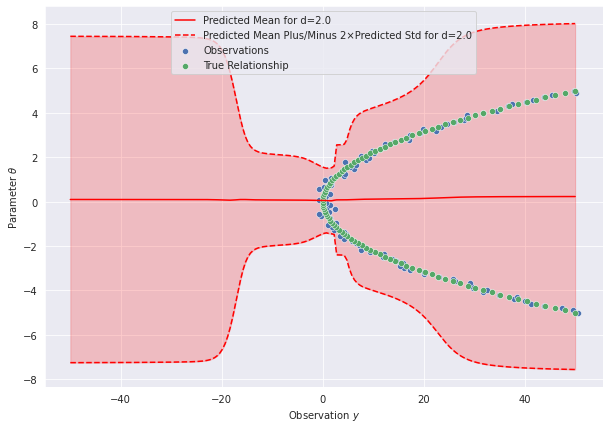

In [42]:
d_idx = 10
plot_phi_function(amortised_dist, d_idx, d=d, y_obs=y, model=model_func)